*Avtor:* Tim Kmecl

In [1]:
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.optimize
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set("paper")
sns.set()
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"axes.facecolor": "1",
                            'axes.spines.left': False,
                            'axes.spines.top': False,
                            'axes.spines.right': False,
                            'axes.edgecolor': '.4',
                            'axes.grid': True,
                            'grid.color': '.85'})

plt.rcParams["figure.figsize"] = [6.4, 4.8]

plt.rcParams["lines.linewidth"] = 2

plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.markeredgecolor"] = "w"
plt.rcParams["lines.markeredgewidth"] = "2"
plt.rcParams["lines.markersize"] = 6
palette = "Blues_d"

plt.rcParams['figure.dpi'] = 100

blues_d = cm.Blues(np.linspace(.3, 1, 5))
blues_dd = cm.Blues(np.linspace(.3, 1, 5))

cmap = np.concatenate((cm.Blues(np.linspace(0.3, 1, 5))[:,:3], 0.3 +  cm.plasma(np.linspace(0.15, 1, 7))[:,:3]*0.7))
cm_stran = cmap[[4, 2, 0, 5,6,7,8,9,10,11, 1, 3]]
cmap = cmap[[4, 3, 2, 1, 0, 5,6,7,8,9,10,11]]

save_dpi=150
cur_img = 0

In [4]:
def utils_plot1(ax, log, title, ylim, xticks):
    if xticks is not None:
        ax.set_xticks(xticks)
    ax.set_title(title + (" [log]" if log else ""))
    ax.set_ylim(0 if (ylim==None and not log) else (0.95 if ylim==None else ylim))
    ax.set_yscale("log" if log else "linear")
    ax.xaxis.set_tick_params(labelbottom=True)
    plt.subplots_adjust(wspace=0.13, top=0.91, left=.06, right=.93, bottom=.08) 
    ax.set(xlabel=None)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.grid(dashes=(3, 4))
    if log:
        ax.grid(axis="y", which="minor", dashes=(3, 4), alpha=.4)
    ax.grid(dashes=(3, 3))
    
def plot_bar_m1(ax, x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None, width=(0.75, 0.3, 0.1), show=True, x3=None, y3=None, c=None):
    clr = c if c is not None else cmap[1]
    if not x2 is None and not y2 is None:
        ax.bar(x2, y2, color=clr, alpha=.2, width=(width[1] if len(width)>1 else width[0]))
    if len(x) and len(y):
        ax.bar(x, y, color=clr, width=width[0])
    if x3 is not None and y3 is not None:
        ax.bar(x3, y3, width=(width[2] if len(width)>2 else width[0]), color=".25", alpha=.7, linewidth=0)
    
    utils_plot1(ax, log, title, ylim, xticks)

def plot_line1(ax, x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None, m2=True, show=True, color=None, c=None, no_marker=False):
    clr = c if c is not None else cmap[1]
    if len(x) and len(y):
        sns.lineplot(x, y, color=(clr if not color else color), ax=ax, marker=("" if no_marker else plt.rcParams["lines.marker"]))
    if x2 is not None and y2 is not None:
        sns.lineplot(x2, y2, color=(clr if m2 else "orange"), marker=(plt.rcParams["lines.marker"] if m2 else ""), alpha=(.2 if m2 else 1), ax=ax)
    
    utils_plot1(ax, log, title, ylim, xticks)

def plot_bar1(ax, x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None):
    if not x2 is None and not y2 is None:
        sns.lineplot(x2, y2, color="orange", marker="", ax=ax)
    if len(x) and len(y):
        ax.bar(x, y, color="b", width=0.7)
    
    utils_plot1(ax, log, title, ylim, xticks)

In [5]:
def cat(l):
    return np.concatenate(l)

def reverse_legend(ax, labels1=None):
    handles, labels = ax.get_legend_handles_labels()
    if labels1 is None:
        ax.legend(handles[::-1], labels[::-1])
    else:
        ax.legend(handles[::-1], labels1[::-1])

---

%%latex
\newpage

# Podatki

Vir 1: NIJZ *\[[Spremljanje koronavirusa SARS-CoV-2 (COVID-19)](https://www.nijz.si/sl/pojav-novega-koronavirusa-2019-ncov)\]*  
Vir 2: prirejeno po NIJZ: *\[[Dnevno spremljanje okužb s SARS-CoV-2 (COVID-19) [graf]](https://www.nijz.si/sl/dnevno-spremljanje-okuzb-s-sars-cov-2-covid-19)\]*  
Vir 3: Objave vlade na [gov.si](https://www.gov.si/teme/koronavirus/) in [twitterju](https://twitter.com/vladaRS).  
*Vir 4: Luka Renko et al., [COVID-19 Slovenija](https://slo-covid-19.rtfm.si/#/about)*

Na grafih je *vir 2* temno moder, *vir 1* svetlo moder, *vir 3* pa siv.

- pri *vir 1* so podatki na začetku za ob 14h, od dneva 11 naprej ob ~10-14h na določen dan, zato so na grafu zamaknjeni za 0.5 dneva v levo  
- pri *vir 2* so podatki na začetku za konec dneva, od dneva 15 naprej naslednji dan ob 10h  
- pri *vir 3* ni točno zabeleženo, na katero obdobje se podatki nanašajo, objavljeno enkrat popoldne  
- *vir 4* samo za hospitalizacije ipd. (neuradno!), in po regijah ter starostirh (uradno, posredno iz *vir 2*)  

Dan 1 je *4.3.*, zadnjič posodobljeno *26.3.* (zadnji celodnevni podatek velja za en dan nazaj).

In [6]:
df = pd.read_csv("./korona_slo.csv",  index_col="dan")
#df['datum'] = pd.to_datetime(df['datum'], format='%d.%m.')

## Podatki o okuženih

In [7]:
df["oku_novi_24h"] = df.oku_24h.diff()
df["oku_novi_10h"] = df.oku_10h.diff()
df["oku_novi_14h"] = df.oku_14h.diff()

In [9]:
df["rast_24h"] = [None] + [df.oku_24h[i]/df.oku_24h[i-1] for i in df.index[1:]]
df["rast_14h"] = [None] + [df.oku_14h[i]/df.oku_14h[i-1] for i in df.index[1:]]
df["rast_gov"] = [None] + [1 + df.oku_novi_gov[i]/df.oku_24h[i-1] for i in df.index[1:]]
df["podvojitev_24h"] = math.log(2)/np.log(df["rast_24h"])
df["podvojitev_14h"] = math.log(2)/np.log(df["rast_14h"])
df["podvojitev_gov"] = math.log(2)/np.log(df["rast_gov"])

/home/tim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.
/home/tim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """Entry point for launching an IPython kernel.
/home/tim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/tim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


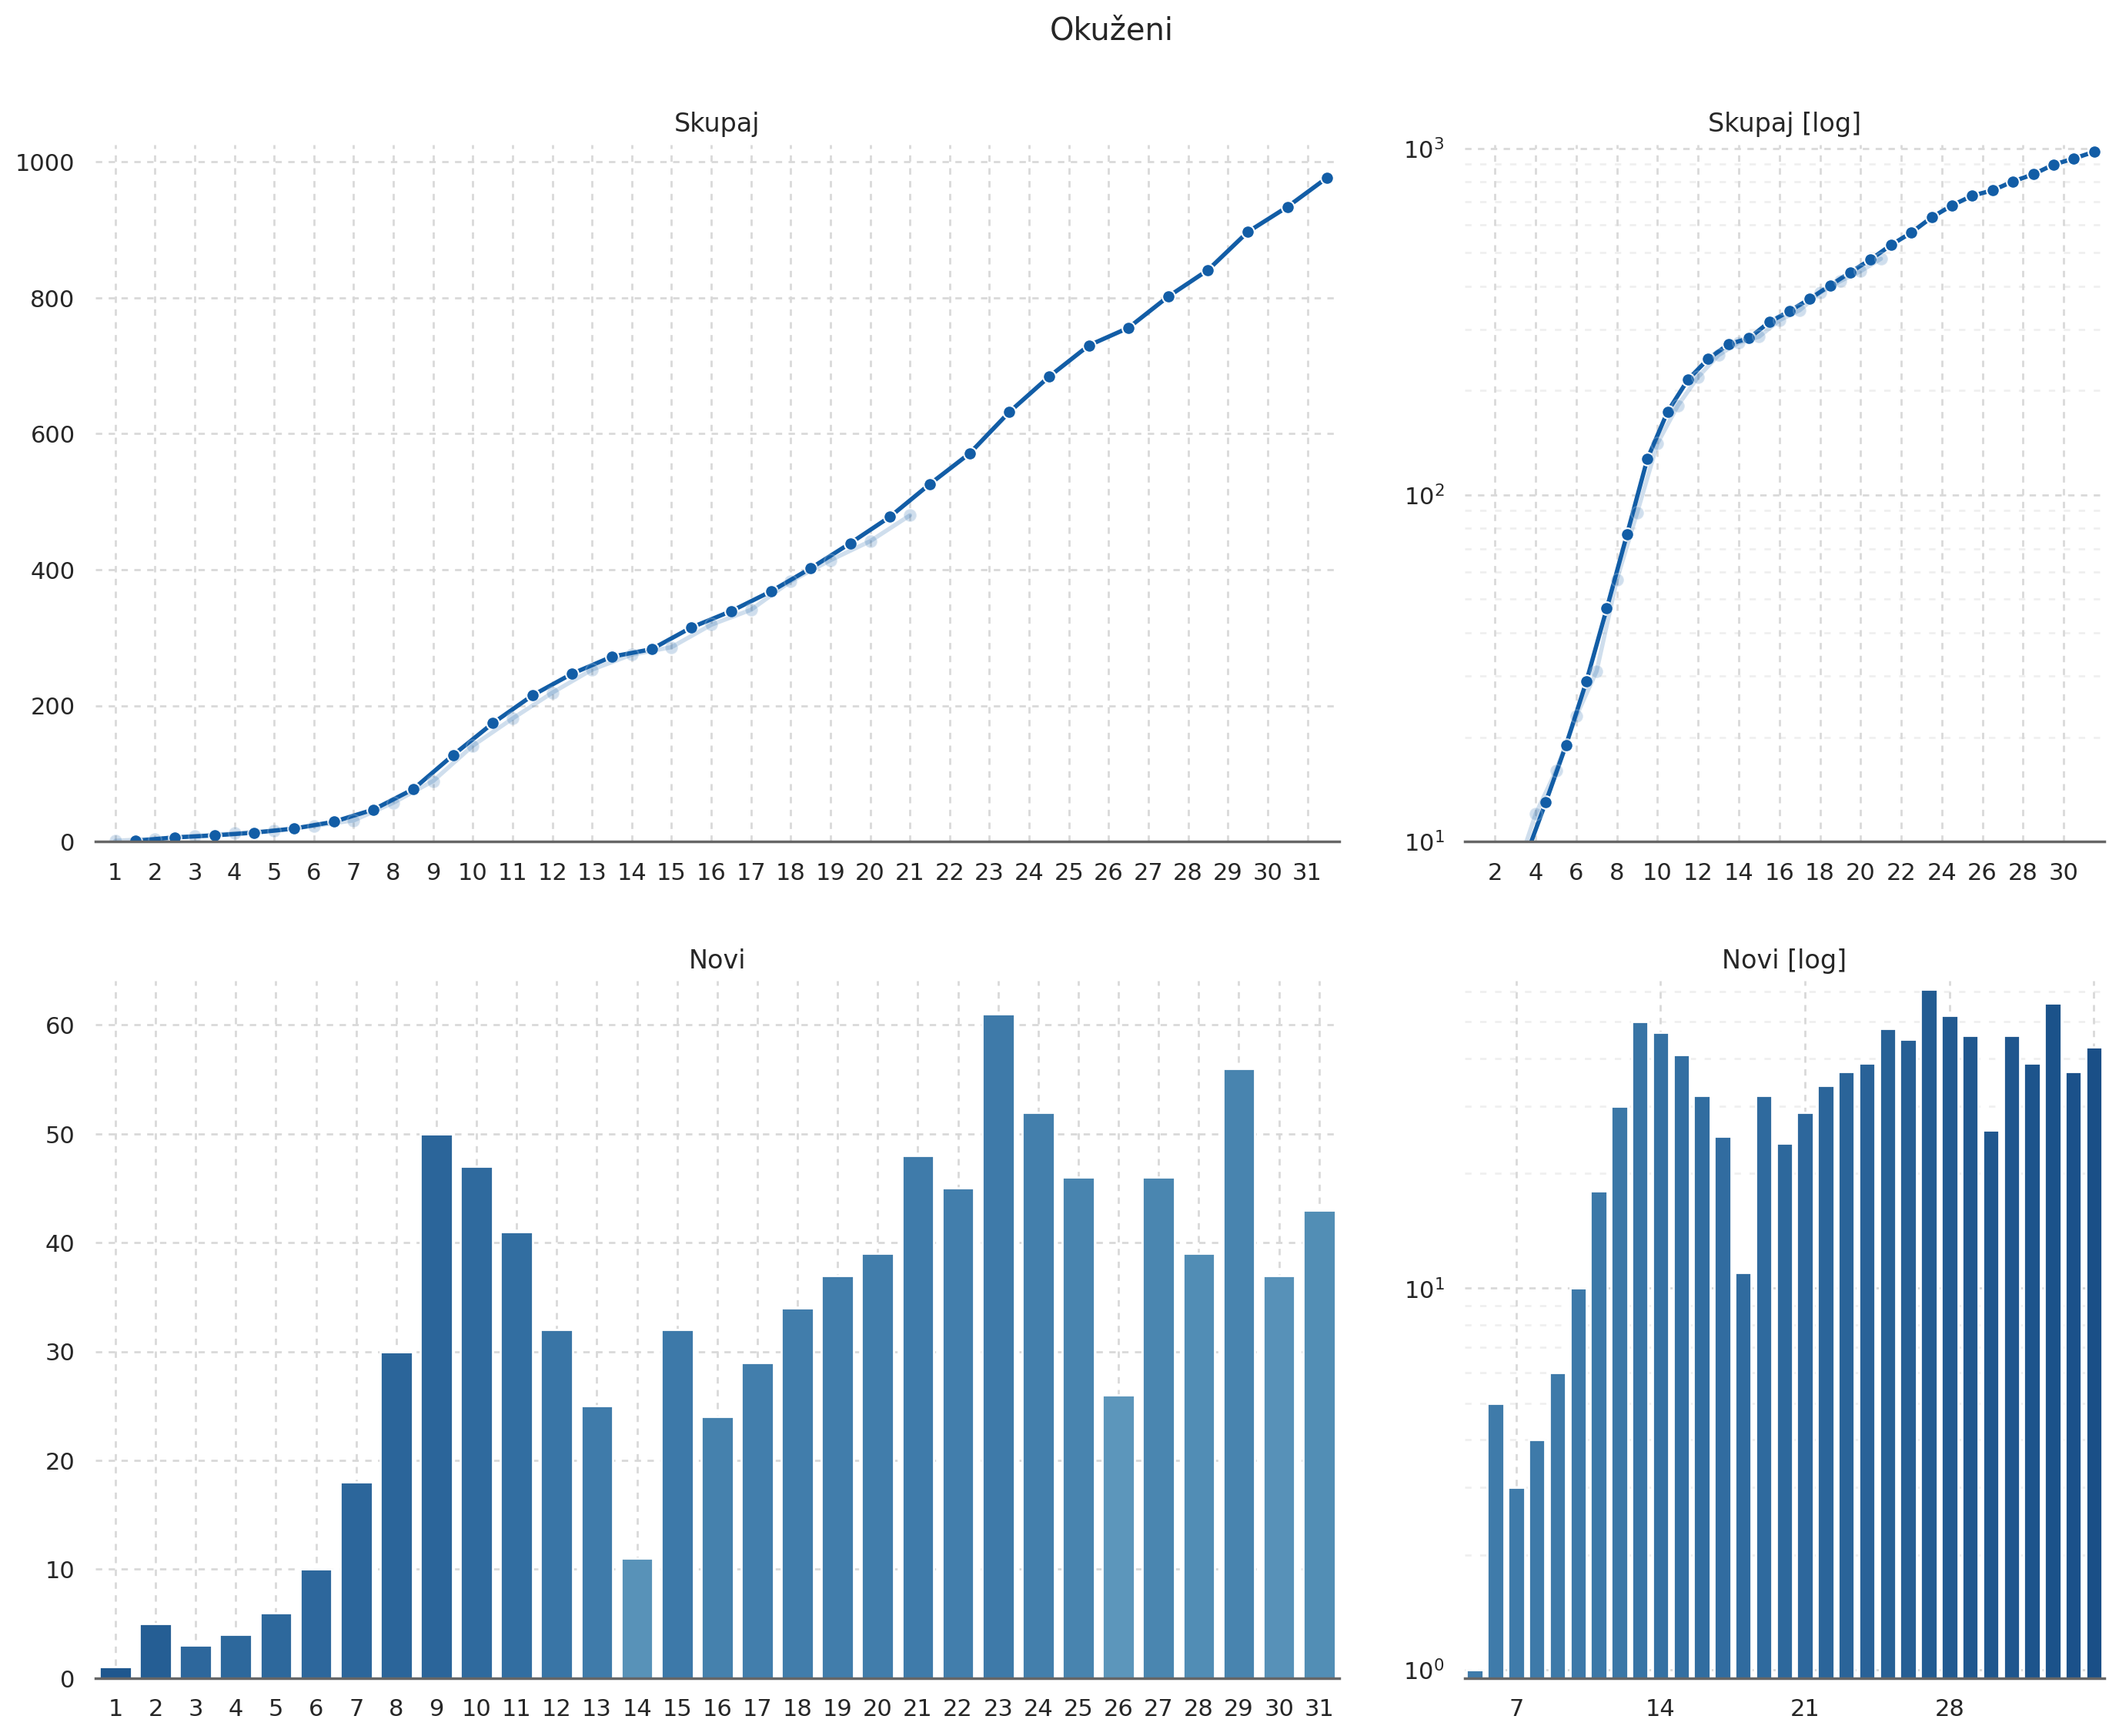

In [25]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex="all")

fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 50)
ax1 = fig.add_subplot(gs[0, 0:31])
ax2 = fig.add_subplot(gs[0, 34:])
ax3 = fig.add_subplot(gs[1, 0:31])
ax4 = fig.add_subplot(gs[1, 34:])

fig.suptitle("Okuženi")
dfp = df[4:]
c=cmap[1]
plot_line1(ax1, dfp.index+.5, dfp.oku_24h, False, "Skupaj", xticks=dfp.index,
          x2=dfp.index, y2=dfp.oku_14h, c=c)
ax1.set_xlim(0.5, dfp.index[-1]+.8)
plot_line1(ax2, dfp.index+.5, dfp.oku_24h, True, "Skupaj", xticks=dfp.index[1::2],
          x2=dfp.index, y2=dfp.oku_14h, ylim=10, c=c)
ax2.set_xlim(0.5, dfp.index[-1]+1)

#plot_bar_m1(ax3, dfp.index, dfp.oku_novi_24h, False, "Novi", xticks=dfp.index, 
#          x2=dfp.index - .5, y2=dfp.oku_novi_14h, c=c)#, x3=dfp.index+.55-1, y3=dfp.oku_novi_gov)
#plot_bar_m1(ax4, dfp.index, dfp.oku_novi_24h, True, "Novi", xticks=dfp.index[::2], 
#         x2=dfp.index - .5, y2=dfp.oku_novi_14h, c=c, ylim=(1,100))#, x3=dfp.index+.55-1, y3=dfp.oku_novi_gov)

sns.barplot(dfp.index, dfp.oku_novi_24h, ax=ax3,palette=cm.Blues(.85 - (dfp['podvojitev_24h']**0.55)/20))
utils_plot1(ax3, False, "Novi", None, None)
plt.xticks(dfp.index[6::7], dfp.index[6::7])

sns.barplot(dfp.index, dfp.oku_novi_24h, ax=ax4,palette=cm.Blues(.7 + 0.25*np.log(1+dfp['oku_24h']/dfp.at[df.index[-2], 'oku_24h']) ))
utils_plot1(ax4, True, "Novi", None, None)
plt.xticks(dfp.index[1::7], dfp.index[6::7])
plt.show()

## Rast

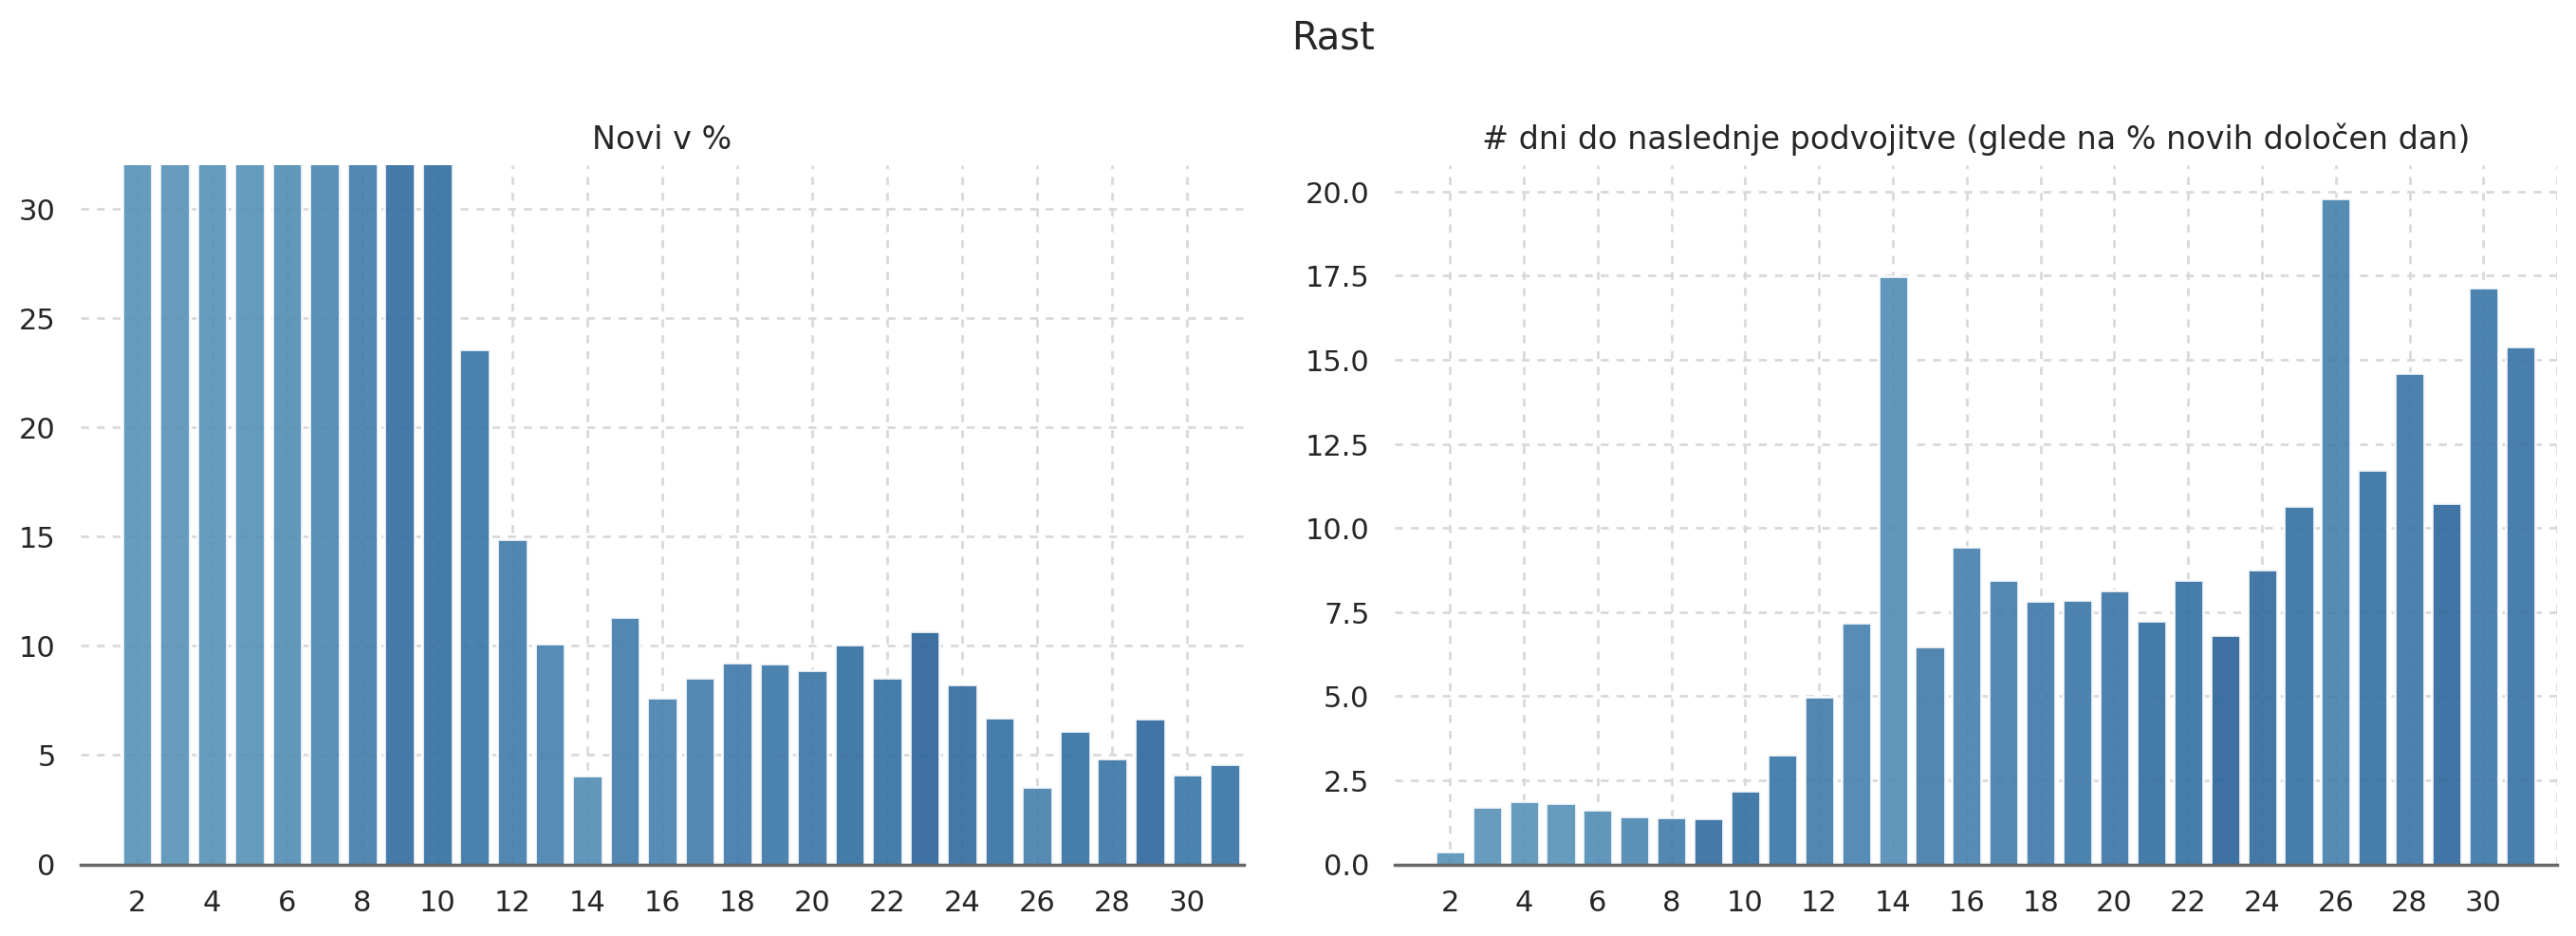

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5.5), sharex=True)
fig.suptitle("Rast", y=0.96)
dfp = df[4:]

if False:
    c = (cmap[2]+cmap[1])/2
    plot_bar_m1(ax1, dfp.index, (dfp.rast_24h-1)*100, False, "Novi v %", ylim=(0,75), xticks=dfp.index,
              x2=dfp.index - .5, y2=(dfp.rast_14h-1)*100, c=c)#, x3=dfp.index-.45, y3=(dfp.rast_gov-1)*100)
    plot_bar_m1(ax2, dfp.index, dfp.podvojitev_24h, False, 
               "Število dni do naslednje podvojitve (glede na % novih določen dan)", xticks=dfp.index[::2],
              x2=dfp.index - .5, y2=dfp.podvojitev_14h, c=c)#, x3=dfp.index-.45, y3=dfp.podvojitev_gov)
    plt.subplots_adjust(top=0.82, bottom=.15)
else:
    sns.barplot(dfp.index, dfp.rast_24h*100-100, ax=ax1,palette=cm.Blues(.6 + dfp['oku_novi_24h']/300), alpha=.9)
    utils_plot1(ax1, False, "Novi v %", (0, 32), None)

    sns.barplot(dfp.index, dfp.podvojitev_24h, ax=ax2,palette=cm.Blues(.6 + dfp['oku_novi_24h']/300), alpha=.9 )
    utils_plot1(ax2, False, "# dni do naslednje podvojitve (glede na % novih določen dan)", None, None)
    plt.xticks(dfp.index[::2], dfp.index[1::2])
    plt.subplots_adjust(top=0.82, bottom=.15)

## Podatki o testih

In [27]:
df["testi_novi_24h"] = df.testi_24h.diff()
df["testi_novi_14h"] = df.testi_14h.diff()

In [28]:
df["testi_procent_24h"] = df.oku_24h/df.testi_24h
df["testi_procent_14h"] = df.oku_14h/df.testi_14h

df["testi_novi_procent_24h"] = df.oku_novi_24h/df.testi_novi_24h
df["testi_novi_procent_14h"] = df.oku_novi_14h/df.testi_novi_14h
df["testi_novi_procent_gov"] = df.oku_novi_gov/df.testi_novi_gov

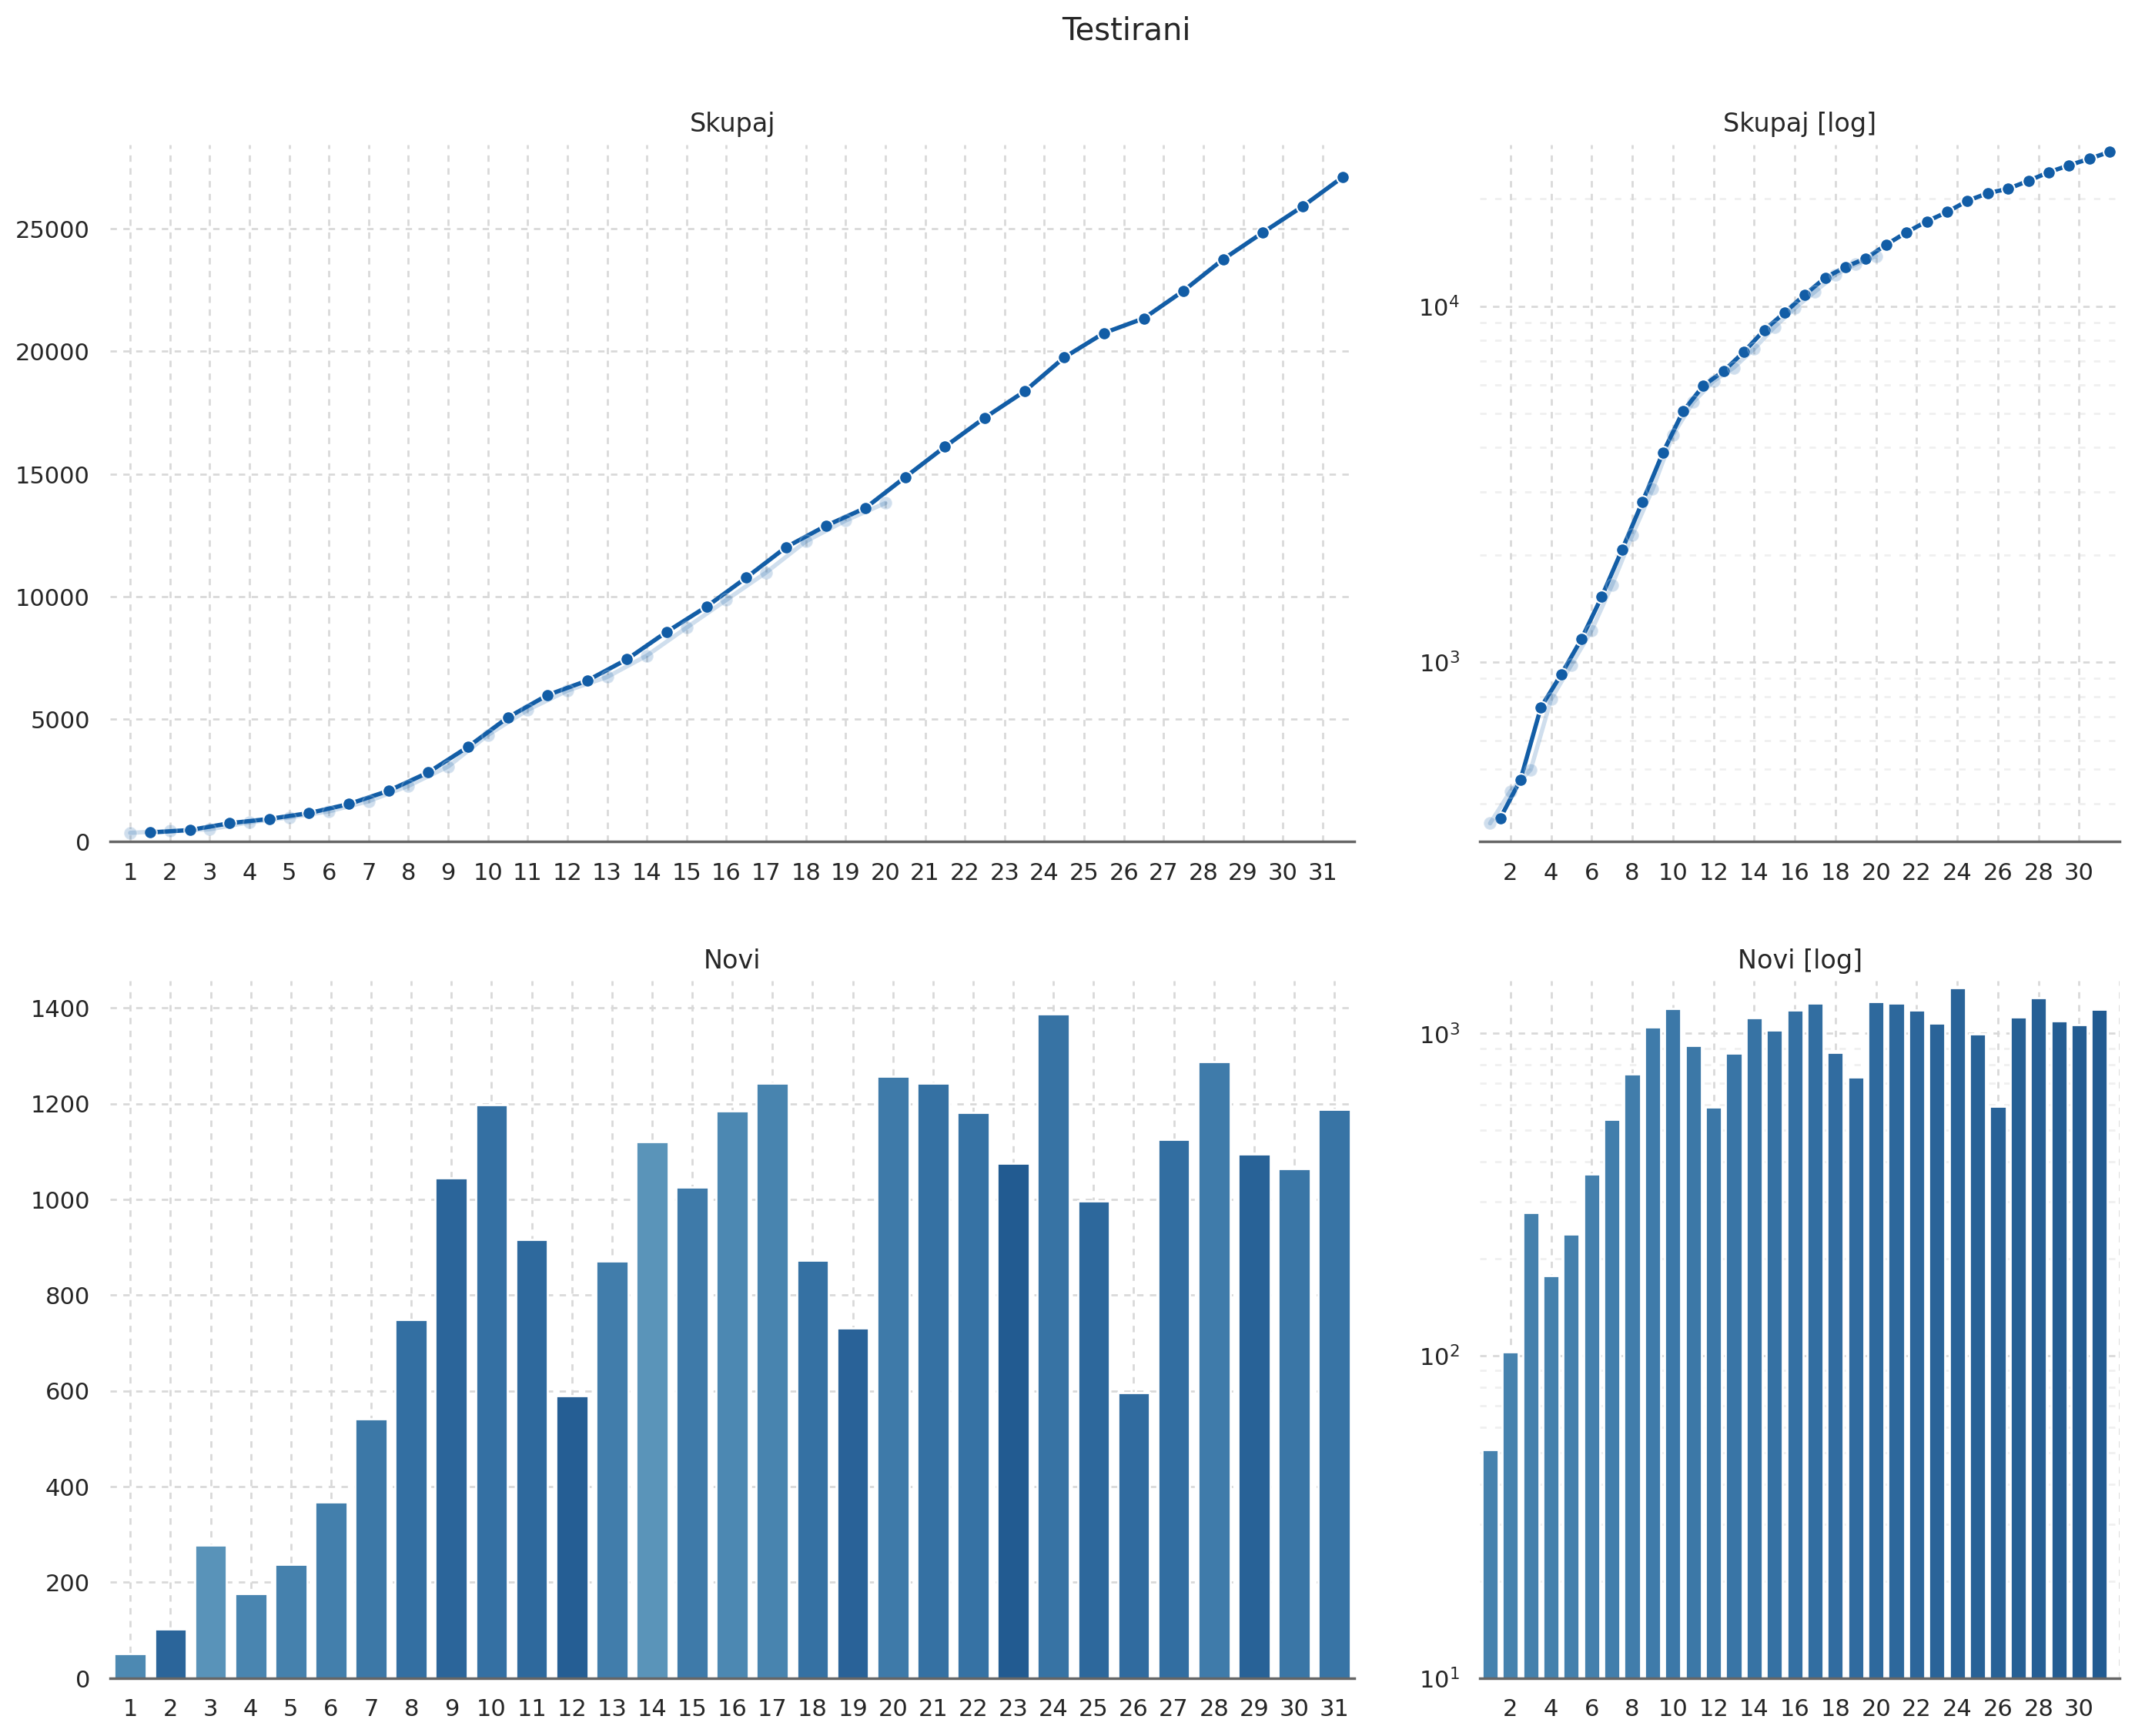

In [29]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 50)
ax1 = fig.add_subplot(gs[0, 0:31])
ax2 = fig.add_subplot(gs[0, 34:])
ax3 = fig.add_subplot(gs[1, 0:31])
ax4 = fig.add_subplot(gs[1, 34:])

fig.suptitle("Testirani")
dfp = df[4:]
c=cmap[1]

plot_line1(ax1, dfp.index+.5, dfp.testi_24h, False, "Skupaj", xticks=dfp.index,
          x2=dfp.index, y2=dfp.testi_14h, c=c)
ax1.set_xlim(0.5, dfp.index[-1]+.8)
plot_line1(ax2, dfp.index+.5, dfp.testi_24h, True, "Skupaj", xticks=dfp.index[1::2],
          x2=dfp.index, y2=dfp.testi_14h, ylim=313, c=c)
ax2.set_xlim(0.5, dfp.index[-1]+1)

#plot_bar_m1(ax3, dfp.index, dfp.testi_novi_24h, False, "Novi", xticks=dfp.index, 
#          x2=dfp.index -.5, y2=dfp.testi_novi_14h, c=c)#, x3=dfp.index+.55-1, y3=dfp.testi_novi_gov)
#plot_bar_m1(ax4, dfp.index, dfp.testi_novi_24h, True, "Novi", xticks=dfp.index[::2], c=c, ylim=10,
#          x2=dfp.index -.5, y2=dfp.testi_novi_14h)#, x3=dfp.index+.55-1, y3=dfp.testi_novi_gov, ylim=10)

sns.barplot(dfp.index, dfp.testi_novi_24h, ax=ax3,palette=cm.Blues(.55 + dfp['testi_novi_procent_24h']*5))
utils_plot1(ax3, False, "Novi", None, None)

sns.barplot(dfp.index, dfp.testi_novi_24h, ax=ax4,palette=cm.Blues(.67 + 0.23*np.log(1+ dfp['testi_24h']/dfp.at[df.index[-2], 'testi_24h']) ))
utils_plot1(ax4, True, "Novi", 10, None)
plt.xticks(dfp.index[::2], dfp.index[1::2])
plt.show()

## Razmerja med testi in okuženimi

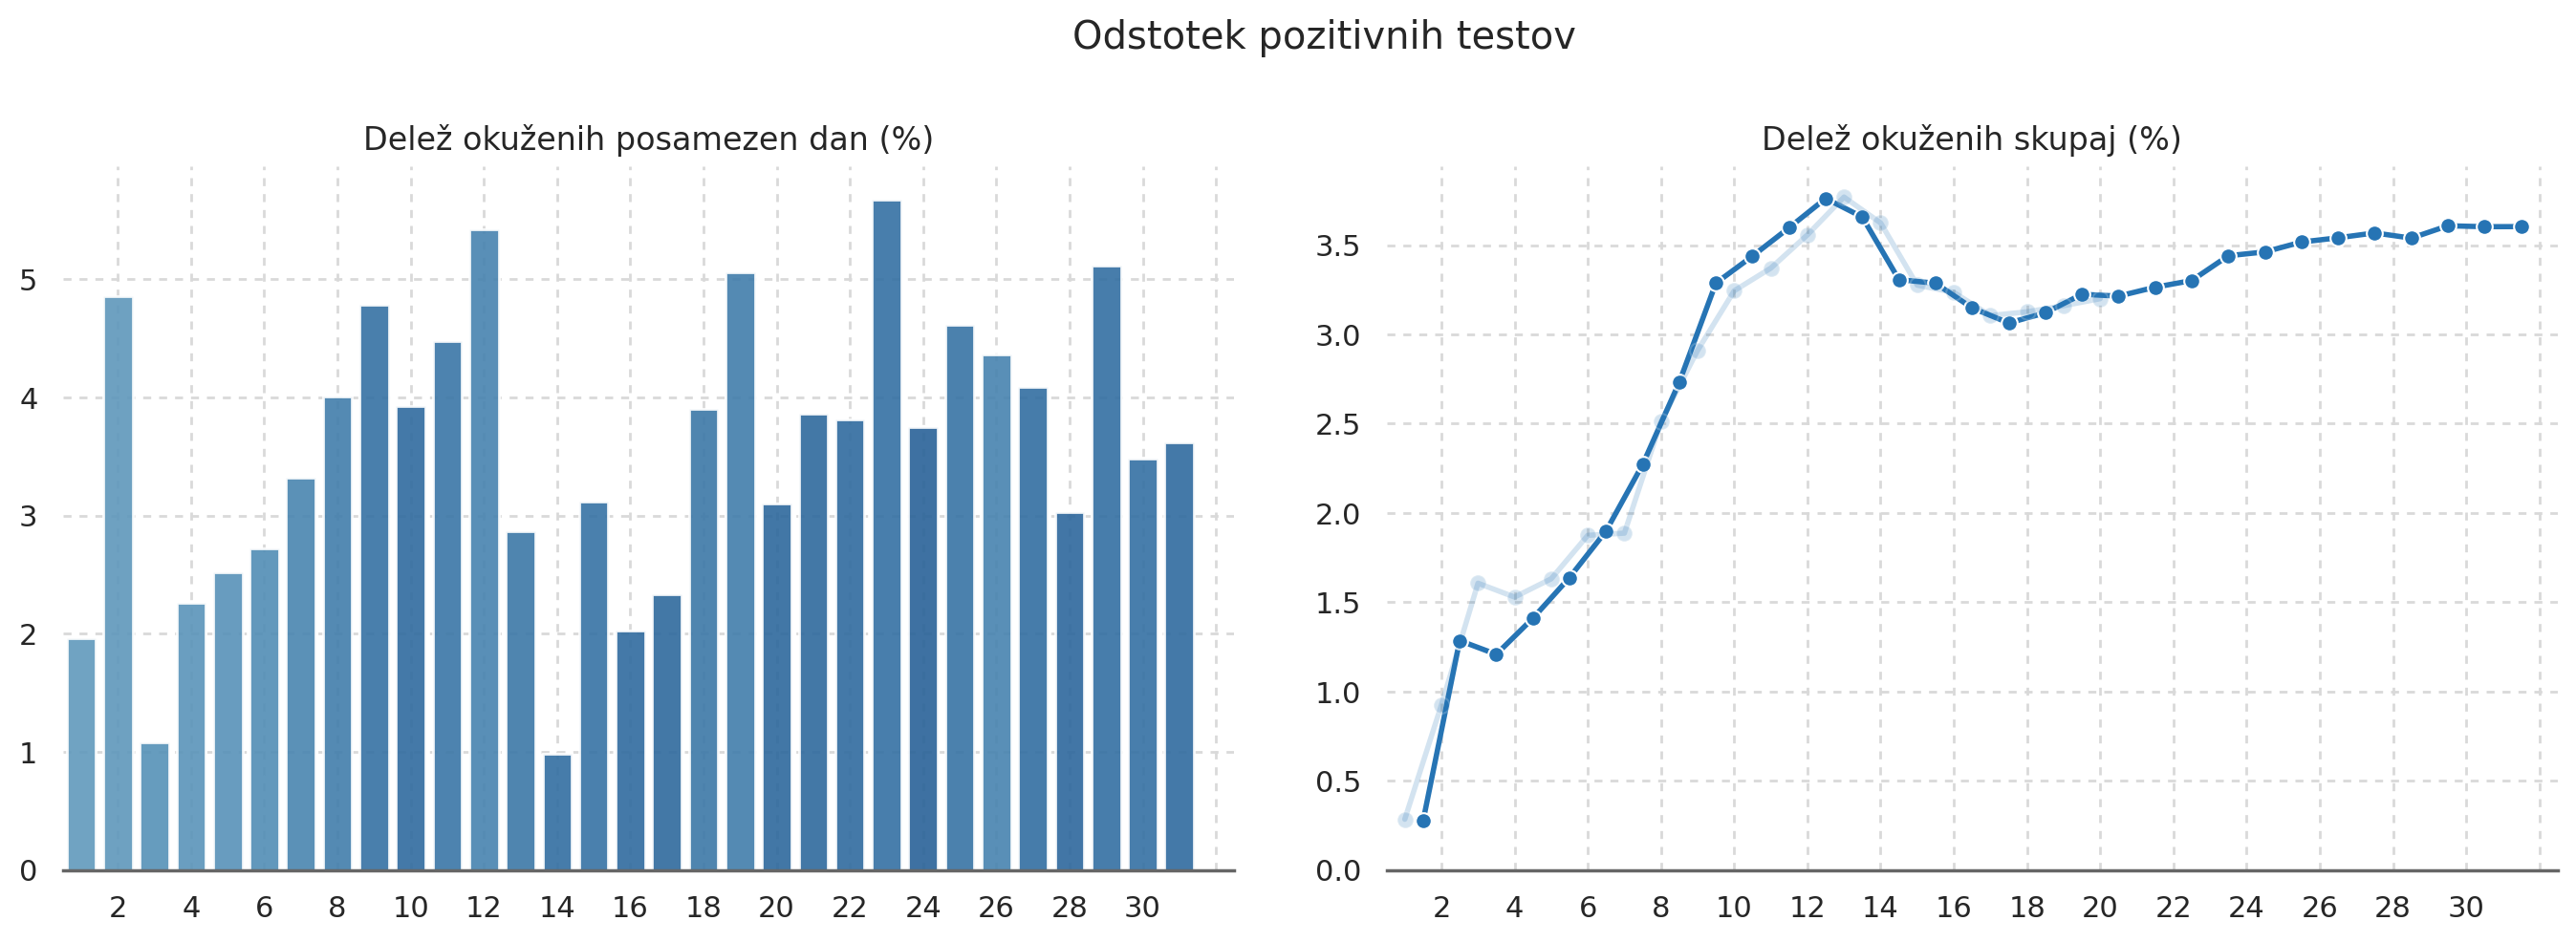

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5.5), sharex=True)
fig.suptitle("Odstotek pozitivnih testov", y=0.96)
dfp = df[4:]

c = (cmap[2]+cmap[1])/2

plot_line1(ax2, dfp.index-.5, dfp.testi_procent_24h*100, False, "Delež okuženih skupaj (%)", xticks=dfp.index,
          x2=dfp.index-1, y2=dfp.testi_procent_14h*100, c=c)

if False:
    plot_bar_m1(ax1, dfp.index, dfp.testi_novi_procent_24h*100, False, "Delež okuženih posamezen dan (%)", xticks=dfp.index[::2], 
              x2=dfp.index - .5, y2=dfp.testi_novi_procent_14h*100, c=c)#, x3=dfp.index+.55-1, y3=dfp.testi_novi_procent_gov*100)
else:
    sns.barplot(dfp.index, dfp.testi_novi_procent_24h*100, ax=ax1, palette=cm.Blues(.57 + dfp['testi_novi_24h']/6000), alpha=.9 )
    utils_plot1(ax1, False, "Delež okuženih posamezen dan (%)", None, None)
    plt.xticks(dfp.index[::2], dfp.index[1::2])
    ax1.set_xlim(-0.5, dfp.index[-1]+.5)
plt.subplots_adjust(top=0.82, bottom=.15)

## Hospitalizacije, regije in starost *(vir 4)*

### Hospitalizacije

In [31]:
df["hospitalizirani_skupaj"] = df["hospitalizirani"] + df["odpusceni"] + df["umrli"]
df["hospitalizirani_skupaj"] -= df["hospitalizirani_skupaj"].diff().fillna(0).clip(None, 0)

df["hospitalizirani_neur_skupaj"] = df["hospitalizirani_neur"] + df["odpusceni_neur"]

df["hospitalizirani_rel"] = df["hospitalizirani"]/df["oku_24h"]
df["hospitalizirani_skupaj_rel"] = df["hospitalizirani_skupaj"]/df["oku_24h"]
df["intenzivni_rel"] = df["intenzivni"]/df["oku_24h"]
df["umrli_rel"] = df["umrli"]/df["oku_24h"]
if np.any(np.isnan(df["umrli_rel"][-1:])):
    df.at[df.index[-1], "umrli_rel"] = df["umrli"][-1:].to_numpy()/df["oku_24h"][-2:-1].to_numpy()
 
df["hospitalizirani_neur_rel"] = df["hospitalizirani_neur"]/df["oku_24h"]
df["hospitalizirani_neur_skupaj_rel"] = df["hospitalizirani_neur_skupaj"]/df["oku_24h"]
df["intenzivni_neur_rel"] = df["intenzivni_neur"]/df["oku_24h"]
if np.any(np.isnan(df["intenzivni_neur_rel"][-1:])):
    df.at[df.index[-1], "intenzivni_neur_rel"] = df["intenzivni_neur"][-1:].to_numpy()/df["oku_24h"][-2:-1].to_numpy()
    df.at[df.index[-1], "hospitalizirani_neur_rel"] = df["hospitalizirani_neur"][-1:].to_numpy()/df["oku_24h"][-2:-1].to_numpy()

In [32]:
df["intenzivni_skupaj"] = df["intenzivni"] + df["umrli"]
df["intenzivni_skupaj"] -= df["intenzivni_skupaj"].diff().fillna(0).clip(None, 0)
df["intenzivni_skupaj_rel"] = df["intenzivni_skupaj"]/df["oku_24h"]

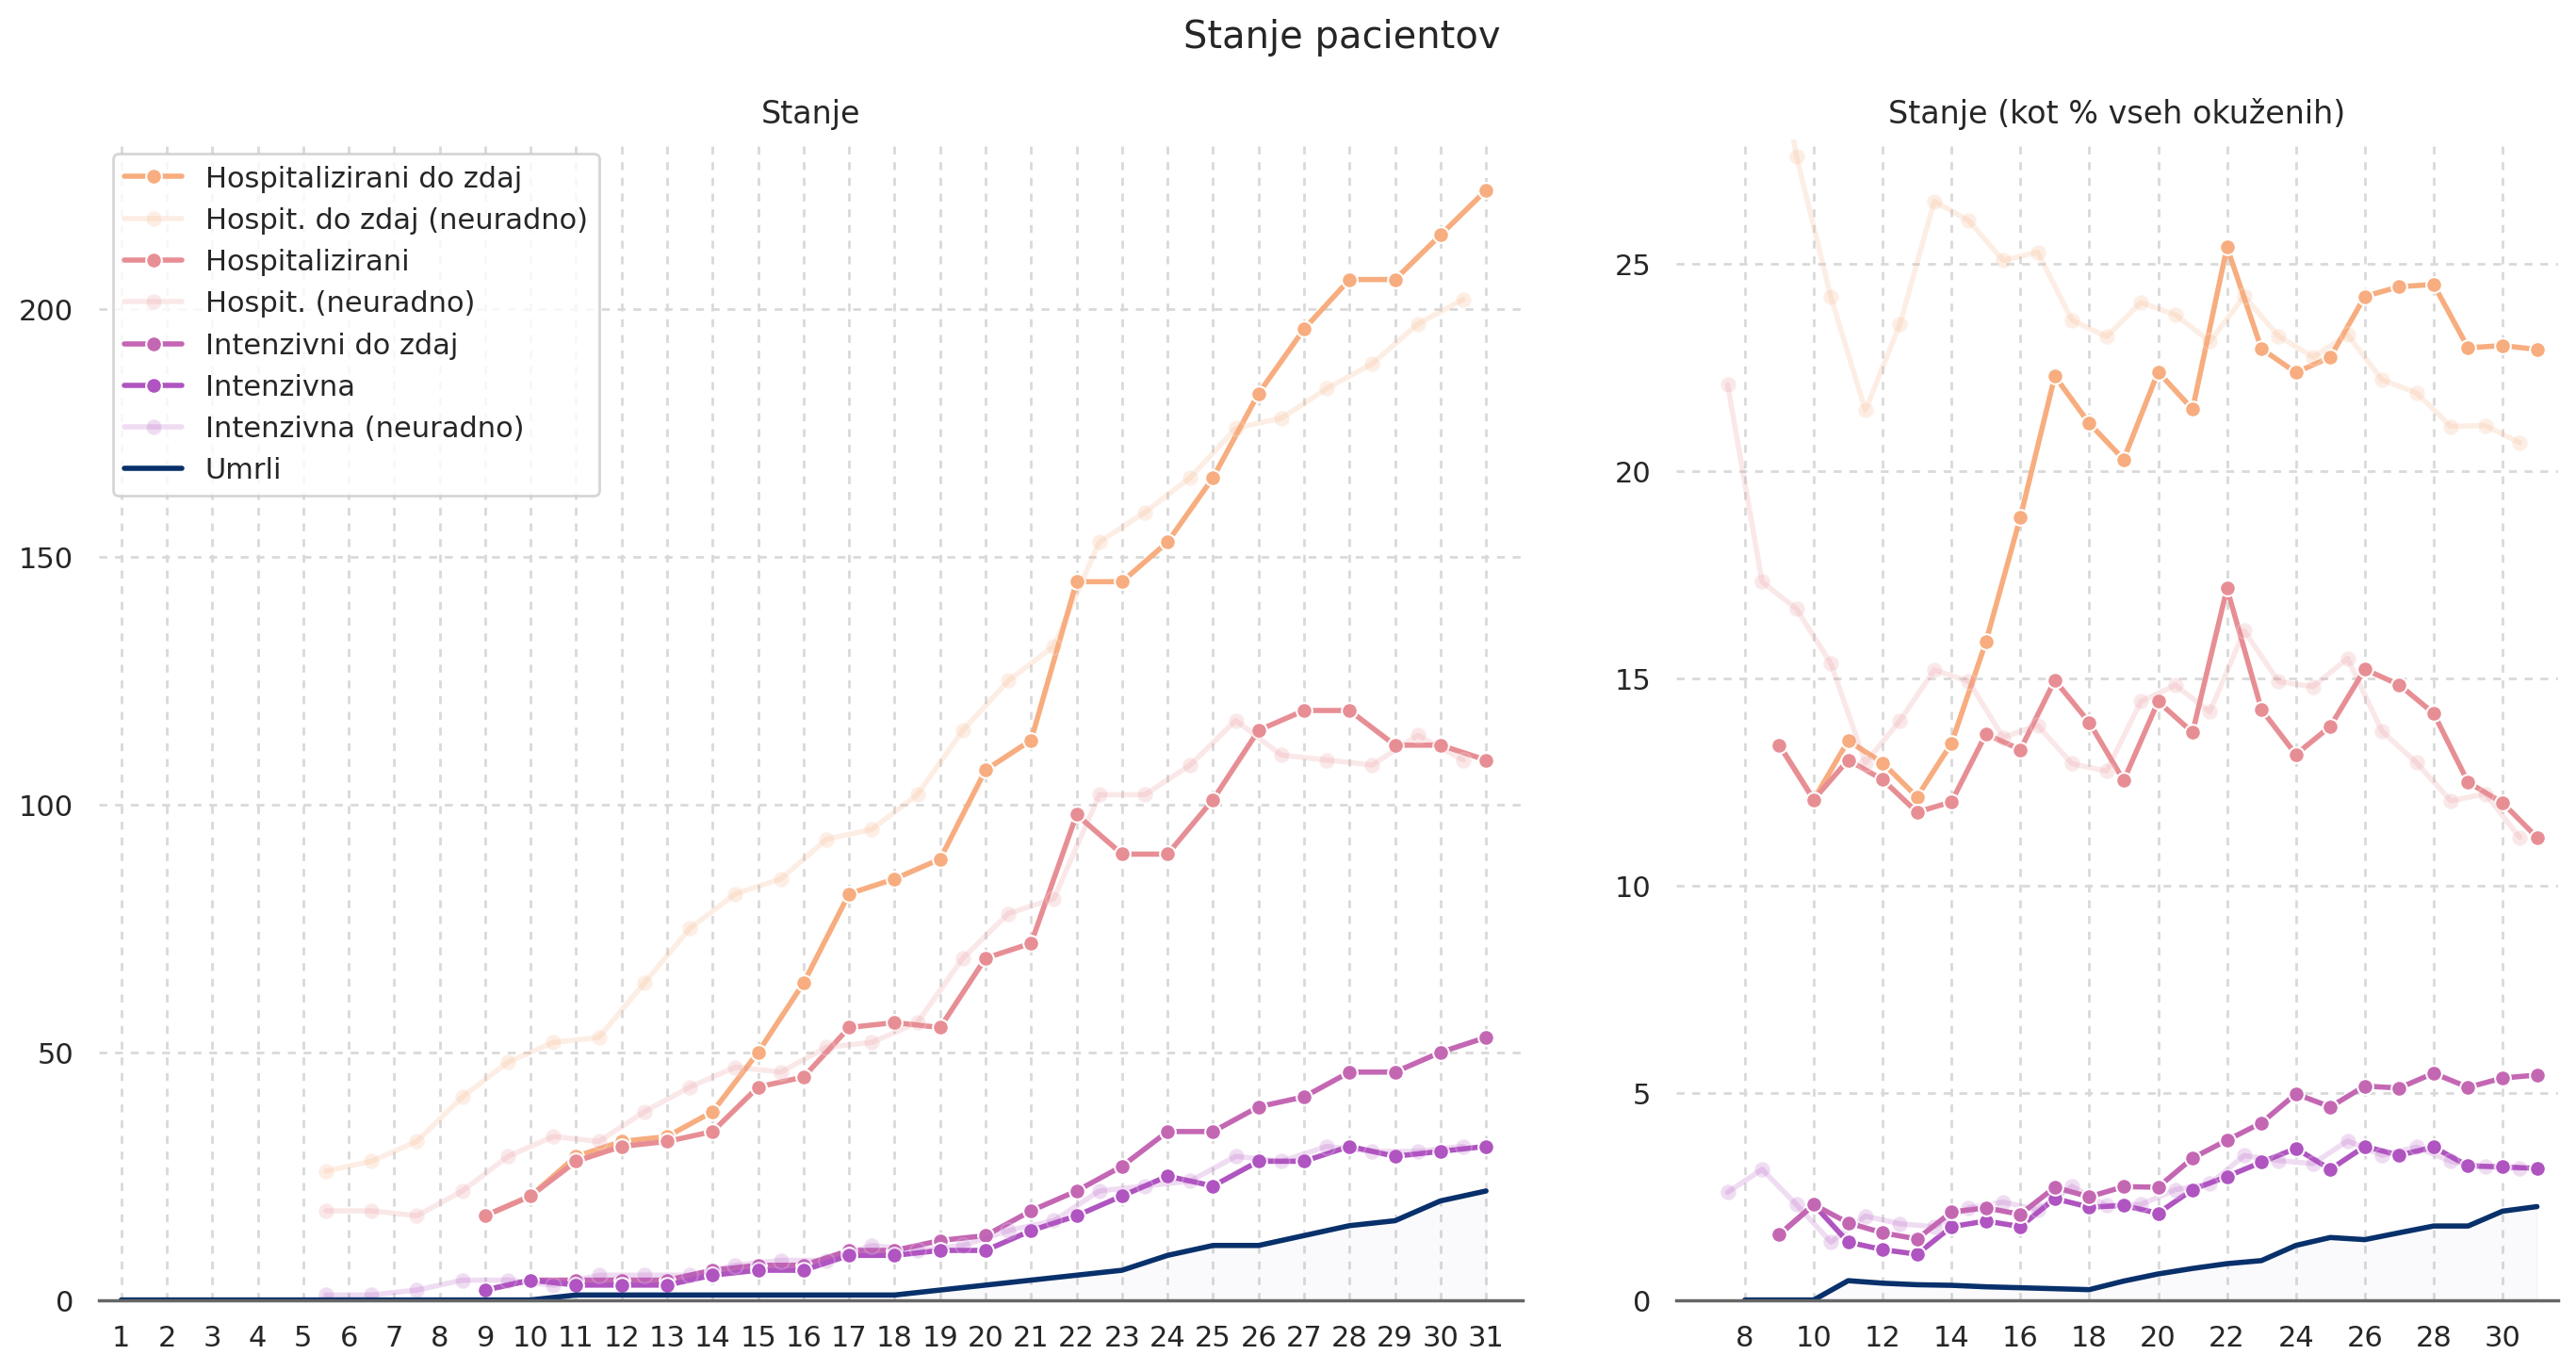

In [33]:
#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharex=True)

fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(1, 50)
ax1 = fig.add_subplot(gs[0, 0:29])
ax2 = fig.add_subplot(gs[0, 32:])

fig.suptitle("Stanje pacientov", y=0.96)
dfp = df[4:]#[pd.notna(df.hospitalizirani)]
c1 = cmap[8]
c2 = cmap[6]
c3 = cmap[0]
c4 = cmap[9]
c5 = (cmap[6]/2 + cmap[7])/1.5

plus = dfp["umrli"]
plus = 0

plot_line1(ax1, dfp.index, dfp["hospitalizirani_skupaj"], False, "",
          x2=dfp.index-.5, y2=dfp["hospitalizirani_neur_skupaj"], c=c4)
plot_line1(ax1, dfp.index, dfp["hospitalizirani"]+plus, False, "",
          x2=dfp.index-.5, y2=dfp["hospitalizirani_neur"]+plus, c=c1)

plot_line1(ax1, dfp.index, dfp["intenzivni_skupaj"], False, "",c=c5)
plot_line1(ax1, dfp.index, dfp["intenzivni"]+plus, False, "",
          x2=dfp.index-.5, y2=dfp["intenzivni_neur"]+plus, c=c2)


plot_line1(ax1, dfp.index, dfp["umrli"], False, "Stanje", c=c3, no_marker=True, xticks=dfp.index[::])
ax1.fill_between(dfp.index, dfp["umrli"], color=c3, alpha=.02)

ax1.legend(["Hospitalizirani do zdaj", "Hospit. do zdaj (neuradno)", "Hospitalizirani", "Hospit. (neuradno)", "Intenzivni do zdaj", "Intenzivna", "Intenzivna (neuradno)", "Umrli"])
ax1.set_xlim(0.5, dfp.index[-1]+.8)

dfp = df[11:]
plus_rel = 0#dfp["umrli_rel"]

#ax2.fill_between(dfp.index, dfp["hospitalizirani_rel"]*100 +plus_rel*100, dfp["intenzivni_rel"]*100 +plus_rel*100, color=c1, alpha=.3)
plot_line1(ax2, dfp.index, dfp["hospitalizirani_skupaj_rel"]*100, False, "",
          x2=dfp.index-.5, y2=dfp["hospitalizirani_neur_skupaj_rel"]*100, c=c4)
plot_line1(ax2, dfp.index, dfp["hospitalizirani_rel"]*100 +plus_rel*100, False, "",
          x2=dfp.index-.5, y2=dfp["hospitalizirani_neur_rel"]*100 +plus_rel*100, c=c1)
#ax2.fill_between(dfp.index, dfp["intenzivni_rel"]*100 +plus_rel*100, dfp["umrli_rel"]*100, color=c2, alpha=.3)
plot_line1(ax2, dfp.index, dfp["intenzivni_rel"]*100 +plus_rel*100, False, "",
          x2=dfp.index-.5, y2=dfp["intenzivni_neur_rel"]*100 +plus_rel*100, c=c2)
plot_line1(ax2, dfp.index, dfp["intenzivni_skupaj_rel"]*100, False, "", c=c5)

plot_line1(ax2, dfp.index, dfp["umrli_rel"]*100, False, "Stanje (kot % vseh okuženih)", no_marker=True,c=c3, xticks=dfp.index[::2], ylim=(0,28))
ax2.fill_between(dfp.index, dfp["umrli_rel"]*100, color=c3, alpha=.02)
ax2.set_xlim(6, dfp.index[-1]+.6)
#plot_line1(ax2, dfp.index, dfp["hospitalizirani_neur_skupaj_rel"]*100 +plus_rel*100, False, "",c=c1)

plt.subplots_adjust(top=0.88, bottom=.11)
plt.show()

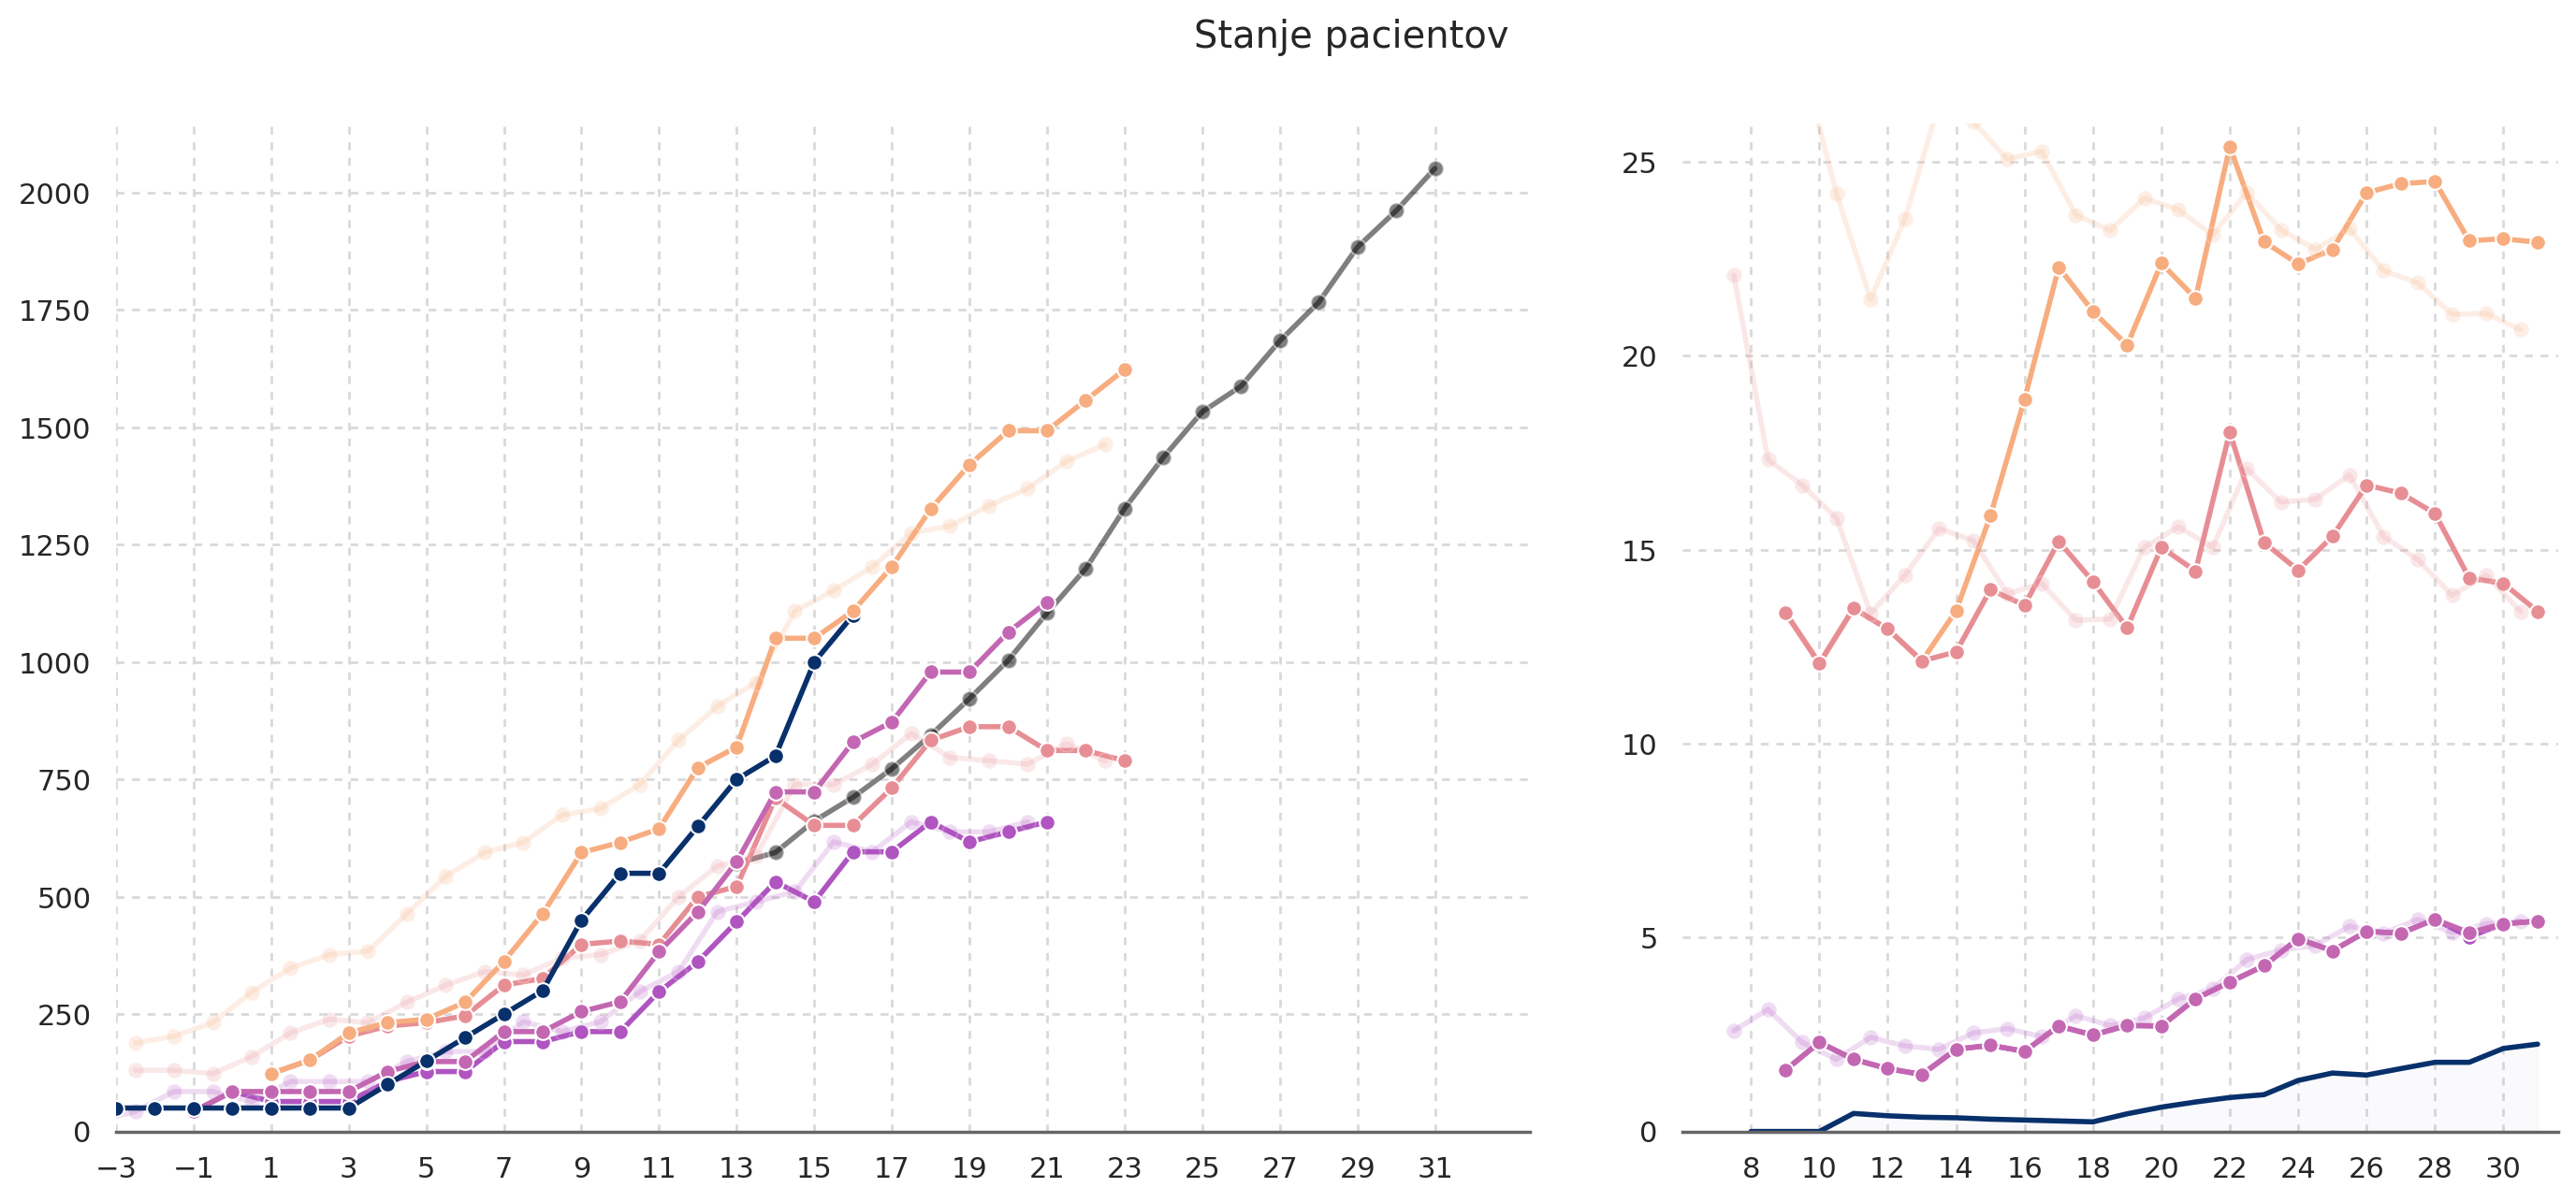

In [34]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 50)
ax1 = fig.add_subplot(gs[0, 0:29])
ax2 = fig.add_subplot(gs[0, 32:])

fig.suptitle("Stanje pacientov", y=0.96)
dfp = df[:]#[pd.notna(df.hospitalizirani)]

plus = 0#dfp["umrli"]
sns.lineplot(dfp.index[16:], 2.1*dfp["oku_24h"][16:], ax=ax1, color="black", alpha=.5)
plot_line1(ax1, dfp.index - 8, (dfp["hospitalizirani"]+plus)/0.138, False, "",
          x2=dfp.index-.5 - 8, y2=(dfp["hospitalizirani_neur"]+plus)/0.138, c=c1)

plot_line1(ax1, dfp.index - 10, (dfp["intenzivni"]+plus)/0.047, False, "",
          x2=dfp.index-.5 - 10, y2=(dfp["intenzivni_neur"]+plus)/0.047, c=c2)
plot_line1(ax1, dfp.index - 10, (dfp["intenzivni_skupaj"])/0.047, False, "",c=c5)

plot_line1(ax1, dfp.index - 15, dfp["umrli"]/0.02, False, "Stanje", c=c3, xticks=dfp.index[::2])
plot_line1(ax1, dfp.index - 8, dfp["hospitalizirani_skupaj"]/0.138, False, "",
          x2=dfp.index-.5 - 8, y2=dfp["hospitalizirani_neur_skupaj"]/0.138, c=c4)


#ax1.legend([None, "Hospitalizirnani", "Hospitalizirnani (neuradno)", None, "Intenzivna", "Intenzivna (neuradno)", "Umrli"])
ax1.set_xlim(-3)


dfp = df[11:]
plus_rel = dfp["umrli_rel"]

plot_line1(ax2, dfp.index, dfp["hospitalizirani_skupaj_rel"]*100, False, "",
          x2=dfp.index-.5, y2=dfp["hospitalizirani_neur_skupaj_rel"]*100, c=c4)
plot_line1(ax2, dfp.index, dfp["hospitalizirani_rel"]*100 +plus_rel*100, False, "",
          x2=dfp.index-.5, y2=dfp["hospitalizirani_neur_rel"]*100 +plus_rel*100, c=c1)

plot_line1(ax2, dfp.index, dfp["umrli_rel"]*100, False, "Stanje (kot % vseh okuženih)", no_marker=True,c=c3, xticks=dfp.index[::2], ylim=(0,26))
ax2.fill_between(dfp.index, dfp["umrli_rel"]*100, color=c3, alpha=.02)
plot_line1(ax2, dfp.index, dfp["intenzivni_rel"]*100 +plus_rel*100, False, "",
          x2=dfp.index-.5, y2=dfp["intenzivni_neur_rel"]*100 +plus_rel*100, c=c2)
plot_line1(ax2, dfp.index, dfp["intenzivni_skupaj_rel"]*100, False, "", c=c5)
ax2.set_xlim(6, dfp.index[-1]+.6)

plt.subplots_adjust(top=0.88, bottom=.11)
plt.show()

### Regije

In [35]:
# Regije
regije_populacija = np.array([542, 254, 143, 322, 203, 71, 52, 115, 114, 117, 75, 57])/100
regije_polno1 = ["Osrednjeslovenska", "Savinjska", "Jugovzhodna S.", "Podravska", "Gorenjska",
               "Koroška", "Primorsko-notr.", "Pomurska", "Obala", "Goriška", "Posavska", "Zasavska"]

regije = ["lj", "ce", "nm", "mb", "kr", "sg", "po", "ms", "kp", "ng", "kk", "za"]
regije_polno = ["{} ({})".format(regije_polno1[i], regije[i]) for i in range(len(regije))]

regije_rel = [r + "_rel" for r in regije]
regije_popul = [r + "_popul" for r in regije]
regije_popul_rel = [r + "_rel" for r in regije_popul]

regije_novi = [r + "_novi" for r in regije]
regije_novi_rel = [r + "_rel" for r in regije_novi]
regije_novi_popul = [r + "_popul" for r in regije_novi]
regije_novi_popul_rel = [r + "_rel" for r in regije_novi_popul]


df[regije_rel] = df[regije].div(df[regije].sum(axis=1), axis=0)*100
df[regije_popul] = df[regije]/regije_populacija
df[regije_popul_rel] = df[regije_popul].div(df[regije_popul].sum(axis=1), axis=0)*100

df[regije_novi] = df[regije].diff()
df[regije_novi_rel] = df[regije_novi].div(df[regije_novi].sum(axis=1), axis=0)*100
df[regije_novi_popul] = df[regije_novi]/regije_populacija
df[regije_novi_popul_rel] = df[regije_novi_popul].div(df[regije_novi_popul].sum(axis=1), axis=0)*100

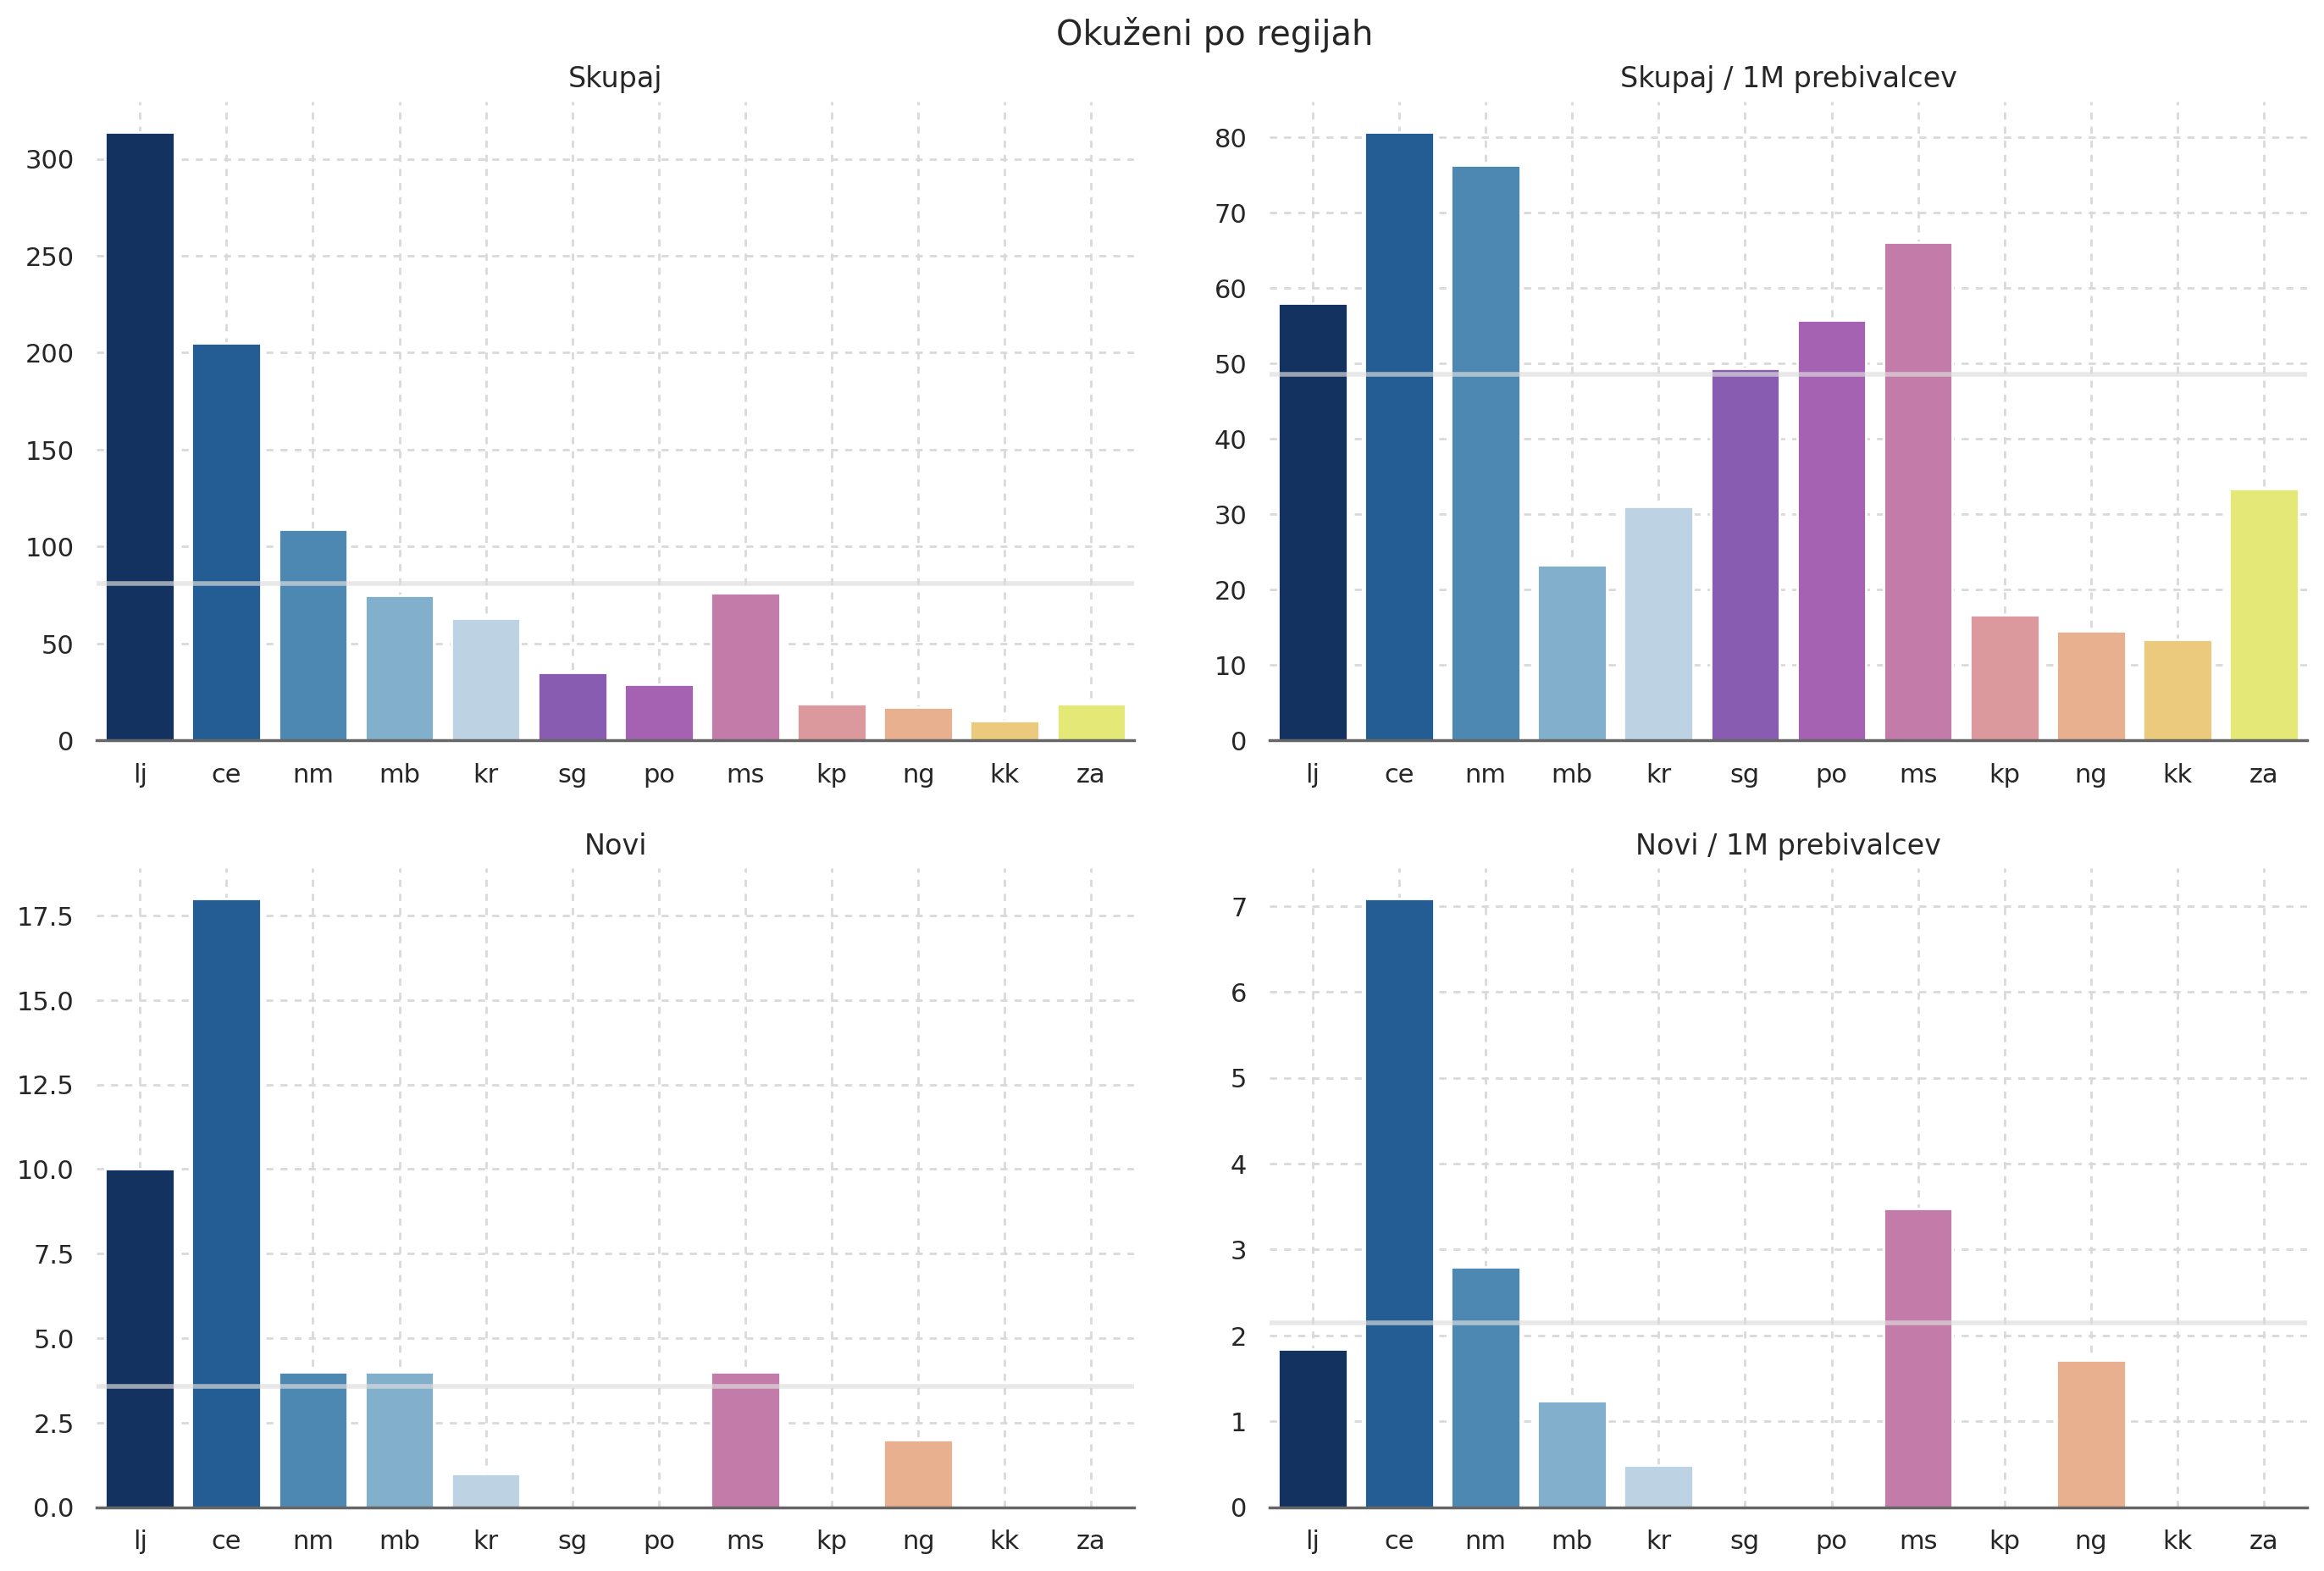

In [36]:
ind = 21

fig, ((ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex="all")
fig.suptitle("Okuženi po regijah", y=0.96)

dfp = df[4:]

sns.barplot(ax=ax5, data=dfp[regije][-1:], palette=cmap)
ax5.axhline(dfp[regije].sum(axis=1).to_numpy()[-1]/12, color="#ddda", linewidth=2, marker="")
utils_plot1(ax5, False, "Skupaj", None, None)

sns.barplot(ax=ax6, data=dfp[regije_popul][-1:], palette=cmap)
ax6.axhline(dfp[regije].sum(axis=1).to_numpy()[-1]/20, color="#ddda", linewidth=2, marker="")
utils_plot1(ax6, False, "Skupaj / 1M prebivalcev", None, None)

sns.barplot(ax=ax7, data=dfp[regije_novi][-1:], palette=cmap)
ax7.axhline(dfp[regije_novi].sum(axis=1).to_numpy()[-1]/12, color="#ddda", linewidth=2, marker="")
utils_plot1(ax7, False, "Novi", None, None)

sns.barplot(ax=ax8, data=dfp[regije_novi_popul][-1:], palette=cmap)
ax8.axhline(dfp[regije_novi].sum(axis=1).to_numpy()[-1]/20, color="#ddda", linewidth=2, marker="")
utils_plot1(ax8, False, "Novi / 1M prebivalcev", None, None)
ax8.set_xticklabels(regije)
plt.show()

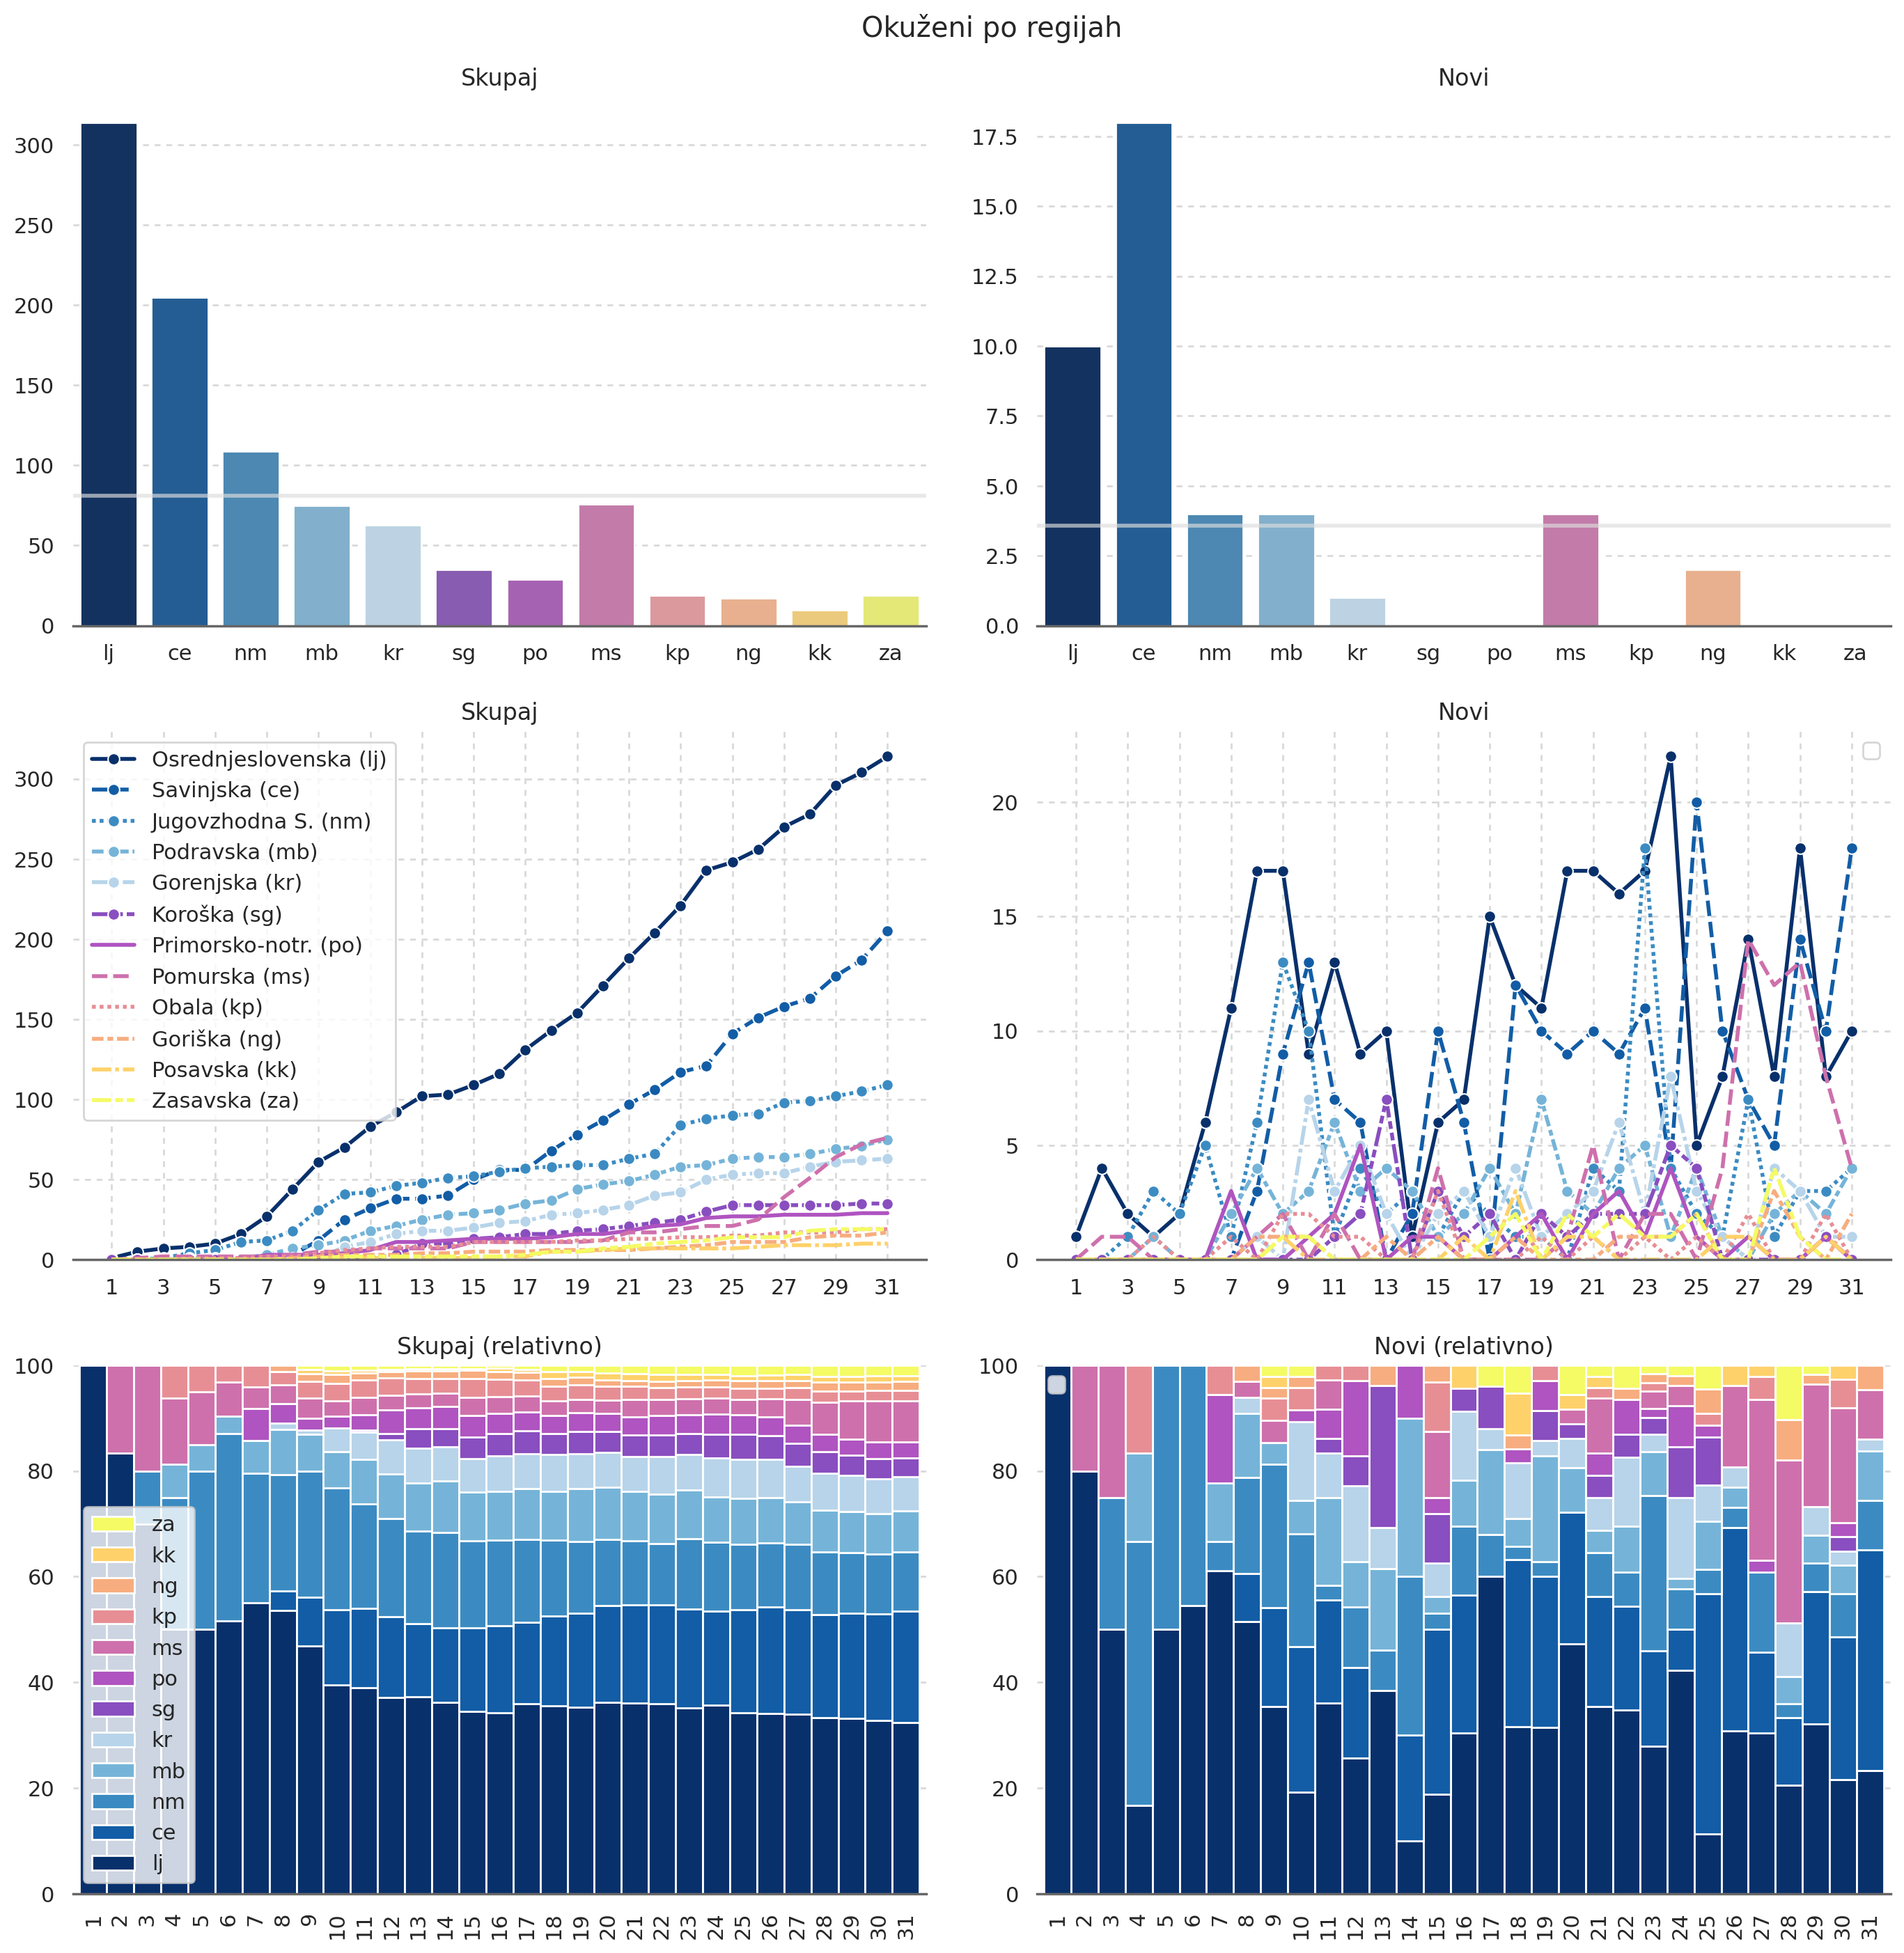

In [37]:
current_palette = sns.color_palette()
sns.set_palette(cmap)

fig, ((ax5, ax6), (ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle("Okuženi po regijah")

dfp = df[4:]

sns.barplot(ax=ax5, data=dfp[regije][-1:], palette=cmap)
ax5.axhline(dfp[regije].sum(axis=1).to_numpy()[-1]/12, color="#ddda", linewidth=2, marker="")
utils_plot1(ax5, False, "Skupaj", None, None)
ax5.set_xticklabels(regije)
ax5.grid(False, axis="x")

sns.barplot(ax=ax6, data=dfp[regije_novi][-1:], palette=cmap)
ax6.axhline(dfp[regije_novi].sum(axis=1).to_numpy()[-1]/12, color="#ddda", linewidth=2, marker="")
utils_plot1(ax6, False, "Novi", None, None)
ax6.set_xticklabels(regije)
ax6.grid(False, axis="x")


sns.lineplot(data=dfp[regije[:6]], ax=ax1)
sns.set_palette(cmap[6:,:])
sns.lineplot(data=dfp[regije[6:]], marker="", ax=ax1)

ax1.legend(regije_polno)
leg = ax1.get_legend()
for i, h in enumerate(leg.legendHandles):
    h.set_color(cmap[i]) 
utils_plot1(ax1, False, "Skupaj", None, dfp.index[::2])
sns.set_palette(cmap)


sns.lineplot(data=dfp[regije_novi[:6]], ax=ax2)
sns.set_palette(cmap[6:,:])
sns.lineplot(data=dfp[regije_novi[6:]], marker="", ax=ax2)
ax2.legend("")
utils_plot1(ax2, False, "Novi", None, dfp.index[::2])


dfp[regije_rel].plot(color=cmap, kind="bar", stacked=True, width=1, ylim=(0,100), ax=ax3)
reverse_legend(ax3, regije)
utils_plot1(ax3, False, "Skupaj (relativno)", None, None)

dfp[regije_novi_rel].plot(color=cmap, kind="bar", stacked=True, width=1, ylim=(0,100), ax=ax4)
ax4.legend("")
utils_plot1(ax4, False, "Novi (relativno)", None, None)

sns.set_palette(current_palette)
plt.subplots_adjust(top=0.94)
#plt.subplots_adjust(top=0.94, bottom=0.05)

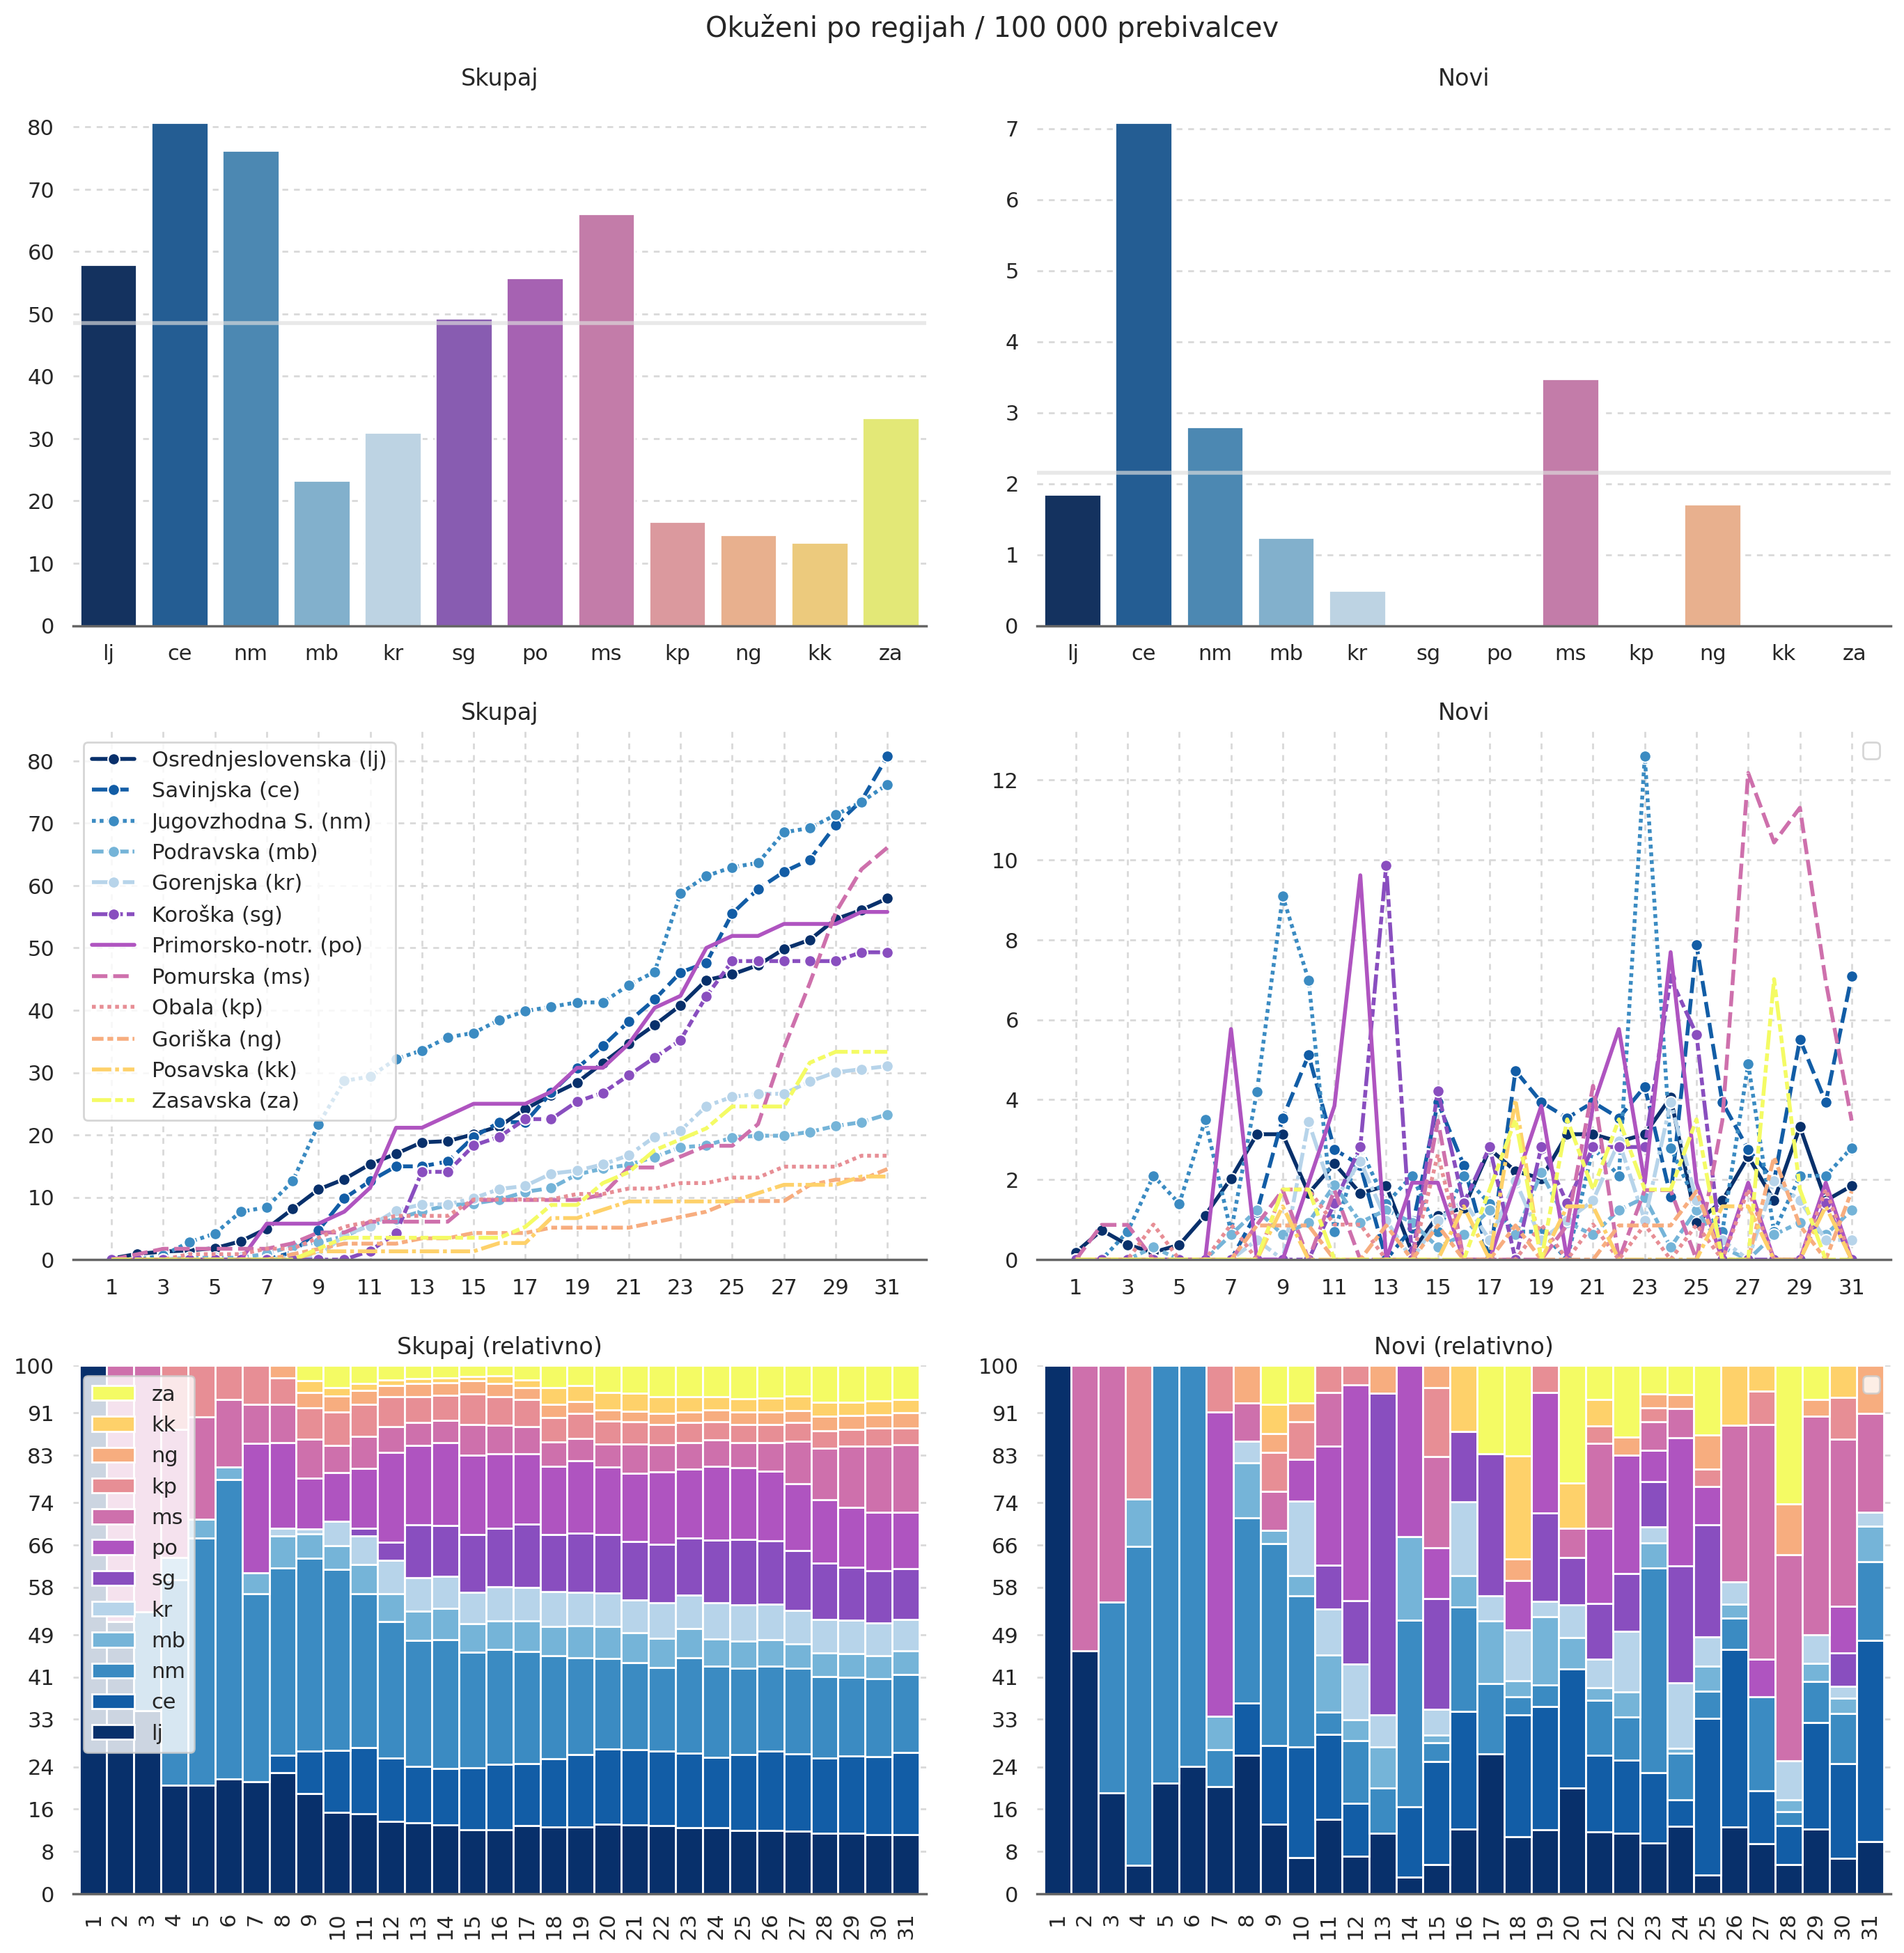

In [38]:
current_palette = sns.color_palette()
sns.set_palette(cmap)

fig, ((ax5, ax6),(ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle("Okuženi po regijah / 100 000 prebivalcev")

dfp = df[4:]

sns.barplot(ax=ax5, data=dfp[regije_popul][-1:], palette=cmap)
ax5.axhline(dfp[regije].sum(axis=1).to_numpy()[-1]/20, color="#ddda", linewidth=2, marker="")
utils_plot1(ax5, False, "Skupaj", None, None)
ax5.set_xticklabels(regije)
ax5.grid(False, axis="x")

sns.barplot(ax=ax6, data=dfp[regije_novi_popul][-1:], palette=cmap)
ax6.axhline(dfp[regije_novi].sum(axis=1).to_numpy()[-1]/20, color="#ddda", linewidth=2, marker="")
utils_plot1(ax6, False, "Novi", None, None)
ax6.set_xticklabels(regije)
ax6.grid(False, axis="x")


sns.lineplot(data=dfp[regije_popul[:6]], ax=ax1)
sns.set_palette(cmap[6:,:])
sns.lineplot(data=dfp[regije_popul[6:]], marker="", ax=ax1)
ax1.legend(regije_polno)
leg = ax1.get_legend()
for i, h in enumerate(leg.legendHandles):
    h.set_color(cmap[i]) 
sns.set_palette(cmap)
utils_plot1(ax1, False, "Skupaj", None, dfp.index[::2])

sns.lineplot(data=dfp[regije_novi_popul[:6]], ax=ax2)
sns.set_palette(cmap[6:,:])
sns.lineplot(data=dfp[regije_novi_popul[6:]], marker="", ax=ax2)
ax2.legend("")
utils_plot1(ax2, False, "Novi", None, dfp.index[::2])


dfp[regije_popul_rel].plot(color=cmap, kind="bar", stacked=True, width=1, ylim=(0,100), ax=ax3)
reverse_legend(ax3, regije)
utils_plot1(ax3, False, "Skupaj (relativno)", None, None)
ax3.set_yticks([int(i/10) for i in range(0, 950, 83)] + [100])

dfp[regije_novi_popul_rel].plot(color=cmap, kind="bar", stacked=True, width=1, ylim=(0,100), ax=ax4)
ax4.legend("")
utils_plot1(ax4, False, "Novi (relativno)", None, None)
ax4.set_yticks([int(i/10) for i in range(0, 950, 83)] + [100])

sns.set_palette(current_palette)
plt.subplots_adjust(top=0.94)
#plt.subplots_adjust(top=0.94, bottom=0.05)

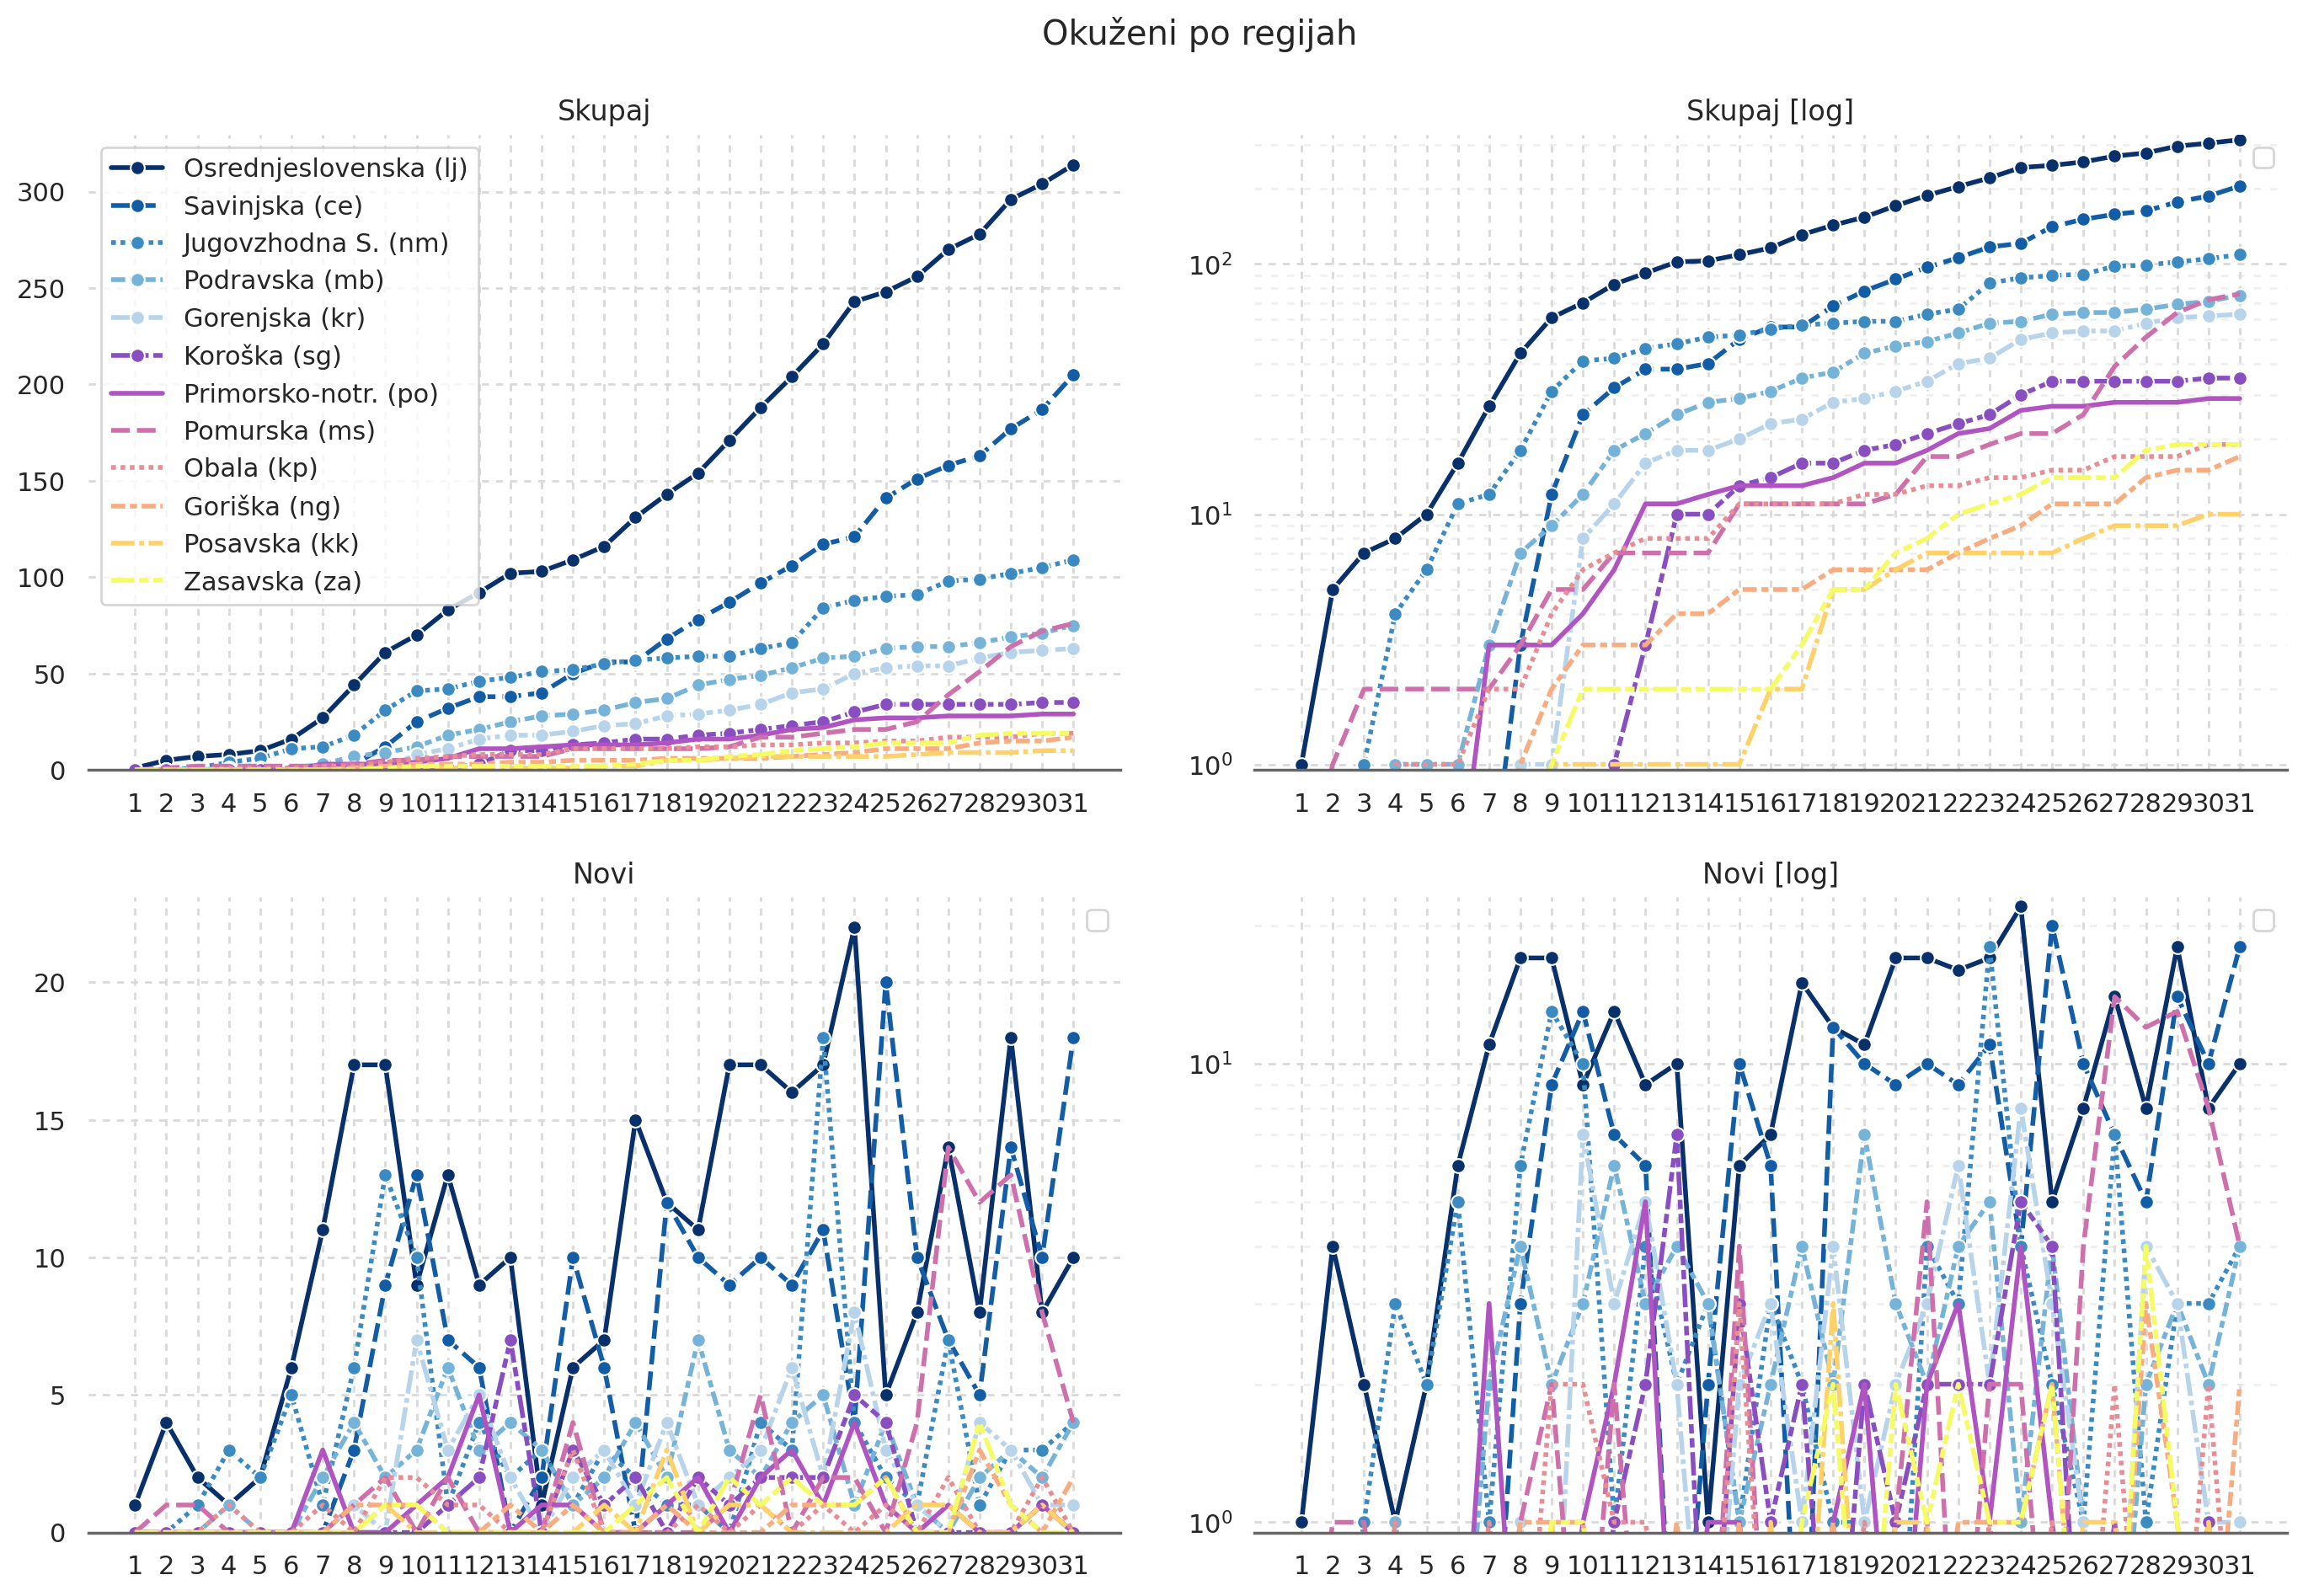

In [39]:
current_palette = sns.color_palette()
sns.set_palette(cmap)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex="all")
fig.suptitle("Okuženi po regijah")

dfp = df[4:]

sns.lineplot(data=dfp[regije[:6]], ax=ax1)
sns.set_palette(cmap[6:,:])
sns.lineplot(data=dfp[regije[6:]], marker="", ax=ax1)

ax1.legend(regije_polno)
leg = ax1.get_legend()
for i, h in enumerate(leg.legendHandles):
    h.set_color(cmap[i]) 
utils_plot1(ax1, False, "Skupaj", None, dfp.index)
sns.set_palette(cmap)


sns.lineplot(data=dfp[regije[:6]].replace(0, 0.3), ax=ax2)
sns.set_palette(cmap[6:,:])
sns.lineplot(data=dfp[regije[6:]].replace(0, 0.3), marker="", ax=ax2)

ax2.legend("")
utils_plot1(ax2, True, "Skupaj", None, dfp.index)
sns.set_palette(cmap)

sns.lineplot(data=dfp[regije_novi[:6]], ax=ax3)
sns.set_palette(cmap[6:,:])
sns.lineplot(data=dfp[regije_novi[6:]], marker="", ax=ax3)
ax3.legend("")
utils_plot1(ax3, False, "Novi", None, dfp.index)

sns.set_palette(cmap)
sns.lineplot(data=dfp[regije_novi[:6]].replace(0, 0.3), ax=ax4)
sns.set_palette(cmap[6:,:])
sns.lineplot(data=dfp[regije_novi[6:]].replace(0, 0.3), marker="", ax=ax4)
ax4.legend("")
utils_plot1(ax4, True, "Novi", None, dfp.index)
sns.set_palette(current_palette)

### Starost

In [40]:
starosti_populacija = np.array([1., 2.11, 1.95, 2.53, 3.15, 3.01, 2.95, 2.22, 1.39, 0.52])

starosti5 = ["0-15", "16-29", "30-49", "50-59", "60+"]
starosti10 = [str(i*10) for i in range(0, 10)]
#starosti = cat((starosti5, starosti10))
starosti = starosti10

starosti_rel = [r + "_rel" for r in starosti]
starosti_popul = [r + "_popul" for r in starosti10]

starosti5_novi = [r + "_novi" for r in starosti5]
starosti10_novi = [r + "_novi" for r in starosti10]
#starosti_novi = cat((starosti5_novi, starosti10_novi))
starosti_novi = starosti10_novi

starosti_novi_popul = [r + "_novi_popul" for r in starosti10]
starosti_novi_rel = [r + "_rel" for r in starosti_novi]

df[starosti_rel] = df[starosti].div(df[starosti].sum(axis=1), axis=0)*100
df[starosti_popul] = df[starosti10]/starosti_populacija

df[starosti_novi] = df[starosti].diff()
df[starosti_novi_rel] = df[starosti_novi].div(df[starosti_novi].sum(axis=1), axis=0)*100
#df[starosti_novi_popul] = df[starosti_novi[5:]]/starosti_populacija
df[starosti_novi_popul] = df[starosti_novi]/starosti_populacija

#za odstanitev dso
#df[starosti_rel] = df[starosti].div(df[starosti].sum(axis=1) - dfp["p_oku_dso"], axis=0)*100
#df[starosti_novi_rel] = df[starosti_novi].div(df[starosti_novi].sum(axis=1) - dfp["p_oku_dso_novi"], axis=0)*100

In [41]:
starosti10_skupine = ["0-24", "25-34", "35-54", "55-64", "65+"]

df["0-24"] = df["0"] + df["10"] + df["20"]
df["25-34"] = df["30"]
df["35-54"] = df["50"] + df["40"]
df["55-64"] = df["60"]
df["65+"] = df["70"] + df["80"] + df["90"]

starosti10_skupine_novi = [r + "_novi" for r in starosti10_skupine]
df[starosti10_skupine_novi] = df[starosti10_skupine].diff()

In [42]:
avg_box = np.array([10, 22, 40, 55, 70])
avg_box1 = (np.array([5, 16, 30, 50, 60]) + avg_box)/2
avg_box2 = (np.array([15, 29, 49, 59, 90]) + avg_box)/2

avg_box10 = np.array([10*i for i in range(0, 10)])
avg_box110 = np.array([0] + [10*i - 3 for i in range(1, 10)])
avg_box210 = np.array([10*i + 3 for i in range(0, 9)] + [95])

avg_starost = (df[starosti] * avg_box10).sum(axis=1).div(df[starosti].sum(axis=1), axis=0)
avg_starost1 = (df[starosti] * avg_box110).sum(axis=1).div(df[starosti].sum(axis=1), axis=0)
avg_starost2 = (df[starosti] * avg_box210).sum(axis=1).div(df[starosti].sum(axis=1), axis=0)
novi_avg_starost = (df[starosti_novi] * avg_box10).sum(axis=1).div(df[starosti_novi].sum(axis=1), axis=0)
novi_avg_starost1 = (df[starosti_novi] * avg_box110).sum(axis=1).div(df[starosti_novi].sum(axis=1), axis=0)
novi_avg_starost2 = (df[starosti_novi] * avg_box210).sum(axis=1).div(df[starosti_novi].sum(axis=1), axis=0)

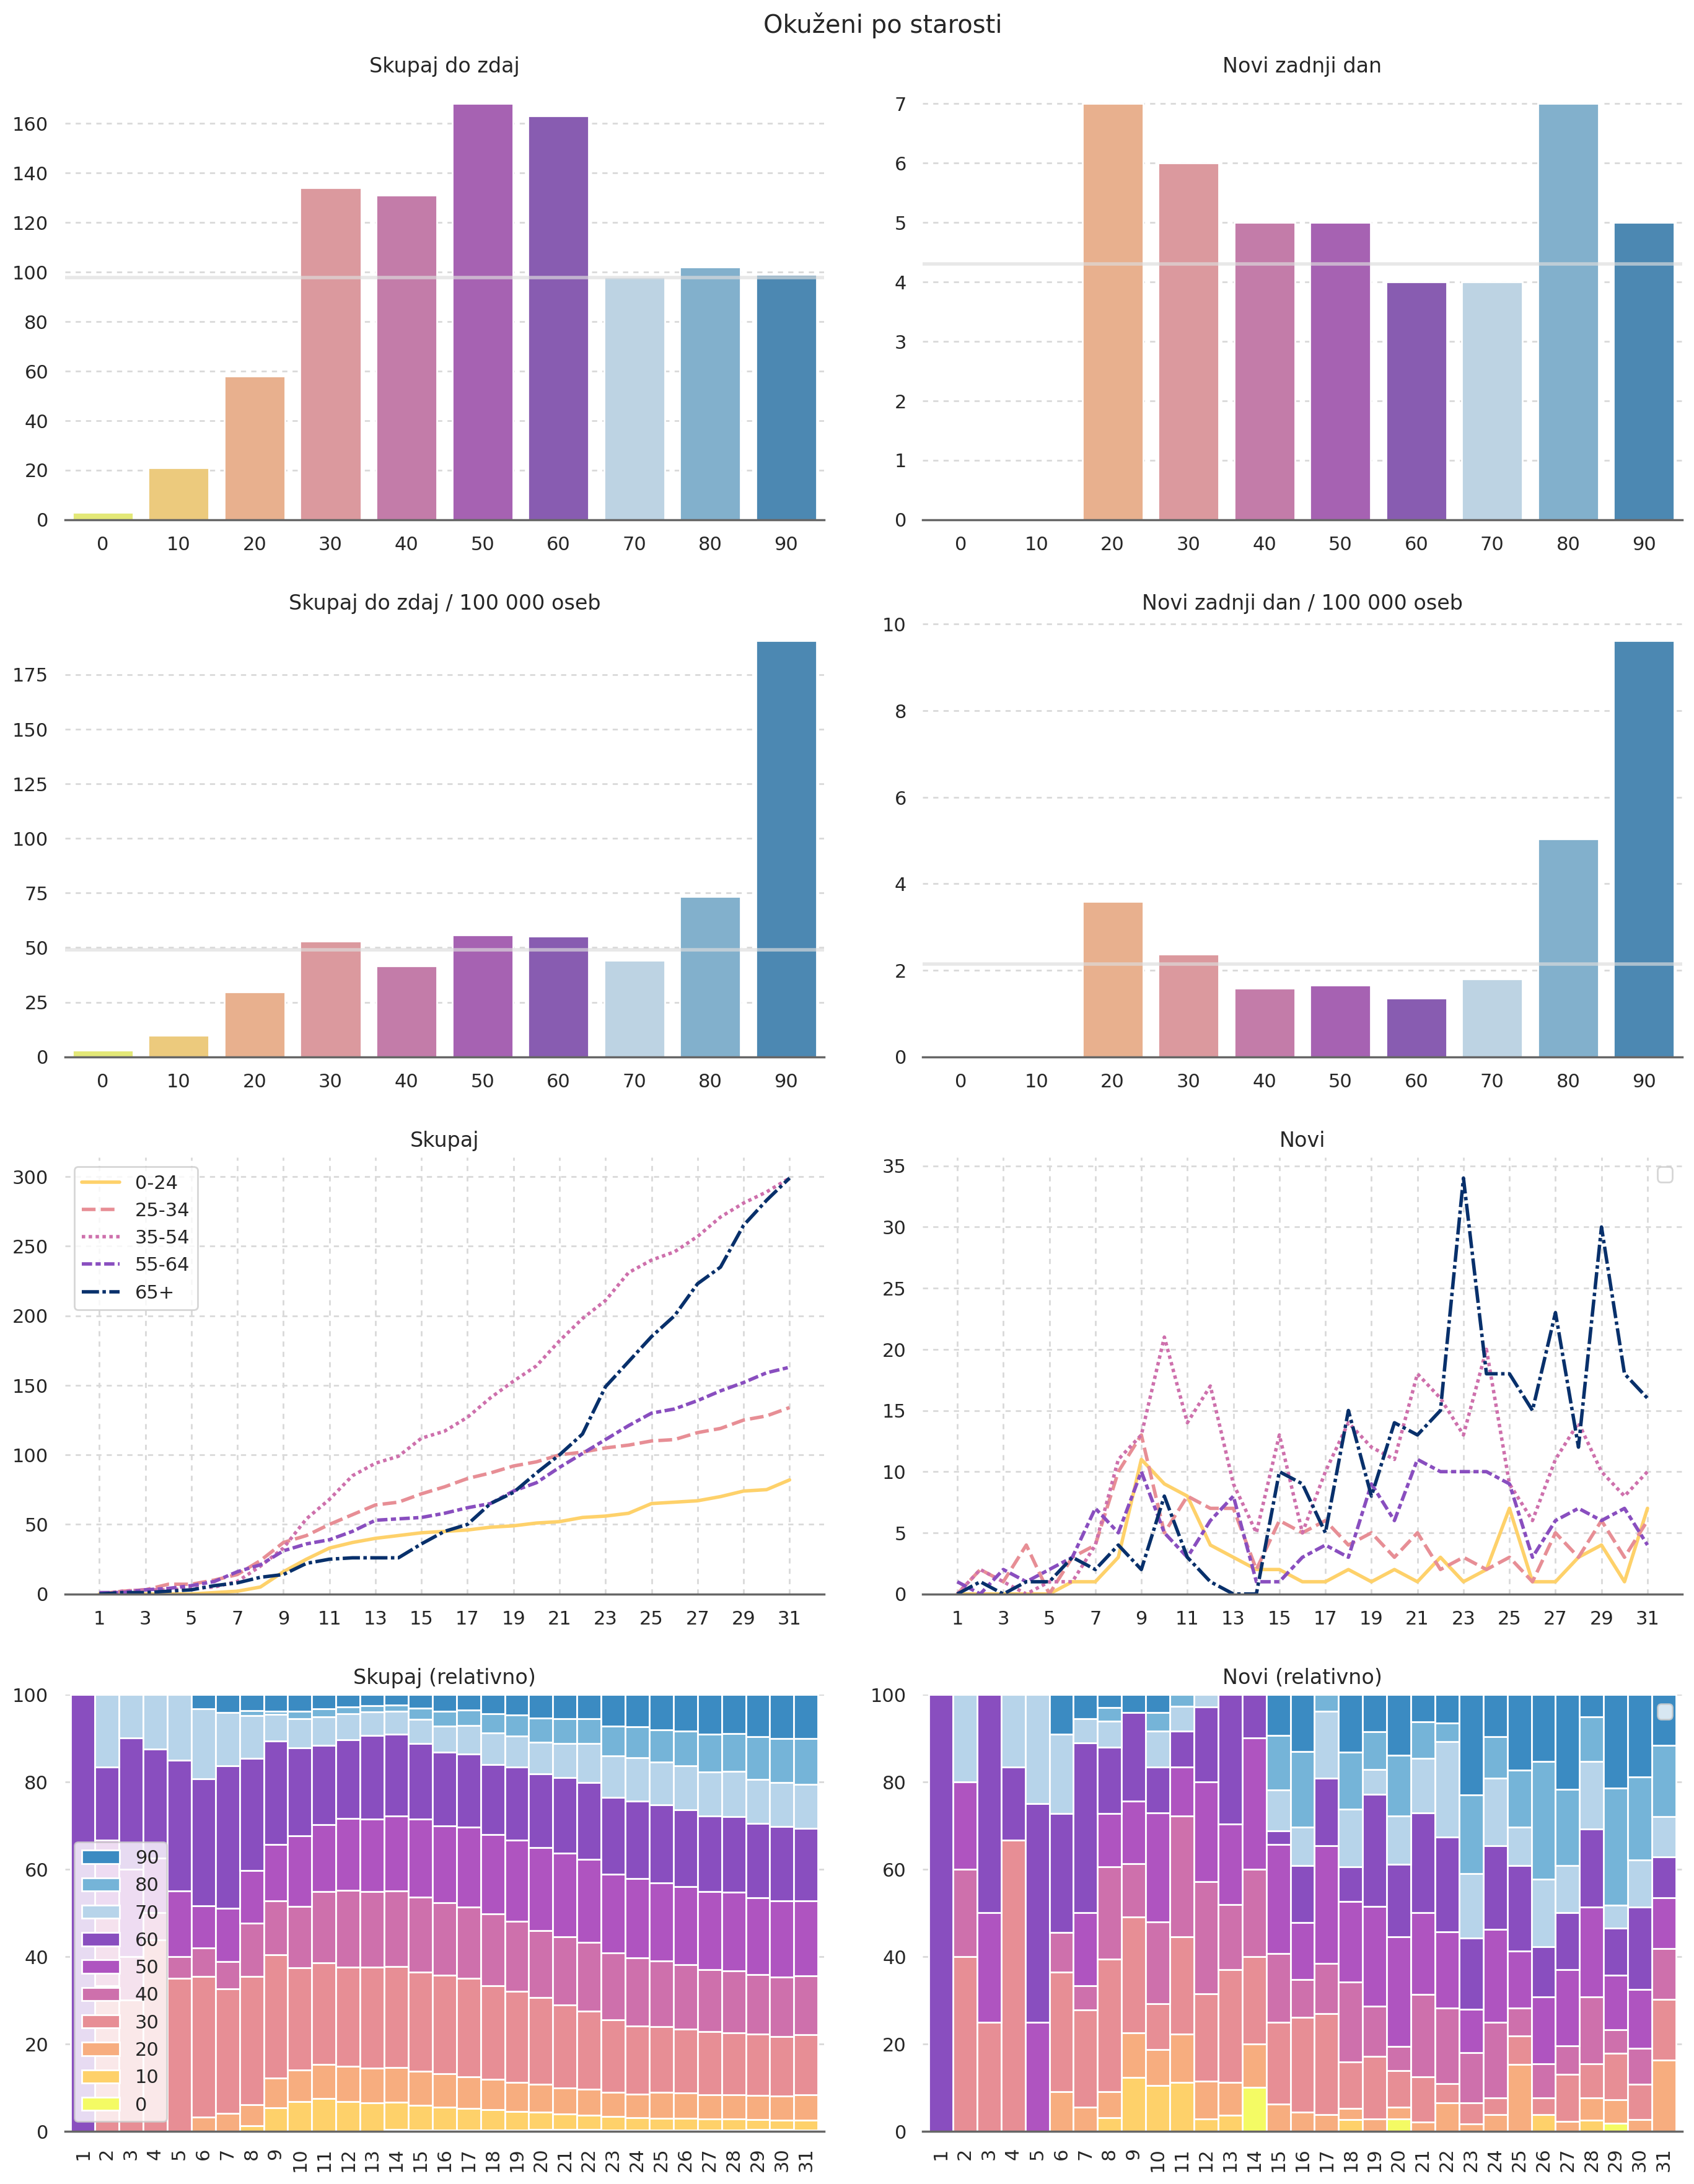

In [43]:
current_palette = sns.color_palette()
sns.set_palette(blues_dd)
fig, ((ax5, ax7), (ax6, ax8), (ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=4, ncols=2, figsize=(15, 19))
fig.suptitle("Okuženi po starosti")


dfp = df[4:]

#sns.barplot(ax=ax5, data=dfp[starosti[5:]][-1:], palette=cmap[::-1])
sns.barplot(ax=ax5, data=dfp[starosti][-1:], palette=cmap[::-1])
ax5.axhline(dfp[starosti].sum(axis=1).to_numpy()[-1]/10, color="#ddda", linewidth=2, marker="")
utils_plot1(ax5, False, "Skupaj do zdaj", None, None)
ax5.set_xticklabels(starosti10)
ax5.grid(False, axis="x")

sns.barplot(ax=ax6, data=dfp[starosti_popul][-1:], palette=cmap[::-1])
ax6.axhline(dfp[starosti].sum(axis=1).to_numpy()[-1]/20, color="#ddda", linewidth=2, marker="")
utils_plot1(ax6, False, "Skupaj do zdaj / 100 000 oseb", None, None)
ax6.set_xticklabels(starosti10)
ax6.grid(False, axis="x")

#sns.barplot(ax=ax7, data=dfp[starosti_novi[5:]][-1:], palette=cmap[::-1])
sns.barplot(ax=ax7, data=dfp[starosti_novi][-1:], palette=cmap[::-1])
ax7.axhline(dfp[starosti_novi].sum(axis=1).to_numpy()[-1]/10, color="#ddda", linewidth=2, marker="")
utils_plot1(ax7, False, "Novi zadnji dan", None, None)
ax7.set_xticklabels(starosti10)
ax7.grid(False, axis="x")

sns.barplot(ax=ax8, data=dfp[starosti_novi_popul][-1:], palette=cmap[::-1])
ax8.axhline(dfp[starosti_novi].sum(axis=1).to_numpy()[-1]/20, color="#ddda", linewidth=2, marker="")
utils_plot1(ax8, False, "Novi zadnji dan / 100 000 oseb", None, None)
ax8.set_xticklabels(starosti10)
ax8.grid(False, axis="x")


cmapr = cmap[::-1]
cmapr2 = np.stack((cmapr[1,:], cmapr[3,:], cmapr[4,:], cmapr[6,:], cmapr[-1,:]))

sns.set_palette(cmapr2)
sns.lineplot(data=dfp[starosti10_skupine[:5]], ax=ax1, marker="")
#ax1.legend(starosti5 + starosti10_skupine)
ax1.legend(starosti10_skupine)
leg = ax1.get_legend()
for i, h in enumerate(leg.legendHandles[5:]):
    h.set_color(cmapr2[i]) 
utils_plot1(ax1, False, "Skupaj", None, dfp.index[::2])

#sns.set_palette(blues_dd)
#sns.lineplot(data=dfp[starosti5_novi], ax=ax2)
sns.set_palette(cmapr2)
sns.lineplot(data=dfp[starosti10_skupine_novi], ax=ax2, marker="")
ax2.legend("")
utils_plot1(ax2, False, "Novi", None, dfp.index[::2])



#dfp[starosti_rel[:5]].plot(ax=ax3, kind="bar", stacked=True, width=1, color=blues_d)
#dfp[starosti_rel[5:]].plot(ax=ax3, kind="bar", stacked=True, width=1, color=cmapr)
dfp[starosti_rel].plot(ax=ax3, kind="bar", stacked=True, width=1, color=cmapr)
utils_plot1(ax3, False, "Skupaj (relativno)", (0, 100), None)
ax3.legend("", loc="center left")
sns.set_palette(cmapr)
reverse_legend(ax3, starosti)

#dfp[starosti_novi_rel[:5]].plot(ax=ax4, kind="bar", stacked=True, width=1, color=blues_d)
#dfp[starosti_novi_rel[5:]].plot(ax=ax4, kind="bar", stacked=True, width=1, color=cmapr)
dfp[starosti_novi_rel].plot(ax=ax4, kind="bar", stacked=True, width=1, color=cmapr)
ax4.legend("")

utils_plot1(ax4, False, "Novi (relativno)", (0, 100), None)

sns.set_palette(current_palette)
plt.subplots_adjust(top=0.95, hspace=.23)
#plt.subplots_adjust(top=0.95, hspace=.23, bottom=.05)

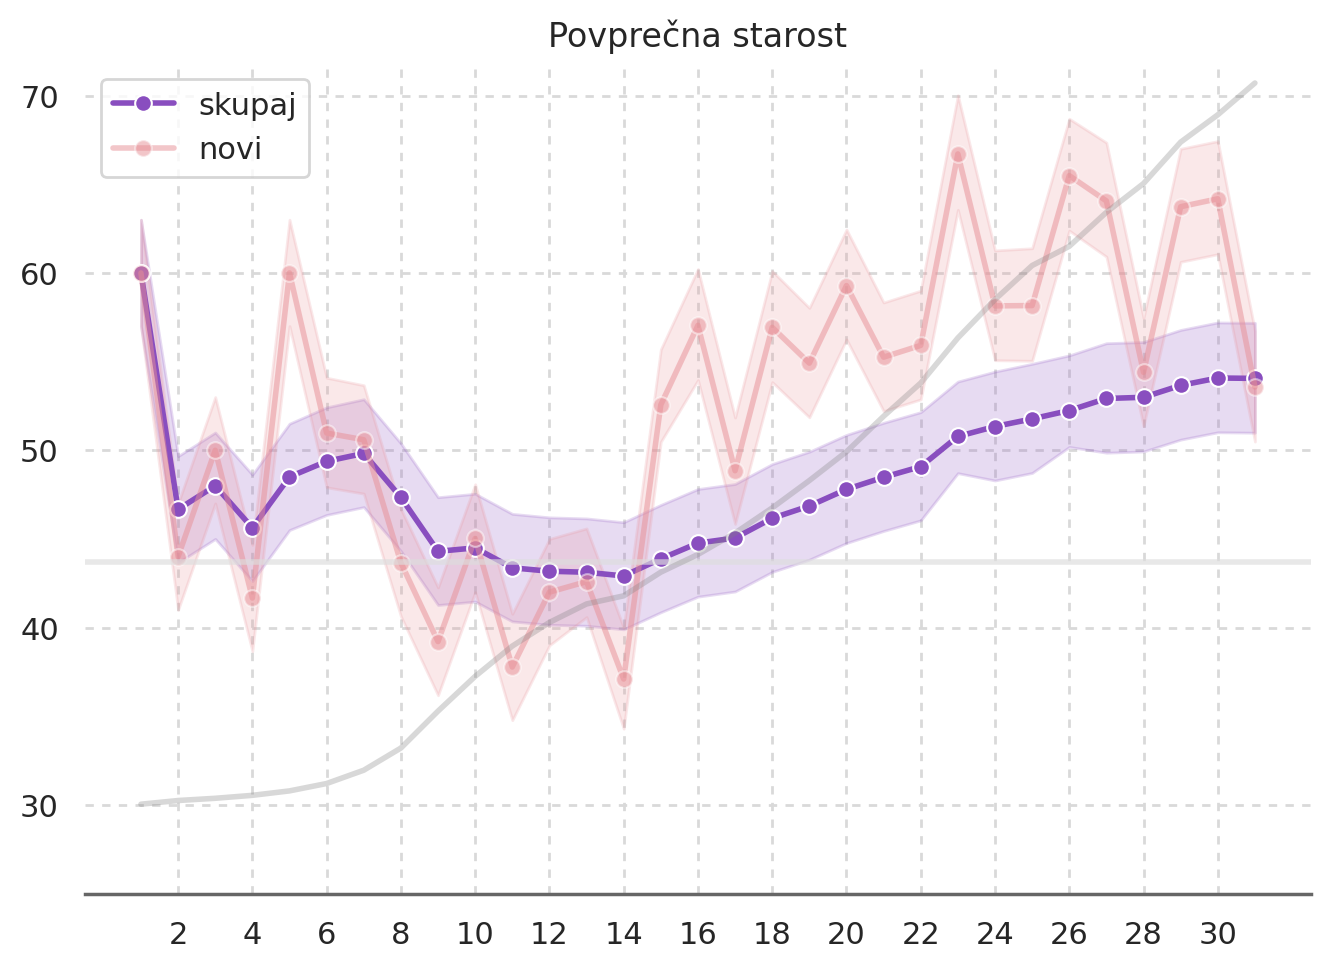

In [44]:
fig, (ax7, ax8) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)
sns.lineplot(data=[avg_starost,avg_starost1, avg_starost2], err_style="band", ax=ax7, color=cmap[5])
sns.lineplot(data=[novi_avg_starost,novi_avg_starost1, novi_avg_starost2], err_style="band", ax=ax7, color=cmap[8], alpha=.5)
#sns.lineplot(ax=ax7, x=cat((dni10, dni10, dni10)), y=cat([avg_starost10.to_numpy(),avg_starost110.to_numpy(),avg_starost210.to_numpy()]), color="b", err_style="bars")
ax7.legend(["skupaj", "novi"], loc="upper left")
utils_plot1(ax7, False, "Povprečna starost", 25, avg_starost.index[5::2])
ax7.axhline(43.7, color="#ddda", linewidth=2, marker="")
ax7.plot(dfp["oku_24h"]/24+30, alpha=.3, color="grey", marker="")

ax8.remove()

# Napovedi

http://rocs.hu-berlin.de/corona/docs/forecast/model/

In [45]:
def sir(s, i, r, dt, alpha, beta):
    s1 = s + (-alpha * s * i) * dt
    i1 = i + (alpha * s * i - beta * i) * dt
    r1 = r + (beta * i) * dt
    
    return s1, i1, r1

In [46]:
def sirx(s, i, r, x, dt, alpha, beta, k, k0):
    s1 = s + (-alpha * s * i - k0 * s) * dt
    i1 = i + (alpha * s * i - beta * i - k0 * i - k * i) * dt
    x1 = x + ((k0 + k) * i) * dt
    r1 = r + (k0 * s + beta * i) * dt
    
    return s1, i1, r1, x1

---

In [47]:
def weighted(arr):
    #return arr
    return np.concatenate((arr, arr[-10:], arr[-5:]))

In [48]:
dfa = df[["oku_24h", "oku_novi_24h"]][3:].rename(columns={"oku_24h": "skupaj", "oku_novi_24h": "novi"})
#dfa = df[["p_oku_brezdso", "p_oku_brezdso_novi"]][5:].rename(columns={"p_oku_brezdso": "skupaj", "p_oku_brezdso_novi": "novi"})

In [49]:
ind = np.arange(0, dfa.index[-1]+1, 1)
c = dfa["skupaj"].to_numpy()[ind] / 2_000_000
dc = dfa["novi"].to_numpy()[ind] / 2_000_000
t = dfa.index.to_numpy()[ind]

t1 = weighted(t)
c1 = weighted(c)

In [58]:
def fun(p, ts, ys=None, w=True):
    train = ys is not None
    
    s, i, r, x = 1, p[0], 0, 0
    alpha = 1.1666
    beta = 0.38
    k0 = p[1]
    k = p[2]

    dt = 0.1
    
    xx = []
    xxd = []
    
    ii = []
    
    for j in range(int(len(ts) / dt)):
        s, i, r, x = sirx(s, i, r, x, dt, alpha, beta, k, k0)

        if j*dt in ts:
            xx.append(x)
            ii.append(i)
            if len(xxd) == 0:
                xxd.append(x)
            else:
                xxd.append(xx[-1] - xx[-2])
    xx = np.array(xx)
    
    if train:
        if w:
            xx = weighted(xx)
        return xx - ys
    else:
        xxd = np.array(xxd)
        return xx, xxd, ii

In [59]:
p0 = np.array([1e-06, 0.001, 0.001])
res = scipy.optimize.least_squares(fun, p0, args=(t1, c1), method="lm")

In [60]:
res.x

array([5.87232864e-06, 5.71878467e-03, 6.29270151e-01])

In [61]:
p = res.x.copy()

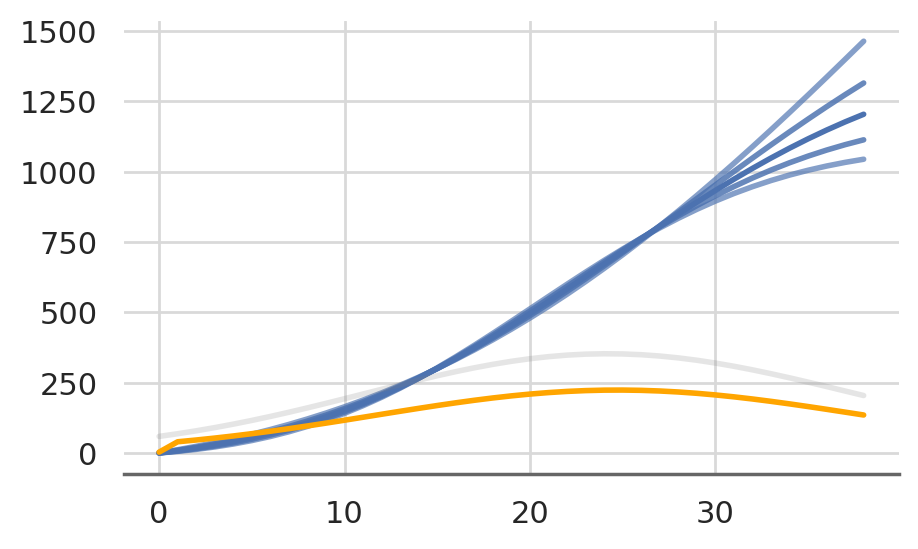

In [62]:
t_e = np.concatenate((t, [t[-1] + 1]))
t_e1 = weighted(t_e)

x, dx, _ = fun(p, t_e)
p_e = []
x_e = []
dx_e = []


tt =  np.arange(0, t[-1]+1 + 7, 1)

plt.figure(figsize=(5,3))
for e in [.84, .92, 1.08, 1.16]: #[.63, .84, 1.16, 1.44]:
    c_e = np.concatenate((c, x[-1:]*e))
    c_e1 = weighted(c_e)
    res1 = scipy.optimize.least_squares(fun, p, args=(t_e1, c_e1), method="lm")
    p1 = res1.x.copy()
    p_e.append(p1)
    
    x1, dx1, _ = fun(p1, tt)
    x_e.append(x1)
    dx_e.append(dx1)
    sns.lineplot(tt, x1*2_000_000, color="b", marker="", alpha=1-2*abs(1-e))

x, dx, ii = fun(p, tt)
sns.lineplot(tt, x*2_000_000, color="b", marker="", alpha=1)
sns.lineplot(tt, 5*np.array(ii)*2_000_000, marker="", color="grey", alpha=.2)
sns.lineplot(tt, 5*dx*2_000_000, marker="", color="orange")
plt.show()

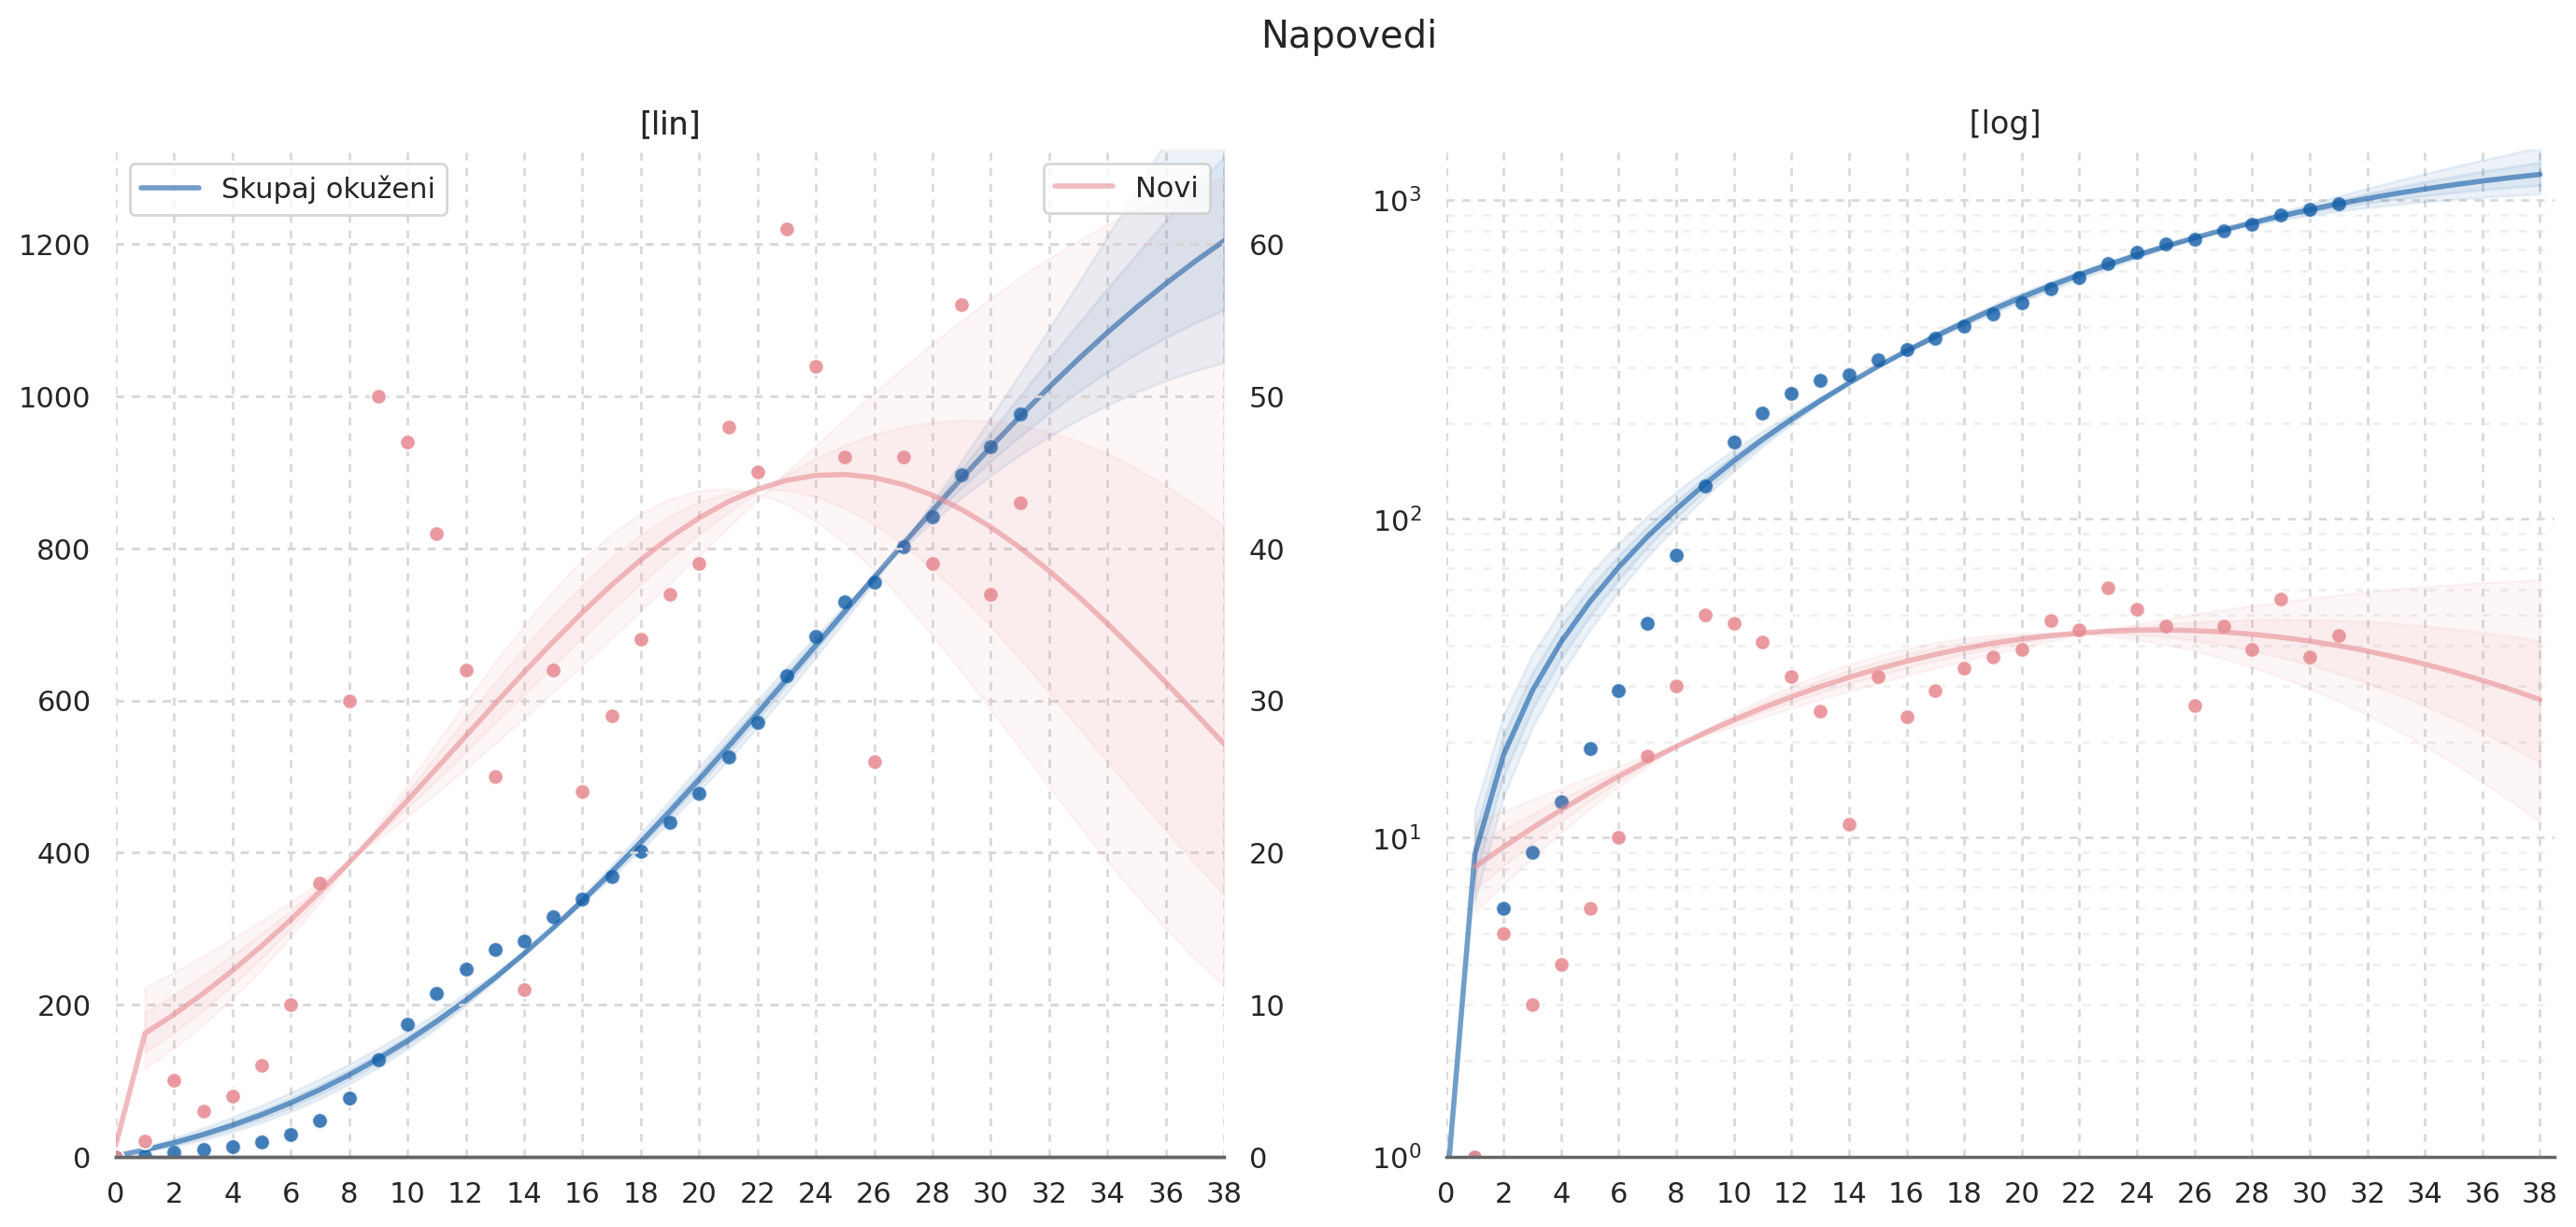

In [63]:
fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.suptitle("Napovedi")

c1 = cmap[1]
c2 = cmap[8]

sns.lineplot(tt, x*2_000_000, color=c1, marker="", alpha=.6, ax=ax1)
sns.lineplot(tt[1:], dx[1:]*2_000_000, color=c2, marker="", alpha=.6, ax=ax1)
sns.scatterplot(t, c*2_000_000, color=c1, alpha=.8, ax=ax1)
sns.scatterplot(t, dc*2_000_000, color=c2, alpha=.9, ax=ax1)

st = -tt[-1]
ax1.fill_between(tt[st:], x_e[1][st:]*2_000_000, x_e[2][st:]*2_000_000, color=c1, alpha=.08)
ax1.fill_between(tt[st:], x_e[0][st:]*2_000_000, x_e[3][st:]*2_000_000, color=c1, alpha=.08)
ax1.fill_between(tt[st:], dx_e[1][st:]*2_000_000, dx_e[2][st:]*2_000_000, color=c2, alpha=.08)
ax1.fill_between(tt[st:], dx_e[0][st:]*2_000_000, dx_e[3][st:]*2_000_000, color=c2, alpha=.08)

utils_plot1(ax1, True, "", (1, 1.2*x[-1]*2_000_000), tt[::2])
ax1.set_xlim(0, tt[-1]+.5)


ax2s = ax2.twinx()
sns.lineplot(tt, x*2_000_000, color=c1, marker="", alpha=.6, ax=ax2)
sns.scatterplot(t, c*2_000_000, color=c1, alpha=.8, ax=ax2)
sns.lineplot(tt, dx*2_000_000, color=c2, marker="", alpha=.6, ax=ax2s)
sns.scatterplot(t, dc*2_000_000, color=c2, alpha=.9, ax=ax2s)

ax2.fill_between(tt[st:], x_e[1][st:]*2_000_000, x_e[2][st:]*2_000_000, color=c1, alpha=.08)
ax2.fill_between(tt[st:], x_e[0][st:]*2_000_000, x_e[3][st:]*2_000_000, color=c1, alpha=.08)
ax2s.fill_between(tt[st:], dx_e[1][st:]*2_000_000, dx_e[2][st:]*2_000_000, color=c2, alpha=.08)
ax2s.fill_between(tt[st:], dx_e[0][st:]*2_000_000, dx_e[3][st:]*2_000_000, color=c2, alpha=.08)
ax2.legend(["Skupaj okuženi"], loc="upper left")
ax2s.legend(["Novi"])

utils_plot1(ax2s, False, "[lin]", (0, 1.1*x[-1]*2_000_000/20), tt[::2])
utils_plot1(ax2, False, "[lin]", (0, 1.1*x[-1]*2_000_000), tt[::2])
ax2.set_xlim(0, tt[-1])

plt.subplots_adjust(top=0.88, bottom=.11, wspace=.2)
#plt.savefig("./aa.png", dpi=200)
plt.show()

---

# Razno

(400.0, 28448.8)

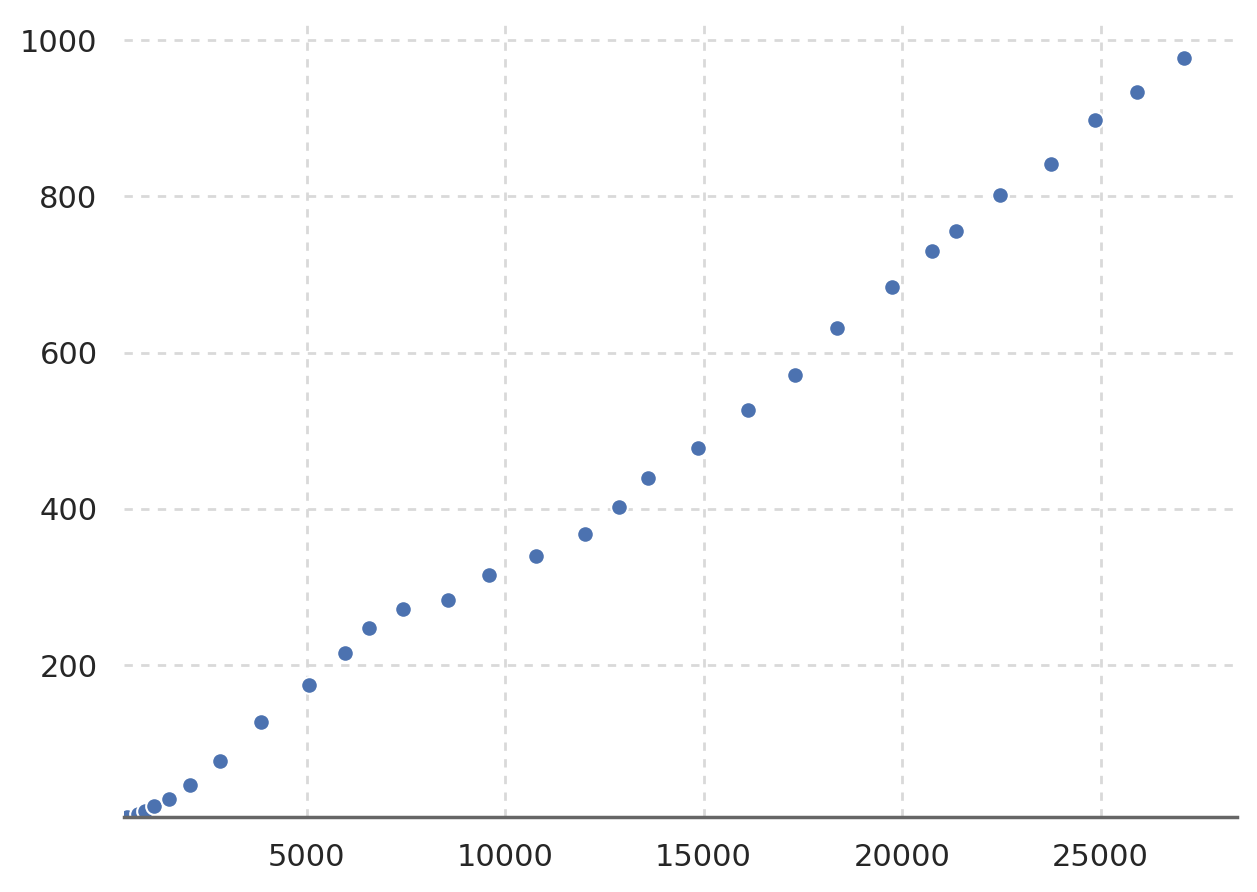

In [64]:
ax = sns.scatterplot(data=df, x="testi_24h", y="oku_24h")
utils_plot1(ax, False, "", 1, None)
#plt.yscale("log")
#plt.xscale("log")
plt.ylim(6)
plt.xlim(400)

## Specifične skupine

In [65]:
df["p_oku_zdravstvo1"] = df["p_oku_zdravstvo"] - df["p_oku_dsoz"]

df["p_oku_dso_novi"] = df.p_oku_dso.diff()
df["p_oku_dsoz_novi"] = df.p_oku_dsoz.diff()
df["p_oku_zdravstvo_novi"] = df.p_oku_zdravstvo.diff()
df["p_oku_zdravstvo1_novi"] = df.p_oku_zdravstvo1.diff()
df["hospitalizirani_neur_novi"] = df.hospitalizirani_neur_skupaj.diff()

df["p_oku_dso_novi_rel"] = df["p_oku_dso_novi"]/df["oku_novi_24h"]
df["p_oku_dsoz_novi_rel"] = df["p_oku_dsoz_novi"]/df["oku_novi_24h"]
df["p_oku_zdravstvo_novi_rel"] = df["p_oku_zdravstvo_novi"]/df["oku_novi_24h"]
df["p_oku_zdravstvo1_novi_rel"] = df["p_oku_zdravstvo1_novi"]/df["oku_novi_24h"]
df["hospitalizirani_neur_novi_rel"] = df["hospitalizirani_neur_novi"]/df["oku_novi_24h"]

df["p_oku_dso_rel"] = df["p_oku_dso"]/df["oku_24h"]
df["p_oku_dsoz_rel"] = df["p_oku_dsoz"]/df["oku_24h"]
df["p_oku_zdravstvo_rel"] = df["p_oku_zdravstvo"]/df["oku_24h"]
df["p_oku_zdravstvo1_rel"] = df["p_oku_zdravstvo1"]/df["oku_24h"]

/home/tim/.local/lib/python3.6/site-packages/seaborn/relational.py:361: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


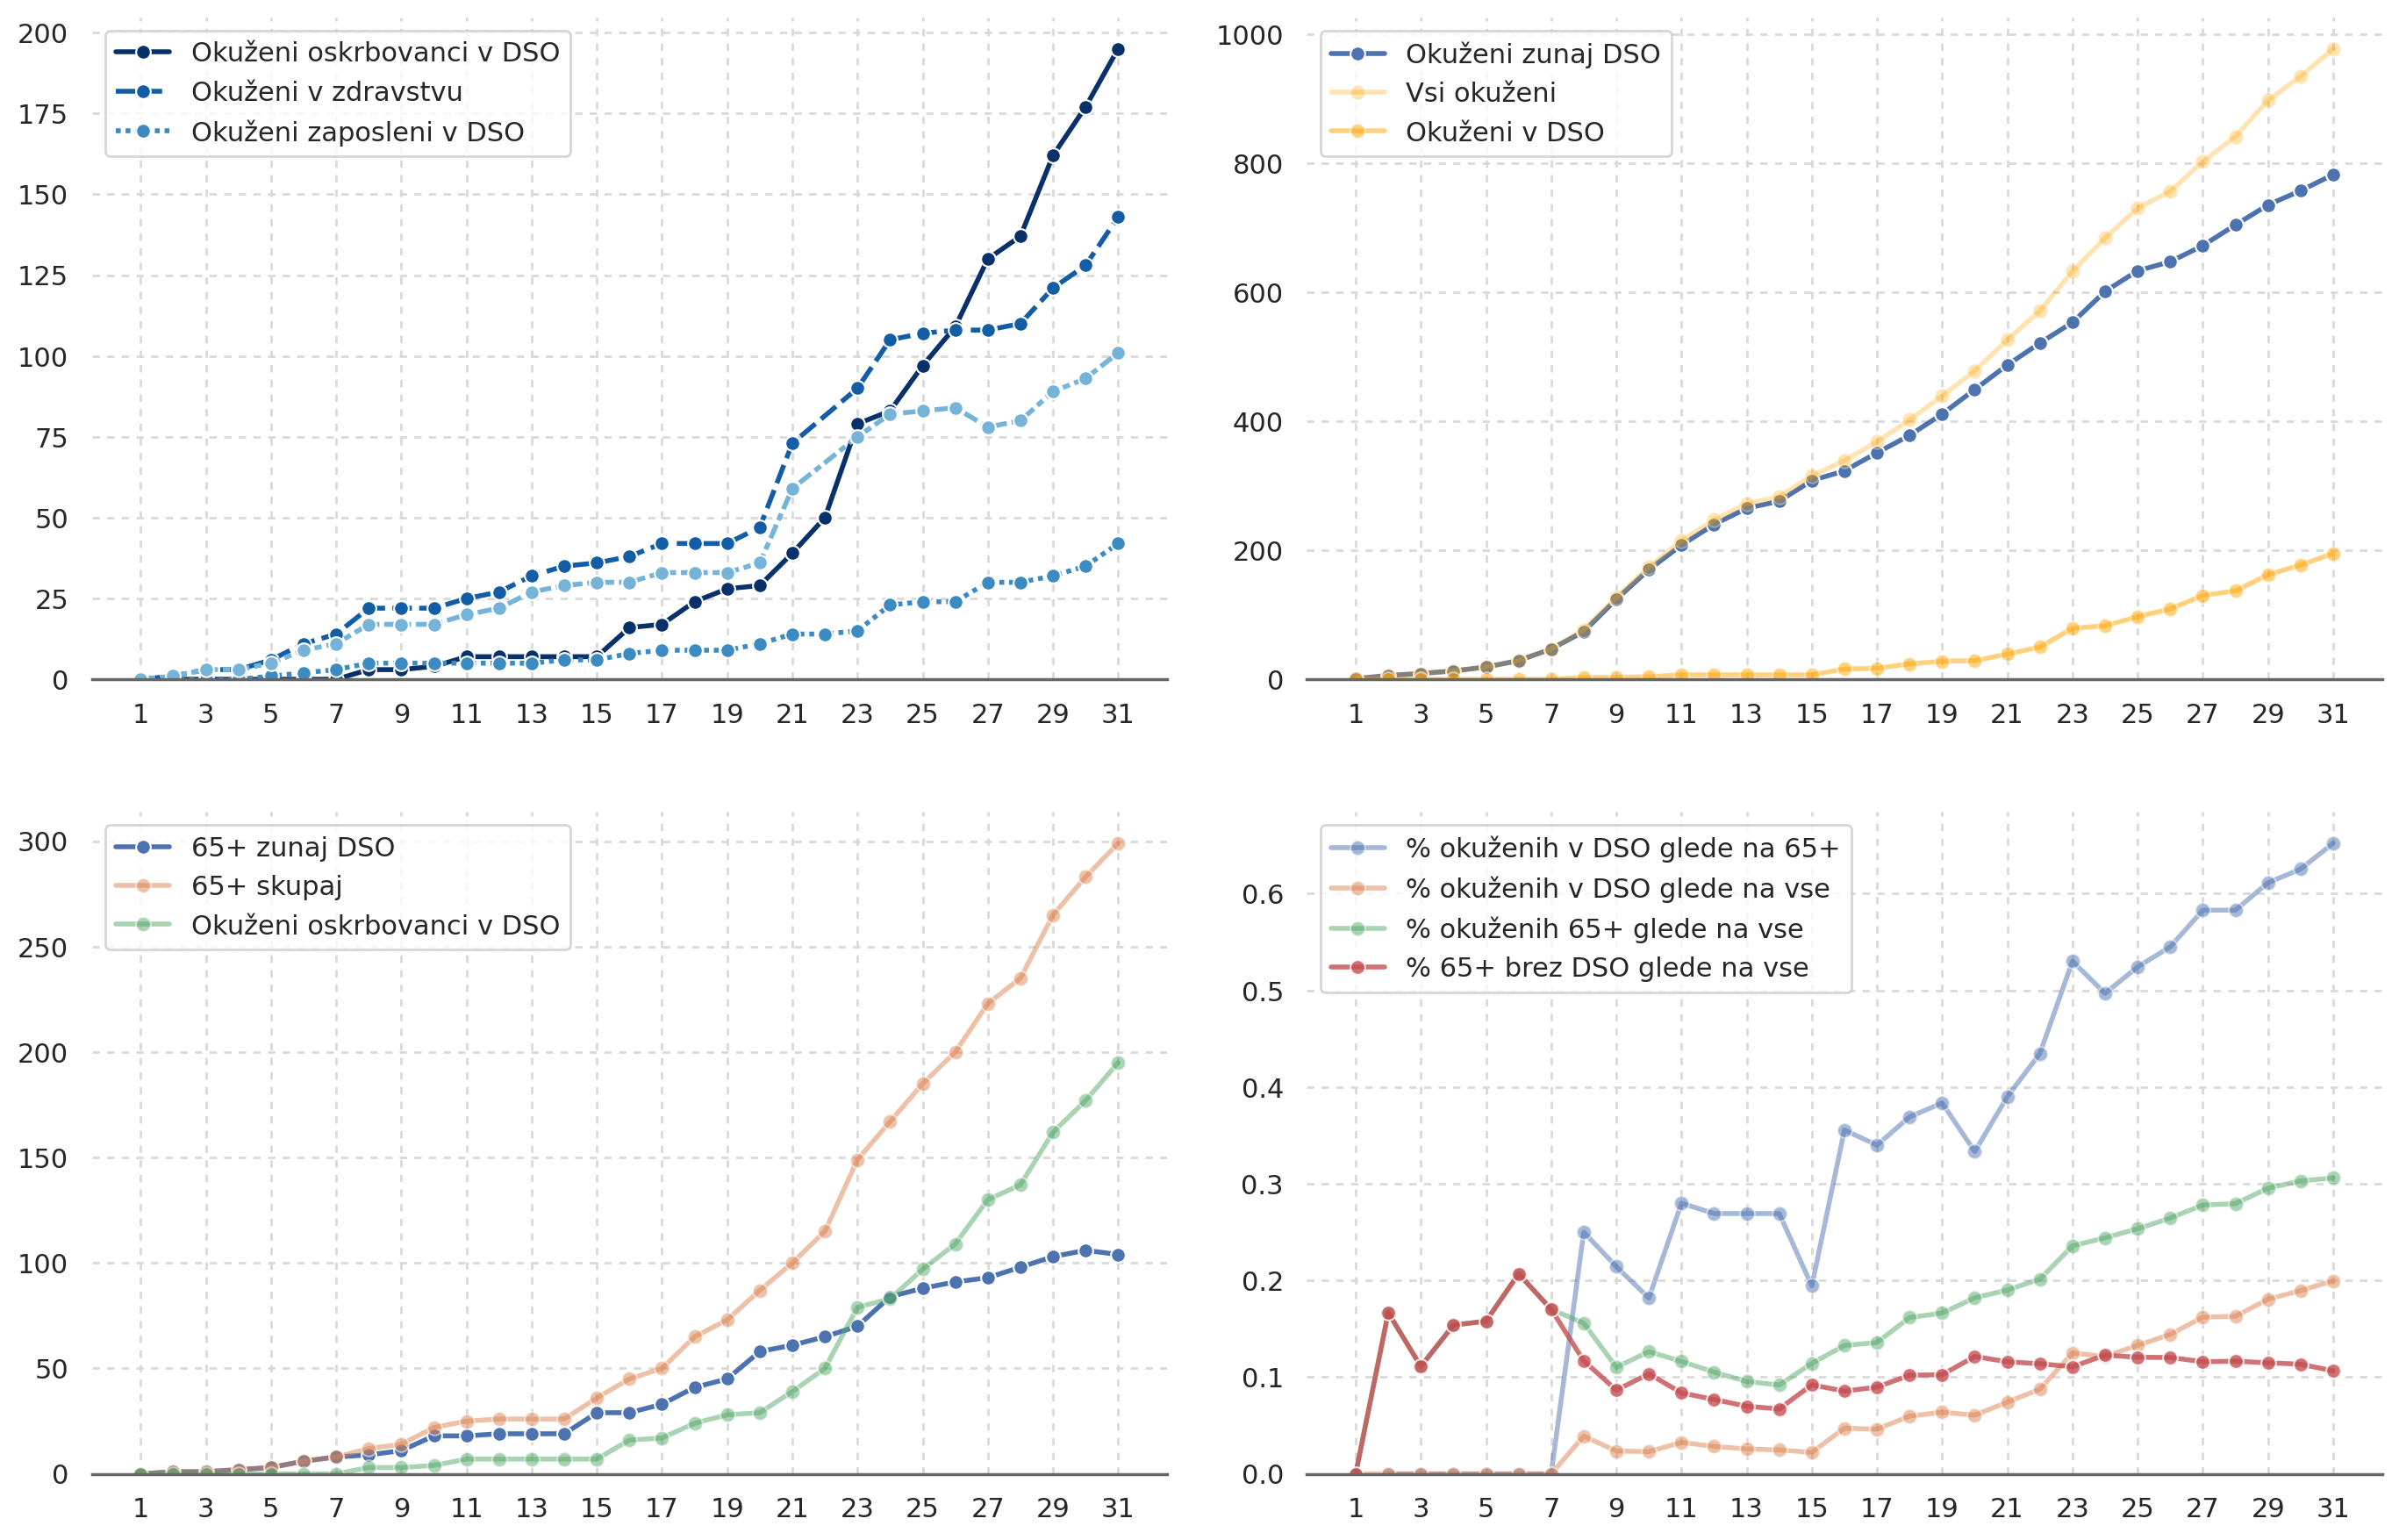

In [66]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)


dfp = df[4:]


sns.lineplot(dfp.index, dfp["oku_24h"] - dfp["p_oku_dso"], color="b", ax=ax2)
sns.lineplot(dfp.index, dfp["oku_24h"], color="orange", alpha=.3, ax=ax2)
sns.lineplot(dfp.index, dfp["p_oku_dso"], color="orange", alpha=.5, ax=ax2)
utils_plot1(ax2, False, "", None, dfp.index[::2])
ax2.legend(["Okuženi zunaj DSO", "Vsi okuženi", "Okuženi v DSO"])


sns.lineplot(data=dfp[["p_oku_dso", "p_oku_zdravstvo", "p_oku_dsoz", "p_oku_zdravstvo1"]], palette=cmap, ax=ax1)
utils_plot1(ax1, False, "", None, dfp.index[::2])
ax1.legend(["Okuženi oskrbovanci v DSO", "Okuženi v zdravstvu", "Okuženi zaposleni v DSO"])

#plt.yscale("log")
#sns.lineplot(dfp.index, dfp["p_oku_dso"]/dfp[starosti10_skupine[4]])
'''
sns.lineplot(dfp.index, dfp["p_oku_dsoz"]/dfp["oku_24h"])
sns.lineplot(dfp.index, dfp["p_oku_zdravstvo"]/dfp["oku_24h"])
sns.lineplot(dfp.index, dfp["p_oku_dso"]/dfp["oku_24h"])
plt.ylim(0,0.4)'''
sns.lineplot(dfp.index, dfp[starosti10_skupine[4]] - dfp["p_oku_dso"], ax=ax3)
sns.lineplot(dfp.index, dfp[starosti10_skupine[4]], alpha=.5, ax=ax3)
sns.lineplot(dfp.index, dfp["p_oku_dso"], alpha=.5, ax=ax3)
utils_plot1(ax3, False, "", None, dfp.index[::2])
ax3.legend(["65+ zunaj DSO", "65+ skupaj", "Okuženi oskrbovanci v DSO"])

sns.lineplot(dfp.index, dfp["p_oku_dso"]/dfp[starosti10_skupine[4]], ax=ax4, alpha=.5)
sns.lineplot(dfp.index, dfp["p_oku_dso"]/dfp["oku_24h"], ax=ax4, alpha=.5)
sns.lineplot(dfp.index, dfp[starosti10_skupine[4]]/dfp["oku_24h"], ax=ax4, alpha=.5)
sns.lineplot(dfp.index, (dfp[starosti10_skupine[4]] - dfp["p_oku_dso"])/dfp["oku_24h"], ax=ax4, alpha=.8)
utils_plot1(ax4, False, "", None, dfp.index[::2])
ax4.legend(["% okuženih v DSO glede na 65+", "% okuženih v DSO glede na vse", "% okuženih 65+ glede na vse", "% 65+ brez DSO glede na vse"])

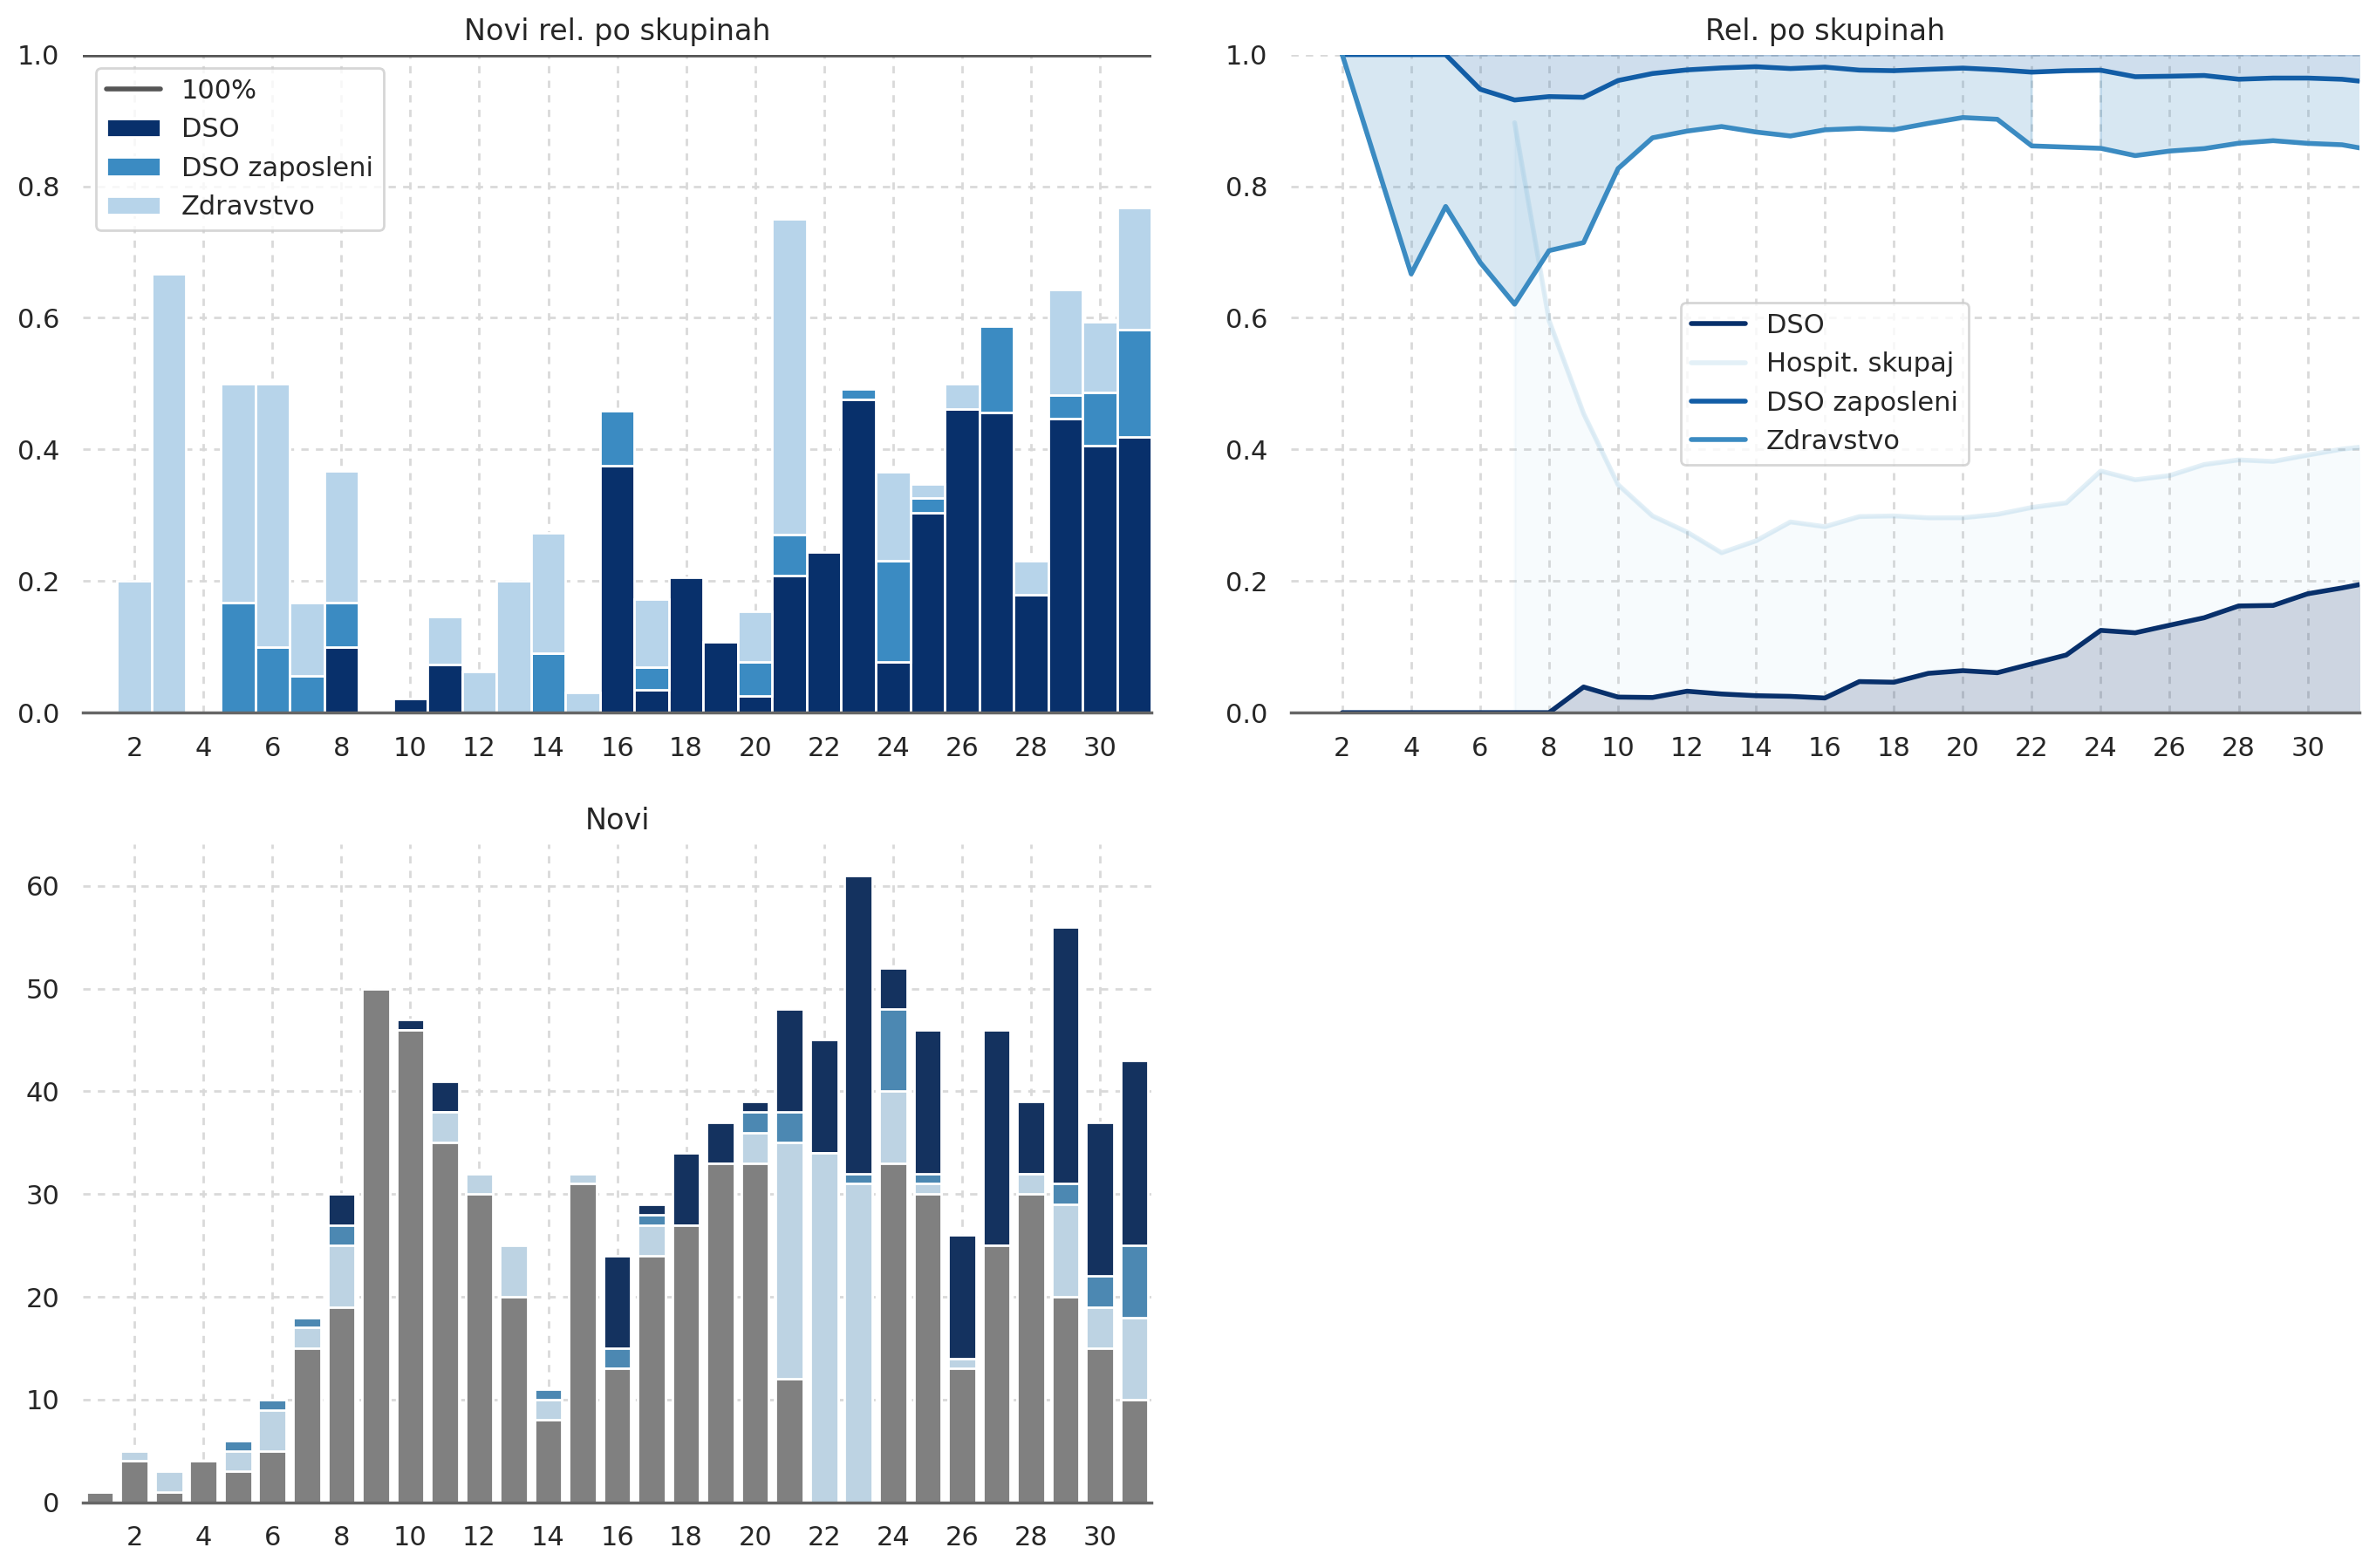

In [67]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)
dfp = df[4:]

dfp[["p_oku_dso_novi_rel", "p_oku_dsoz_novi_rel", "p_oku_zdravstvo1_novi_rel"]].plot(ax=ax1, kind="bar", stacked=True, width=1, color=cmap[::2])
utils_plot1(ax1, False, "Novi rel. po skupinah", (0, 1), None)
ax1.axhline(1, color="#555", linewidth=2, marker="")
ax1.legend(["100%", "DSO", "DSO zaposleni", "Zdravstvo", "Nove hospitalizacije"])


sns.lineplot(dfp.index, dfp["p_oku_dso_rel"], color=blues_d[4], marker="", ax=ax2)
ax2.fill_between(dfp.index, 0, dfp["p_oku_dso_rel"], color=blues_d[4], alpha=.2)

sns.lineplot(dfp.index, dfp["hospitalizirani_neur_skupaj_rel"] + dfp["p_oku_dso_rel"], color=blues_d[1], alpha=.2, marker="", ax=ax2)
ax2.fill_between(dfp.index, dfp["p_oku_dso_rel"], dfp["hospitalizirani_neur_skupaj_rel"] + dfp["p_oku_dso_rel"], color=blues_d[1], alpha=.05)
#sns.lineplot(dfp.index, dfp["hospitalizirani_rel"] + dfp["p_oku_dso_rel"], color=blues_d[1], marker="", ax=ax2)

sns.lineplot(dfp.index, 1-dfp["p_oku_dsoz_rel"], color=blues_d[3], marker="", ax=ax2)
ax2.fill_between(dfp.index, 1-dfp["p_oku_dsoz_rel"], 1, color=blues_d[3], alpha=.2)

sns.lineplot(dfp.index, 1-dfp["p_oku_zdravstvo_rel"], color=blues_d[2], marker="", ax=ax2)
ax2.fill_between(dfp.index, 1-dfp["p_oku_zdravstvo_rel"], 1-dfp["p_oku_dsoz_rel"], color=blues_d[2], alpha=.2)

utils_plot1(ax2, False, "Rel. po skupinah", (0,1),None)
ax2.legend(["DSO", "Hospit. skupaj", "DSO zaposleni", "Zdravstvo"])

sns.barplot(dfp.index, dfp["oku_novi_24h"], ax=ax3, color=blues_d[4])
sns.barplot(dfp.index, dfp["oku_novi_24h"] - dfp["p_oku_dso_novi"], ax=ax3, color=blues_d[2])
sns.barplot(dfp.index, dfp["oku_novi_24h"] - dfp["p_oku_dso_novi"] - dfp["p_oku_dsoz_novi"], ax=ax3, color=blues_d[0])
sns.barplot(dfp.index, dfp["oku_novi_24h"] - dfp["p_oku_dso_novi"] - dfp["p_oku_dsoz_novi"] - dfp["p_oku_zdravstvo1_novi"], ax=ax3, color="grey")
utils_plot1(ax3, False, "Novi", None, None)
plt.xticks(dfp.index[::2], dfp.index[1::2])
ax4.remove()

---

## Okuženi brez DSO

In [68]:
df["p_oku_brezdso"] = dfp["oku_24h"] - dfp["p_oku_dso"]
df["p_oku_brezdso_novi"] = df.p_oku_brezdso.diff()
df["p_rast_brezdso"] = [None] + [df.p_oku_brezdso[i]/df.p_oku_brezdso[i-1] for i in df.index[1:]]
df["p_podvojitev_brezdso"] = math.log(2)/np.log(df["p_rast_brezdso"])

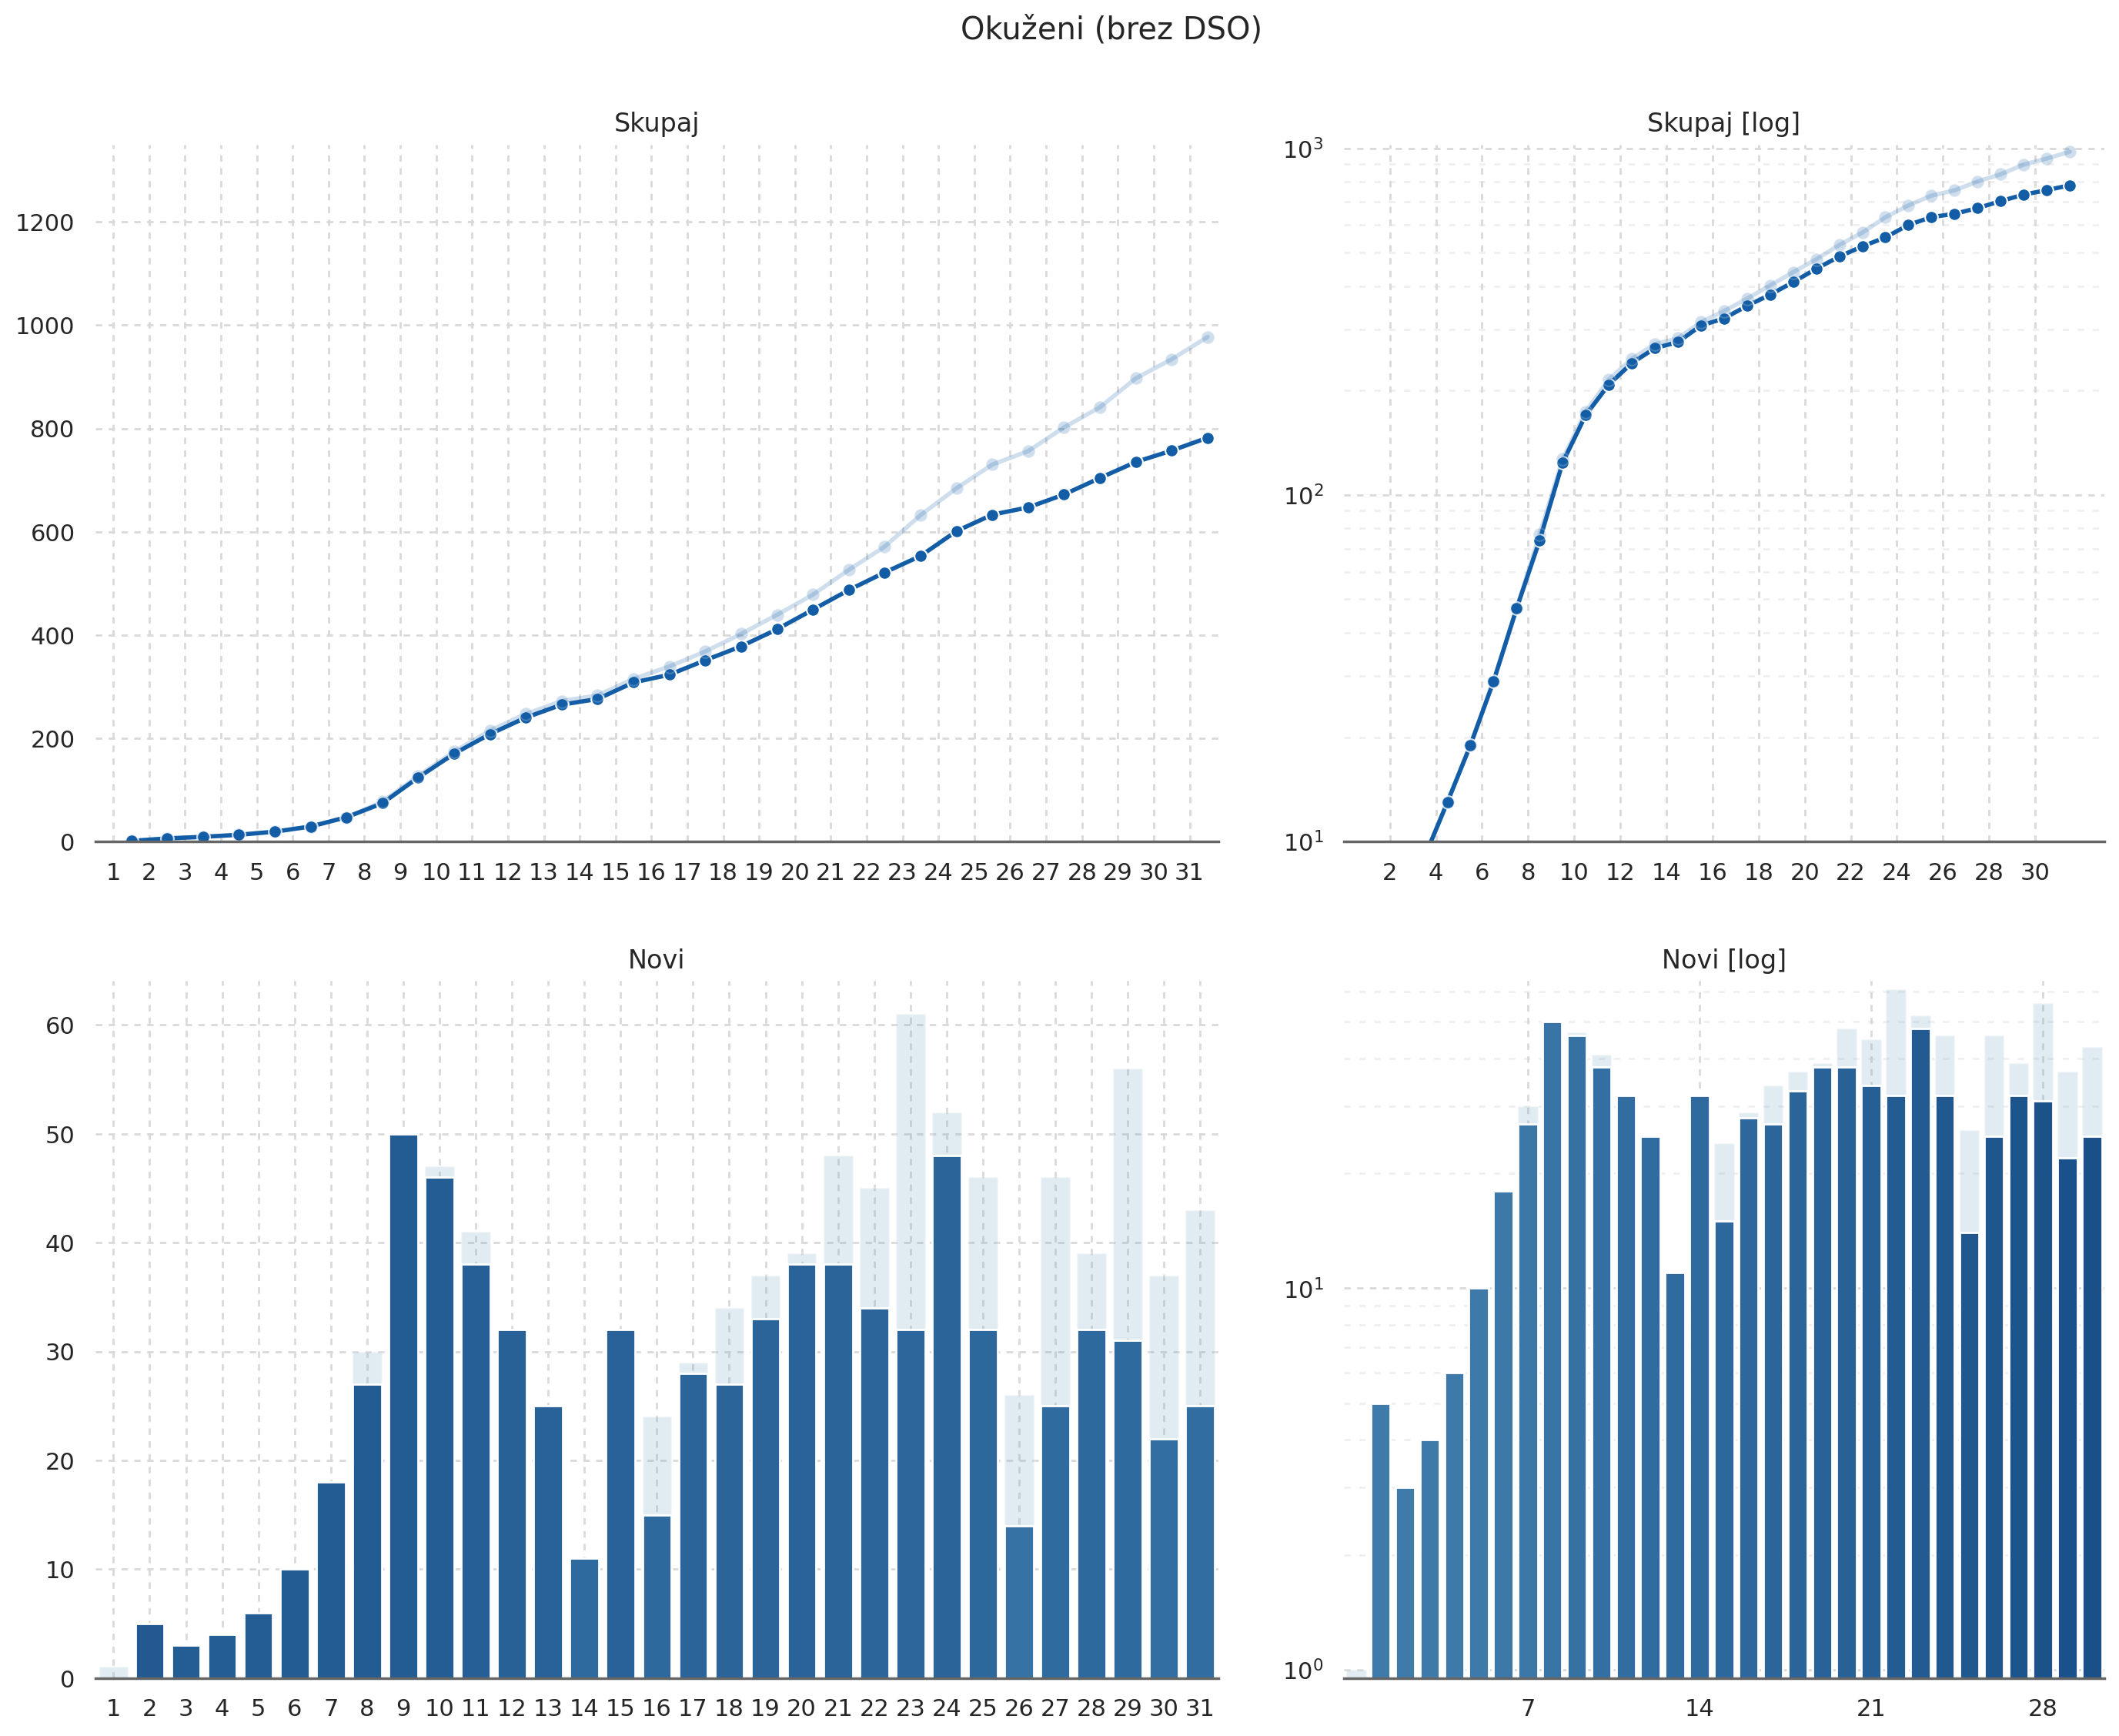

In [69]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex="all")

fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 50)
ax1 = fig.add_subplot(gs[0, 0:28])
ax2 = fig.add_subplot(gs[0, 31:])
ax3 = fig.add_subplot(gs[1, 0:28])
ax4 = fig.add_subplot(gs[1, 31:])

fig.suptitle("Okuženi (brez DSO)")
dfp = df[4:]
c=cmap[1]
plot_line1(ax1, dfp.index+.5, dfp.p_oku_brezdso, False, "Skupaj", xticks=dfp.index,
          x2=dfp.index+.5, y2=dfp.oku_24h, c=c)
ax1.set_ylim(0, 1350)
ax1.set_xlim(0.5, dfp.index[-1]+.8)
plot_line1(ax2, dfp.index+.5, dfp.p_oku_brezdso, True, "Skupaj", xticks=dfp.index[1::2],
          x2=dfp.index+.5, y2=dfp.oku_24h, ylim=10, c=c)

#plot_bar_m1(ax3, dfp.index, dfp.oku_novi_24h, False, "Novi", xticks=dfp.index, 
#          x2=dfp.index - .5, y2=dfp.oku_novi_14h, c=c)#, x3=dfp.index+.55-1, y3=dfp.oku_novi_gov)
#plot_bar_m1(ax4, dfp.index, dfp.oku_novi_24h, True, "Novi", xticks=dfp.index[::2], 
#         x2=dfp.index - .5, y2=dfp.oku_novi_14h, c=c, ylim=(1,100))#, x3=dfp.index+.55-1, y3=dfp.oku_novi_gov)

sns.barplot(dfp.index, dfp.oku_novi_24h, alpha=.2, ax=ax3, color=cm.Blues(.55))
sns.barplot(dfp.index, dfp.p_oku_brezdso_novi, ax=ax3, palette=cm.Blues(.85 - (dfp['p_podvojitev_brezdso']**0.55)/60))

utils_plot1(ax3, False, "Novi", None, None)
plt.xticks(dfp.index[6::7], dfp.index[6::7])

sns.barplot(dfp.index, dfp.oku_novi_24h, alpha=.2, ax=ax4, color=cm.Blues(.55))
sns.barplot(dfp.index, dfp.p_oku_brezdso_novi, ax=ax4, palette=cm.Blues(.7 + 0.25*np.log(1+dfp['oku_24h']/dfp.at[df.index[-2], 'oku_24h']) ))

utils_plot1(ax4, True, "Novi", None, None)
plt.xticks(dfp.index[6::7], dfp.index[6::7])
plt.show()

## Rast brez DSO

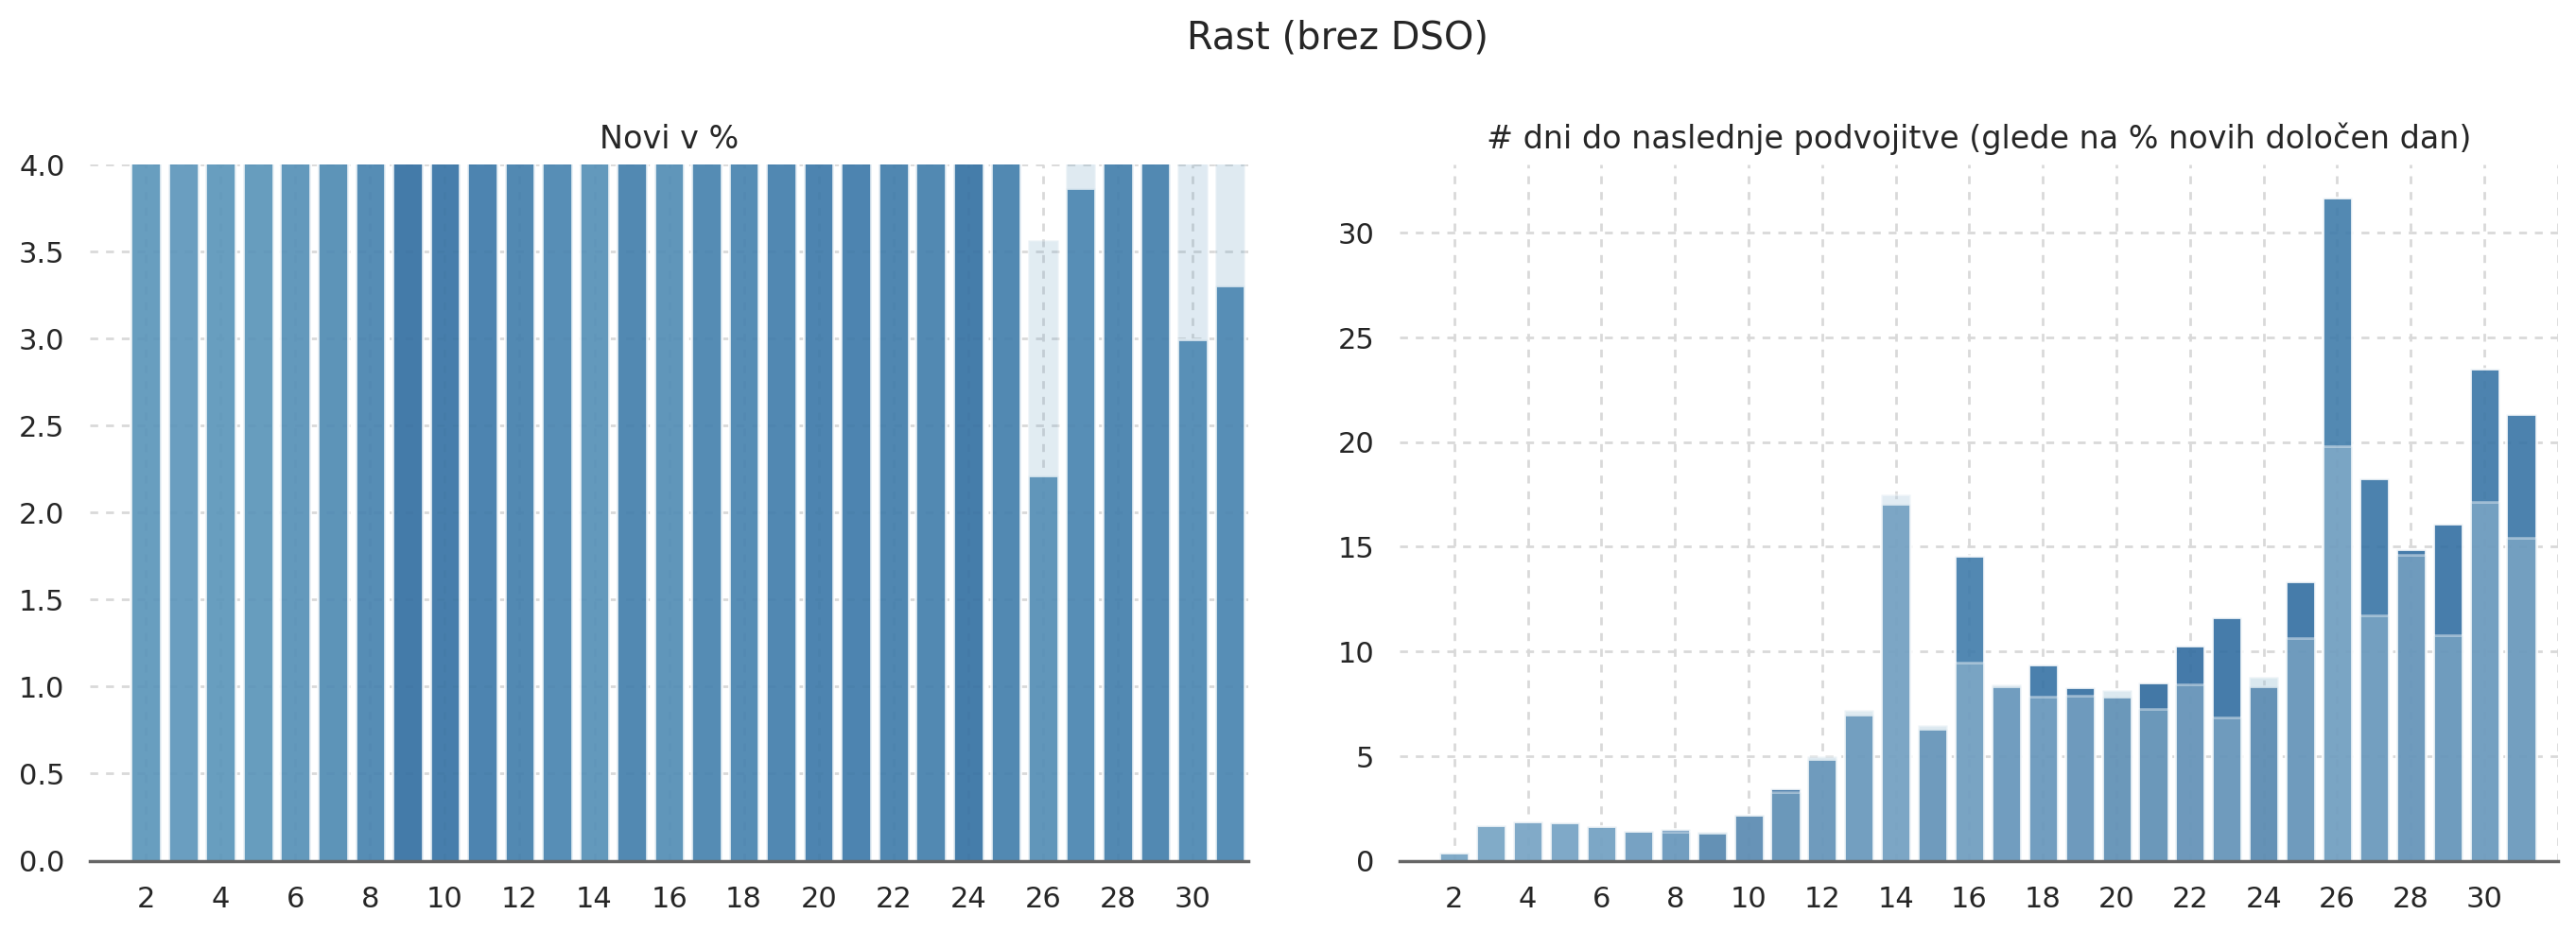

In [70]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5.5), sharex=True)
fig.suptitle("Rast (brez DSO)", y=0.96)
dfp = df[4:]

sns.barplot(dfp.index, dfp.p_rast_brezdso*100-100, ax=ax1, palette=cm.Blues(.6 + dfp['p_oku_brezdso_novi']/300), alpha=.9)
sns.barplot(dfp.index, dfp.rast_24h*100-100, ax=ax1, palette=cm.Blues(.5 + dfp['p_oku_brezdso_novi']/300), alpha=.2)
utils_plot1(ax1, False, "Novi v %", (0, 4), None)

sns.barplot(dfp.index, dfp.p_podvojitev_brezdso, ax=ax2,palette=cm.Blues(.65 + dfp['p_oku_brezdso_novi']/300), alpha=.9 )
sns.barplot(dfp.index, dfp.podvojitev_24h, ax=ax2, palette=cm.Blues(.3 + dfp['p_oku_brezdso_novi']/600), alpha=.4)
utils_plot1(ax2, False, "# dni do naslednje podvojitve (glede na % novih določen dan)", None, None)
plt.xticks(dfp.index[::2], dfp.index[1::2])
plt.subplots_adjust(top=0.82, bottom=.15)

## Napovedi brez DSO

In [71]:
#dfa = df[["oku_24h", "oku_novi_24h"]][3:].rename(columns={"oku_24h": "skupaj", "oku_novi_24h": "novi"})
dfa = df[["p_oku_brezdso", "p_oku_brezdso_novi"]][5:].rename(columns={"p_oku_brezdso": "skupaj", "p_oku_brezdso_novi": "novi"})

In [72]:
ind = np.arange(0, dfa.index[-1]-1, 1)
c = dfa["skupaj"].to_numpy()[ind] / 2_000_000
dc = dfa["novi"].to_numpy()[ind] / 2_000_000
t = dfa.index.to_numpy()[ind]

t1 = weighted(t)
c1 = weighted(c)

In [73]:
p0 = np.array([1e-06, 0.001, 0.001])
res = scipy.optimize.least_squares(fun, p0, args=(t1, c1), method="lm")

In [74]:
p = res.x.copy()

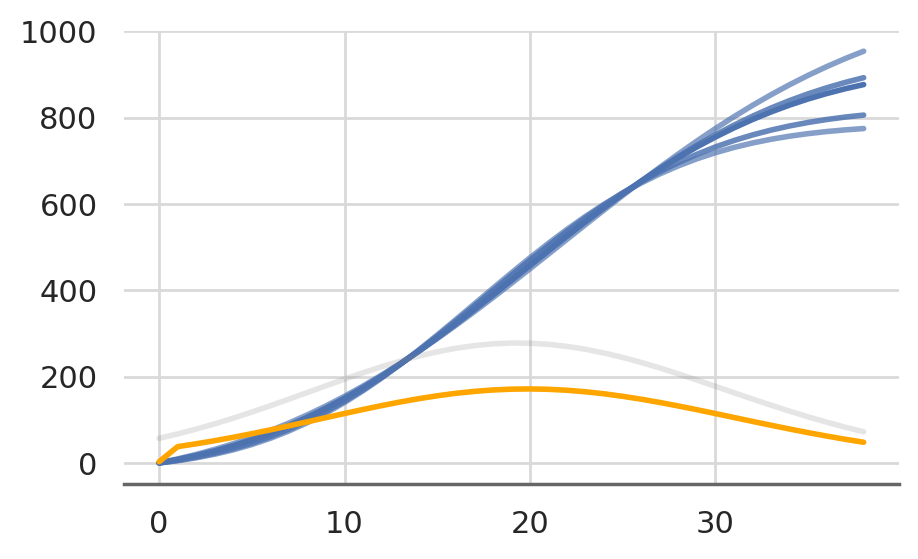

In [75]:
t_e = np.concatenate((t, [t[-1] + 1]))
t_e1 = weighted(t_e)

x, dx, _ = fun(p, t_e)
p_e = []
x_e = []
dx_e = []


tt =  np.arange(0, t[-1]+1 + 7, 1)

plt.figure(figsize=(5,3))
for e in [.84, .92, 1.08, 1.16]: #[.63, .84, 1.16, 1.44]:
    c_e = np.concatenate((c, x[-1:]*e))
    c_e1 = weighted(c_e)
    res1 = scipy.optimize.least_squares(fun, p, args=(t_e1, c_e1), method="lm")
    p1 = res1.x.copy()
    p_e.append(p1)
    
    x1, dx1, _ = fun(p1, tt)
    x_e.append(x1)
    dx_e.append(dx1)
    sns.lineplot(tt, x1*2_000_000, color="b", marker="", alpha=1-2*abs(1-e))

x, dx, ii = fun(p, tt)
sns.lineplot(tt, x*2_000_000, color="b", marker="", alpha=1)
sns.lineplot(tt, 5*np.array(ii)*2_000_000, marker="", color="grey", alpha=.2)
sns.lineplot(tt, 5*dx*2_000_000, marker="", color="orange")
plt.show()

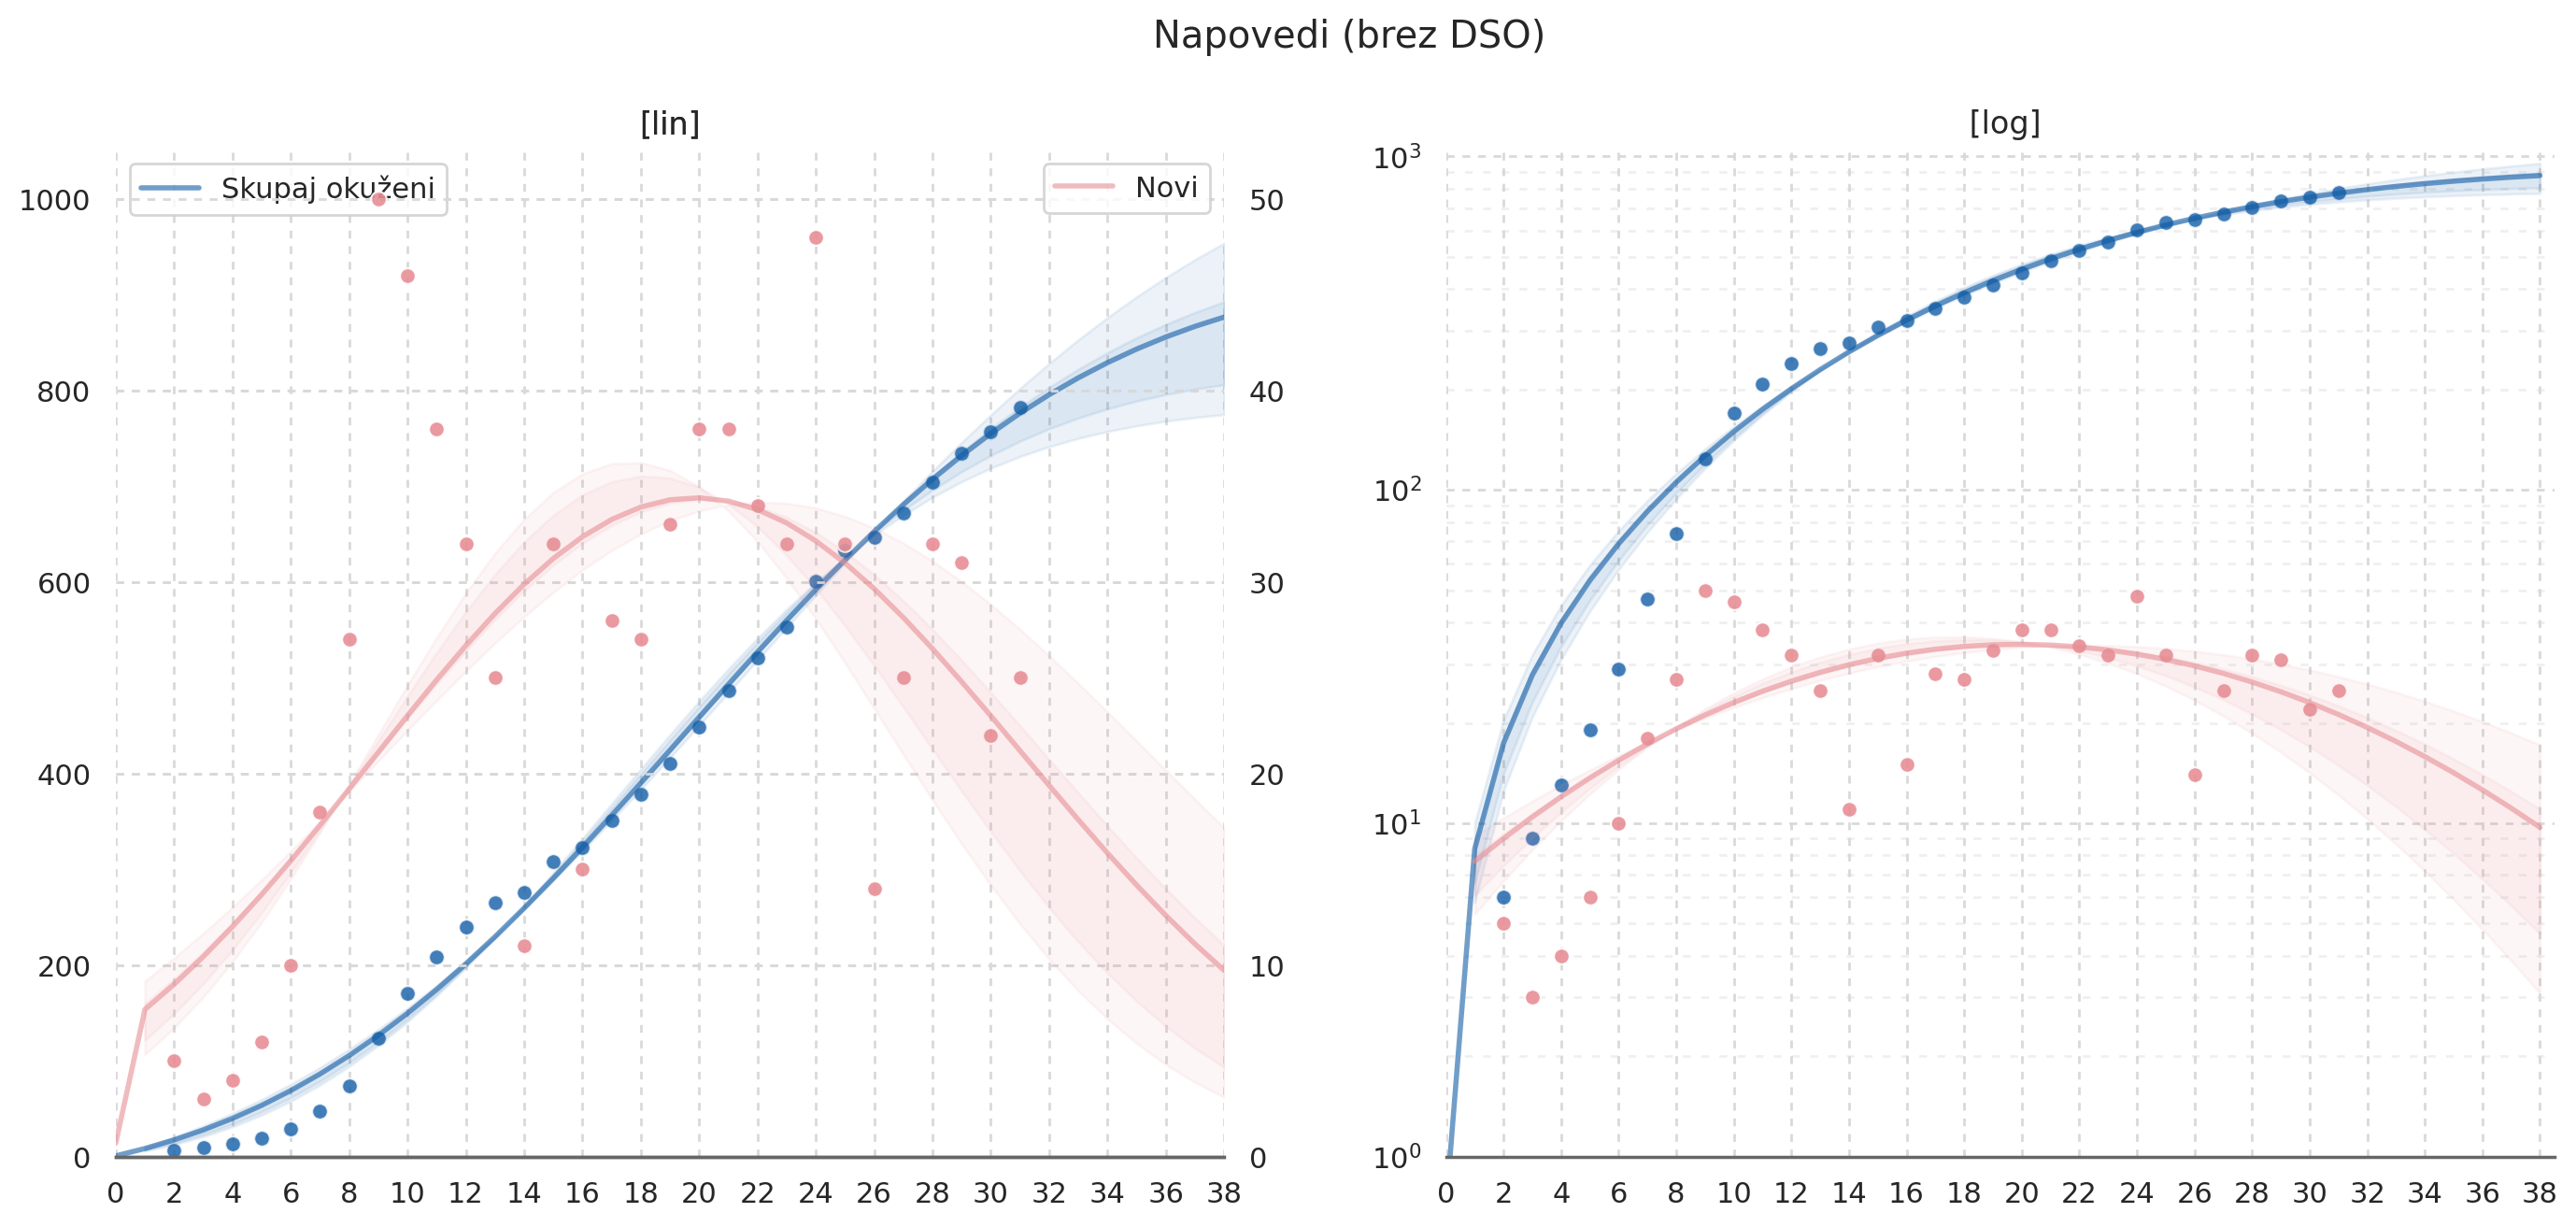

In [76]:
fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.suptitle("Napovedi (brez DSO)")

c1 = cmap[1]
c2 = cmap[8]

sns.lineplot(tt, x*2_000_000, color=c1, marker="", alpha=.6, ax=ax1)
sns.lineplot(tt[1:], dx[1:]*2_000_000, color=c2, marker="", alpha=.6, ax=ax1)
sns.scatterplot(t, c*2_000_000, color=c1, alpha=.8, ax=ax1)
sns.scatterplot(t, dc*2_000_000, color=c2, alpha=.9, ax=ax1)

st = -tt[-1]
ax1.fill_between(tt[st:], x_e[1][st:]*2_000_000, x_e[2][st:]*2_000_000, color=c1, alpha=.08)
ax1.fill_between(tt[st:], x_e[0][st:]*2_000_000, x_e[3][st:]*2_000_000, color=c1, alpha=.08)
ax1.fill_between(tt[st:], dx_e[1][st:]*2_000_000, dx_e[2][st:]*2_000_000, color=c2, alpha=.08)
ax1.fill_between(tt[st:], dx_e[0][st:]*2_000_000, dx_e[3][st:]*2_000_000, color=c2, alpha=.08)

utils_plot1(ax1, True, "", (1, 1.2*x[-1]*2_000_000), tt[::2])
ax1.set_xlim(0, tt[-1]+.5)


ax2s = ax2.twinx()
sns.lineplot(tt, x*2_000_000, color=c1, marker="", alpha=.6, ax=ax2)
sns.scatterplot(t, c*2_000_000, color=c1, alpha=.8, ax=ax2)
sns.lineplot(tt, dx*2_000_000, color=c2, marker="", alpha=.6, ax=ax2s)
sns.scatterplot(t, dc*2_000_000, color=c2, alpha=.9, ax=ax2s)

ax2.fill_between(tt[st:], x_e[1][st:]*2_000_000, x_e[2][st:]*2_000_000, color=c1, alpha=.08)
ax2.fill_between(tt[st:], x_e[0][st:]*2_000_000, x_e[3][st:]*2_000_000, color=c1, alpha=.08)
ax2s.fill_between(tt[st:], dx_e[1][st:]*2_000_000, dx_e[2][st:]*2_000_000, color=c2, alpha=.08)
ax2s.fill_between(tt[st:], dx_e[0][st:]*2_000_000, dx_e[3][st:]*2_000_000, color=c2, alpha=.08)
ax2.legend(["Skupaj okuženi"], loc="upper left")
ax2s.legend(["Novi"])

utils_plot1(ax2s, False, "[lin]", (0, 1.2*x[-1]*2_000_000/20), tt[::2])
utils_plot1(ax2, False, "[lin]", (0, 1.2*x[-1]*2_000_000), tt[::2])
ax2.set_xlim(0, tt[-1])

plt.subplots_adjust(top=0.88, bottom=.11, wspace=.2)
#plt.savefig("./aa.png", dpi=200)
plt.show()

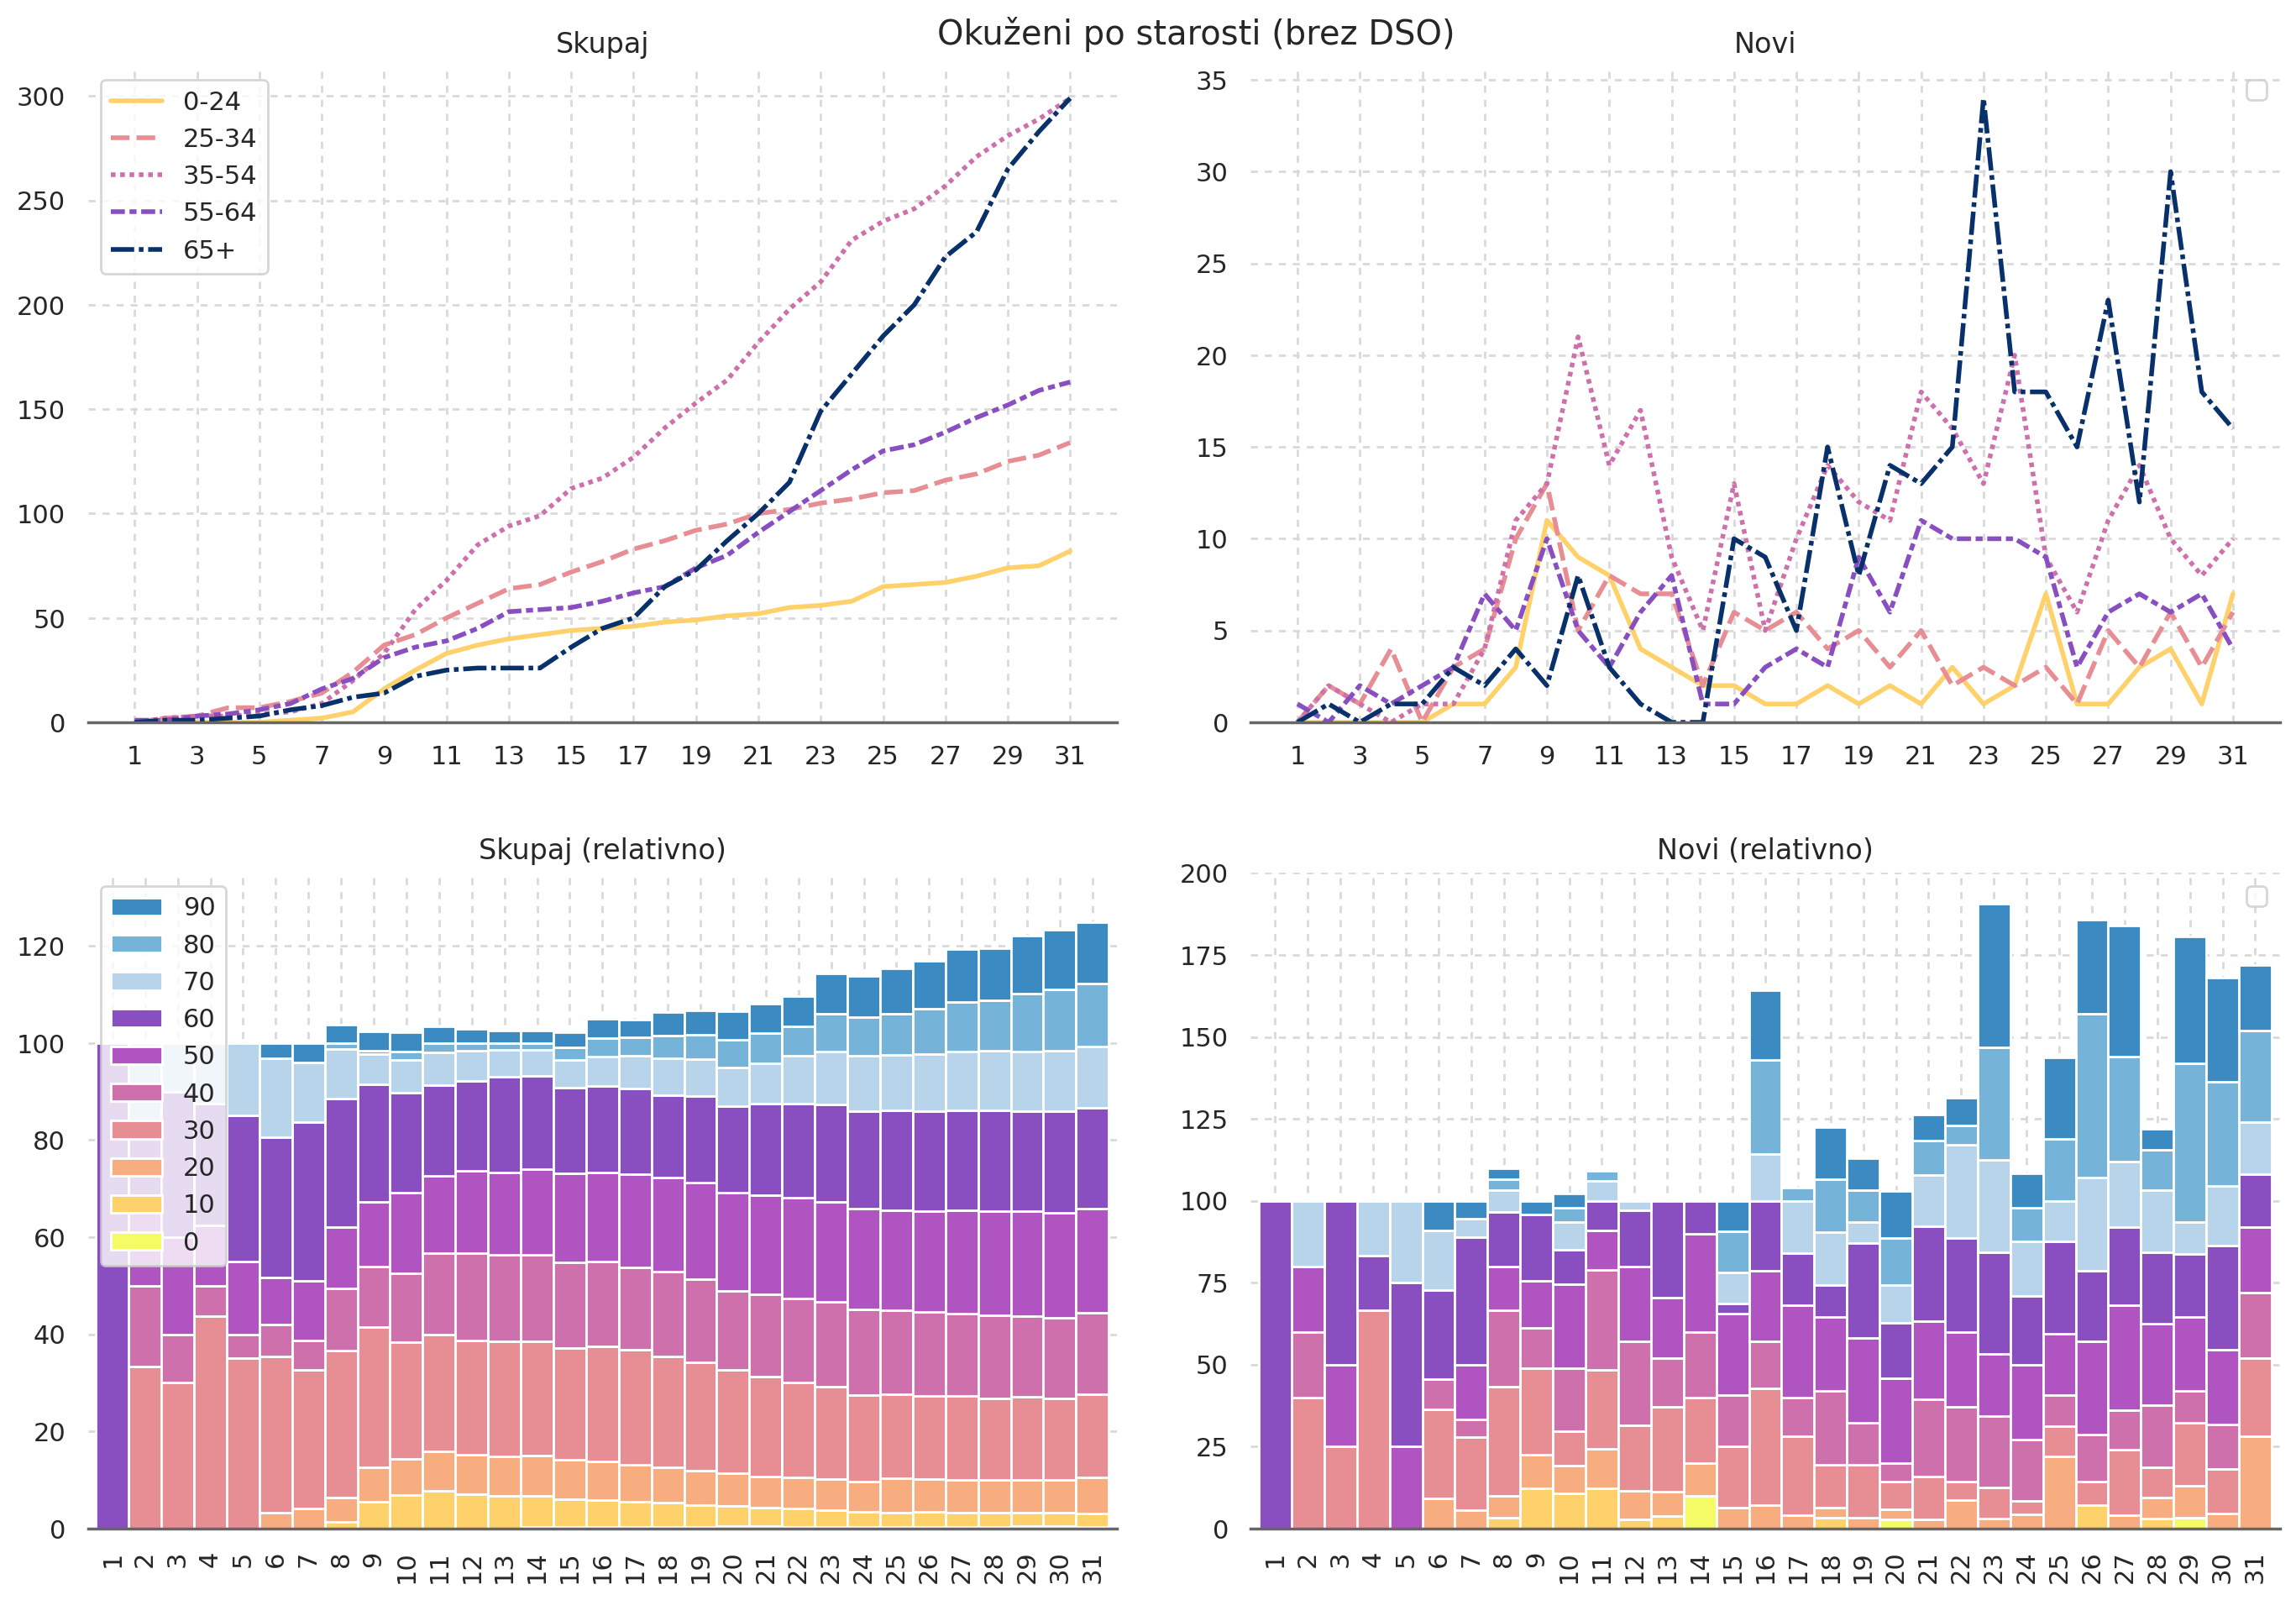

In [77]:

df[starosti_rel] = df[starosti].div(df[starosti].sum(axis=1) - dfp["p_oku_dso"], axis=0)*100
df[starosti_novi_rel] = df[starosti_novi].div(df[starosti_novi].sum(axis=1) - dfp["p_oku_dso_novi"], axis=0)*100

current_palette = sns.color_palette()
sns.set_palette(blues_dd)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Okuženi po starosti (brez DSO)")


dfp = df[4:]


cmapr = cmap[::-1]
cmapr2 = np.stack((cmapr[1,:], cmapr[3,:], cmapr[4,:], cmapr[6,:], cmapr[-1,:]))

sns.set_palette(cmapr2)
sns.lineplot(data=dfp[starosti10_skupine[:5]], ax=ax1, marker="")
#ax1.legend(starosti5 + starosti10_skupine)
ax1.legend(starosti10_skupine)
leg = ax1.get_legend()
for i, h in enumerate(leg.legendHandles[5:]):
    h.set_color(cmapr2[i]) 
utils_plot1(ax1, False, "Skupaj", None, dfp.index[::2])

#sns.set_palette(blues_dd)
#sns.lineplot(data=dfp[starosti5_novi], ax=ax2)
sns.set_palette(cmapr2)
sns.lineplot(data=dfp[starosti10_skupine_novi], ax=ax2, marker="")
ax2.legend("")
utils_plot1(ax2, False, "Novi", None, dfp.index[::2])



#dfp[starosti_rel[:5]].plot(ax=ax3, kind="bar", stacked=True, width=1, color=blues_d)
#dfp[starosti_rel[5:]].plot(ax=ax3, kind="bar", stacked=True, width=1, color=cmapr)
dfp[starosti_rel].plot(ax=ax3, kind="bar", stacked=True, width=1, color=cmapr)
utils_plot1(ax3, False, "Skupaj (relativno)", (0, 135), None)
ax3.legend("", loc="center left")
sns.set_palette(cmapr)
reverse_legend(ax3, starosti)

#dfp[starosti_novi_rel[:5]].plot(ax=ax4, kind="bar", stacked=True, width=1, color=blues_d)
#dfp[starosti_novi_rel[5:]].plot(ax=ax4, kind="bar", stacked=True, width=1, color=cmapr)
dfp[starosti_novi_rel].plot(ax=ax4, kind="bar", stacked=True, width=1, color=cmapr)
ax4.legend("")

utils_plot1(ax4, False, "Novi (relativno)", (0, 200), None)

sns.set_palette(current_palette)
plt.subplots_adjust(top=0.95, hspace=.23)
#plt.subplots_adjust(top=0.95, hspace=.23, bottom=.05)